# Stage 1: Course Discovery for Early Warning System

**Universidad Autónoma de Chile - LMS Analytics Project**

---

## Purpose

This notebook implements **Stage 1** of the intern exploration workflow: identifying high-potential courses for early failure prediction analysis.

### What We're Looking For

Courses with **high analytical potential** based on:
1. **Active enrollment** - Current semester (term 336) or recent past (term 322)
2. **Grade data with variance** - Not all students passing or failing
3. **Good LMS design** - Assignments, modules, and student engagement
4. **Sufficient sample size** - At least 15-20 students with grades

### Failure Threshold

- **Chilean scale:** < 4.0 on 1-7 scale = FAIL
- **Percentage scale:** < 57% = FAIL (used in this analysis)

### Scope

- **INCLUDE:** PREGRADO (Account 46) and POSTGRADO (Account 42) sub-accounts
- **EXCLUDE:** Account 719 (Ing. en Control de Gestión) - already analyzed

### What This Notebook Does NOT Do

- Does NOT extract Page Views (that's Stage 2)
- Does NOT write large data dumps to disk
- Does NOT modify any Canvas data
- Does NOT train prediction models

---

**Author:** Data Engineering Team  
**Last Updated:** December 2025  
**Environment:** TEST (uautonoma.test.instructure.com)

## 2. Setup & Credentials

We load credentials securely from environment variables using `python-dotenv`.

**Security Note:** Never commit API tokens to version control. The `.env` file is in `.gitignore`.

In [29]:
# =============================================================================
# IMPORTS
# =============================================================================
import os
import sys
import time
from datetime import datetime

import requests
import pandas as pd
import numpy as np
from dotenv import load_dotenv

# Display settings
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.width', 200)

print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Requests version: {requests.__version__}")
print(f"Notebook started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Python version: 3.14.2 (v3.14.2:df793163d58, Dec  5 2025, 12:18:06) [Clang 16.0.0 (clang-1600.0.26.6)]
Pandas version: 2.3.3
Requests version: 2.32.5
Notebook started: 2025-12-26 17:12:25


In [30]:
# =============================================================================
# LOAD CREDENTIALS FROM .env
# =============================================================================
# The .env file should be in the project root (one level up from notebooks/)

env_path = os.path.join(os.path.dirname(os.getcwd()), '.env')
load_dotenv(env_path)

API_URL = os.getenv('CANVAS_API_URL')
API_TOKEN = os.getenv('CANVAS_API_TOKEN')

# =============================================================================
# FAIL FAST IF CREDENTIALS ARE MISSING
# =============================================================================
if not API_URL:
    raise ValueError(
        "CANVAS_API_URL not found in environment variables.\n"
        "Please create a .env file in the project root with:\n"
        "CANVAS_API_URL=https://your-institution.instructure.com"
    )

if not API_TOKEN:
    raise ValueError(
        "CANVAS_API_TOKEN not found in environment variables.\n"
        "Please create a .env file in the project root with:\n"
        "CANVAS_API_TOKEN=your_access_token_here"
    )

# Build authorization header
HEADERS = {'Authorization': f'Bearer {API_TOKEN}'}

# Display sanitized confirmation
print(f"API URL: {API_URL}")
print(f"API Token: {API_TOKEN[:10]}...{API_TOKEN[-4:]} (length: {len(API_TOKEN)})")
print("\nCredentials loaded successfully!")

API URL: https://uautonoma.test.instructure.com
API Token: 15510~P322...NYWB (length: 70)

Credentials loaded successfully!


## 3. Safe Request Utilities (Rate-Limit Aware)

Canvas uses a **leaky bucket algorithm** for rate limiting. We must:

1. Monitor `X-Rate-Limit-Remaining` header after each request
2. Apply dynamic delays based on remaining quota
3. Implement exponential backoff for transient failures
4. Never loop aggressively

### Rate Limit Thresholds

| Remaining Quota | Delay (seconds) | Status |
|-----------------|-----------------|--------|
| 500+ | 0.2 | Abundant |
| 300-499 | 0.5 | Healthy |
| 200-299 | 1.0 | Moderate |
| 100-199 | 3.0 | Low |
| 50-99 | 10.0 | Very Low |
| < 50 | 30.0 | Critical |

In [31]:
# =============================================================================
# RATE LIMIT TRACKING
# =============================================================================

RATE_LIMIT_STATUS = {
    'last_remaining': None,
    'last_cost': None,
    'total_requests': 0,
    'total_cost': 0.0,
    'warnings': 0,
    'errors': 0
}

# Thresholds
RATE_LIMIT_WARNING_THRESHOLD = 200
RATE_LIMIT_CRITICAL_THRESHOLD = 50


def calculate_delay(remaining_quota):
    """
    Calculate delay based on remaining API quota.
    More conservative than aggressive - we want to preserve quota.
    
    Args:
        remaining_quota: Float indicating remaining rate limit quota
        
    Returns:
        Float: Seconds to wait before next request
    """
    if remaining_quota is None:
        return 0.5  # Default if unknown
    
    if remaining_quota < 50:
        return 30.0  # Critical - almost no quota
    elif remaining_quota < 100:
        return 10.0  # Very low
    elif remaining_quota < 200:
        return 3.0   # Low
    elif remaining_quota < 300:
        return 1.0   # Moderate
    elif remaining_quota < 500:
        return 0.5   # Healthy
    else:
        return 0.2   # Abundant


def check_rate_limit(response, verbose=False):
    """
    Check and log rate limit headers from a Canvas API response.
    
    Args:
        response: requests.Response object
        verbose: If True, always print rate limit info
        
    Returns:
        dict: Rate limit information
    """
    cost = response.headers.get('X-Request-Cost')
    remaining = response.headers.get('X-Rate-Limit-Remaining')
    
    info = {
        'cost': float(cost) if cost else None,
        'remaining': float(remaining) if remaining else None,
        'status_code': response.status_code
    }
    
    # Update global tracking
    RATE_LIMIT_STATUS['total_requests'] += 1
    if info['cost']:
        RATE_LIMIT_STATUS['total_cost'] += info['cost']
        RATE_LIMIT_STATUS['last_cost'] = info['cost']
    if info['remaining'] is not None:
        RATE_LIMIT_STATUS['last_remaining'] = info['remaining']
    
    # Check for warnings
    if info['remaining'] is not None:
        if info['remaining'] < RATE_LIMIT_CRITICAL_THRESHOLD:
            RATE_LIMIT_STATUS['warnings'] += 1
            print(f"⚠️  CRITICAL: Rate limit very low! Remaining: {info['remaining']:.1f}")
        elif info['remaining'] < RATE_LIMIT_WARNING_THRESHOLD and verbose:
            print(f"⚠️  WARNING: Rate limit getting low. Remaining: {info['remaining']:.1f}")
    
    # Verbose output
    if verbose and info['remaining'] is not None:
        print(f"    [Rate Limit] Cost: {info['cost']:.2f}, Remaining: {info['remaining']:.1f}")
    
    return info


def print_rate_limit_summary():
    """Print a summary of rate limit usage during this session."""
    print("\n" + "=" * 50)
    print("RATE LIMIT USAGE SUMMARY")
    print("=" * 50)
    print(f"Total requests made: {RATE_LIMIT_STATUS['total_requests']}")
    print(f"Total cost consumed: {RATE_LIMIT_STATUS['total_cost']:.2f}")
    if RATE_LIMIT_STATUS['last_remaining'] is not None:
        print(f"Current remaining quota: {RATE_LIMIT_STATUS['last_remaining']:.1f}")
    print(f"Warnings triggered: {RATE_LIMIT_STATUS['warnings']}")
    print(f"Errors encountered: {RATE_LIMIT_STATUS['errors']}")
    
    if RATE_LIMIT_STATUS['last_remaining'] and RATE_LIMIT_STATUS['last_remaining'] < RATE_LIMIT_WARNING_THRESHOLD:
        print("\n⚠️  Quota is low. Consider waiting before making more requests.")
    else:
        print("\n✅ Quota is healthy.")


print("✅ Rate limit utilities initialized")
print(f"   Warning threshold: {RATE_LIMIT_WARNING_THRESHOLD}")
print(f"   Critical threshold: {RATE_LIMIT_CRITICAL_THRESHOLD}")

✅ Rate limit utilities initialized
   Warning threshold: 200
   Critical threshold: 50


In [32]:
# =============================================================================
# SAFE REQUEST WRAPPER
# =============================================================================

def safe_get(url, params=None, max_retries=3, verbose=False):
    """
    Make a GET request with rate limit awareness and retry logic.
    
    Args:
        url: The URL to request
        params: Optional dict of query parameters
        max_retries: Maximum number of retry attempts
        verbose: If True, print detailed info
        
    Returns:
        requests.Response object or None if all retries failed
    """
    retries = 0
    
    while retries < max_retries:
        try:
            # Apply rate-limit delay BEFORE request
            if RATE_LIMIT_STATUS['last_remaining'] is not None:
                delay = calculate_delay(RATE_LIMIT_STATUS['last_remaining'])
                if delay > 0:
                    time.sleep(delay)
            else:
                time.sleep(0.3)  # Default delay for first request
            
            response = requests.get(url, headers=HEADERS, params=params, timeout=30)
            
            # Check rate limit headers
            rate_info = check_rate_limit(response, verbose=verbose)
            
            # Handle rate limit exceeded (429)
            if response.status_code == 429:
                wait_time = 2 ** retries * 10  # Exponential backoff: 10, 20, 40 seconds
                print(f"⚠️  HTTP 429: Rate Limit Exceeded! Waiting {wait_time}s...")
                time.sleep(wait_time)
                retries += 1
                continue
            
            # Handle server errors with retry
            if response.status_code >= 500:
                wait_time = 2 ** retries * 2  # Exponential backoff: 2, 4, 8 seconds
                print(f"⚠️  HTTP {response.status_code}: Server error. Retrying in {wait_time}s...")
                time.sleep(wait_time)
                retries += 1
                continue
            
            return response
            
        except requests.exceptions.Timeout:
            print(f"⚠️  Request timeout. Retry {retries + 1}/{max_retries}")
            retries += 1
            time.sleep(2 ** retries)
            
        except requests.exceptions.RequestException as e:
            print(f"⚠️  Request error: {e}. Retry {retries + 1}/{max_retries}")
            retries += 1
            time.sleep(2 ** retries)
    
    RATE_LIMIT_STATUS['errors'] += 1
    print(f"❌ All {max_retries} retries failed for: {url}")
    return None


print("✅ safe_get() function defined")

✅ safe_get() function defined


In [33]:
# =============================================================================
# PAGINATION HELPER (BOOKMARK-BASED)
# =============================================================================
# Canvas uses bookmark-based pagination, NOT page numbers.
# The 'next' link is in the response headers, not the body.
# =============================================================================

def paginate(url, params=None, max_pages=10, verbose=False):
    """
    Handle Canvas API pagination using Link headers.
    
    Args:
        url: The initial API endpoint URL
        params: Query parameters for the first request
        max_pages: Safety limit to prevent infinite loops
        verbose: If True, print progress info
        
    Returns:
        list: All results combined from all pages
    """
    all_results = []
    page_count = 0
    current_url = url
    current_params = params
    
    while current_url and page_count < max_pages:
        response = safe_get(current_url, params=current_params, verbose=verbose)
        
        if response is None or response.status_code != 200:
            if response:
                print(f"⚠️  Pagination stopped: HTTP {response.status_code}")
            break
        
        data = response.json()
        
        # Handle both list and dict responses
        if isinstance(data, list):
            all_results.extend(data)
            if verbose:
                print(f"   Page {page_count + 1}: {len(data)} items")
        elif isinstance(data, dict):
            all_results.append(data)
        
        # Check for 'next' link in headers
        current_url = None
        link_header = response.headers.get('Link', '')
        
        for link in link_header.split(','):
            if 'rel="next"' in link:
                # Extract URL from <url>; rel="next" format
                current_url = link.split(';')[0].strip()[1:-1]
                break
        
        # After first request, params are in the URL
        current_params = None
        page_count += 1
    
    if page_count >= max_pages and current_url:
        print(f"⚠️  Reached max_pages limit ({max_pages}). Results may be incomplete.")
    
    return all_results


print("✅ paginate() function defined")

✅ paginate() function defined


## 4. Sanity Check: /users/self

Verify API connectivity by fetching the authenticated user's profile.

In [34]:
# =============================================================================
# API SANITY CHECK
# =============================================================================

print("Testing API connectivity...")
print("-" * 50)

response = safe_get(f"{API_URL}/api/v1/users/self", verbose=True)

if response and response.status_code == 200:
    user_data = response.json()
    print("\n✅ API CONNECTION SUCCESSFUL")
    print("=" * 50)
    print(f"User ID: {user_data.get('id')}")
    print(f"Name: {user_data.get('name')}")
    print(f"Login ID: {user_data.get('login_id', 'N/A')}")
    print(f"Created At: {user_data.get('created_at')}")
else:
    print("\n❌ API CONNECTION FAILED")
    if response:
        print(f"Status Code: {response.status_code}")
        print(f"Response: {response.text[:500]}")
    raise Exception("API sanity check failed. Cannot proceed.")

Testing API connectivity...
--------------------------------------------------
    [Rate Limit] Cost: 0.33, Remaining: 700.0

✅ API CONNECTION SUCCESSFUL
User ID: 138705
Name: Paul Sargent
Login ID: N/A
Created At: 2025-11-25T13:05:04-03:00


## 5. Account Discovery

Canvas organizes data in a hierarchy. **Important:** Token access may be limited to specific accounts.

```
Universidad Autónoma de Chile [Account 1]
├── PREGRADO [Account 46] ← Undergraduate programs (TOKEN HAS ACCESS)
│   ├── Providencia [176] - Multiple careers (26+ sub-accounts)
│   │   ├── Ing. Control de Gestión [719] - ALREADY ANALYZED ✓ (EXCLUDE)
│   │   ├── Medicina [249], Odontología [244], Psicología [247/314/315]
│   │   ├── Derecho [253/309/310], Ing. Comercial [311/312]
│   │   ├── Ing. Civil Industrial [263/730], Química y Farmacia [262]
│   │   └── ... and many more
│   ├── Temuco [173]
│   ├── Talca [174]
│   ├── San Miguel [175]
│   └── Campus Virtual [360]
│
└── POSTGRADO [Account 42] ← Graduate programs (MAY NOT HAVE ACCESS)
    └── Access depends on token permissions - check before scanning
```

### Key Account IDs

| Account ID | Name | Notes |
|------------|------|-------|
| 46 | PREGRADO | Undergraduate - **Primary focus** |
| 176 | Providencia | Main campus with 26+ career sub-accounts |
| 173/174/175 | Temuco/Talca/San Miguel | Regional campuses |
| 42 | POSTGRADO | Graduate - Access may be restricted |
| **719** | **Ing. en Control de Gestión** | **EXCLUDE - Already analyzed** |

### First: Discover What Accounts We Can Access

In [35]:
# =============================================================================
# DISCOVER ACCESSIBLE ACCOUNTS (NO HARDCODING)
# =============================================================================
# Dynamically traverse all accounts and sub-accounts visible to this token.
# =============================================================================

def discover_accessible_accounts(verbose=False):
    """
    Return the list of root accounts the token can access via /accounts.
    No hardcoded IDs; relies solely on API results.
    """
    url = f"{API_URL}/api/v1/accounts"
    params = {'per_page': 100}
    accounts = paginate(url, params=params, max_pages=10, verbose=verbose)
    return accounts or []


def build_account_hierarchy(max_depth=6, verbose=False):
    """
    Walk the account tree starting from accessible roots.
    Returns a DataFrame with id, name, parent_account_id, depth, workflow_state.
    """
    roots = discover_accessible_accounts(verbose=verbose)
    if not roots:
        print("❌ No accessible accounts returned by /accounts.")
        return pd.DataFrame()

    rows = []
    queue = []
    for acc in roots:
        acc_id = acc.get('id')
        rows.append({
            'id': acc_id,
            'name': acc.get('name', 'Unknown'),
            'parent_account_id': acc.get('parent_account_id'),
            'depth': 0,
            'workflow_state': acc.get('workflow_state')
        })
        queue.append((acc_id, 0))

    seen = {row['id'] for row in rows if row['id'] is not None}

    while queue:
        current_id, depth = queue.pop(0)
        if current_id is None or depth >= max_depth:
            continue

        url = f"{API_URL}/api/v1/accounts/{current_id}/sub_accounts"
        params = {'per_page': 100}
        subs = paginate(url, params=params, max_pages=10, verbose=verbose)

        if not subs:
            continue

        for sub in subs:
            sub_id = sub.get('id')
            if sub_id in seen:
                continue
            rows.append({
                'id': sub_id,
                'name': sub.get('name', 'Unknown'),
                'parent_account_id': sub.get('parent_account_id'),
                'depth': depth + 1,
                'workflow_state': sub.get('workflow_state')
            })
            seen.add(sub_id)
            queue.append((sub_id, depth + 1))

    df = pd.DataFrame(rows)
    if len(df) == 0:
        print("⚠️  No accounts discovered.")
        return df

    df = df.sort_values(['depth', 'id']).reset_index(drop=True)
    print(f"✅ Discovered {len(df)} accounts across {df['depth'].max() + 1} levels.")
    return df


print("ACCOUNT DISCOVERY (auto)")
print("=" * 60)

df_account_tree = build_account_hierarchy(max_depth=6, verbose=False)
ACCESSIBLE_ACCOUNT_IDS = set(df_account_tree['id'].dropna().astype(int).tolist()) if len(df_account_tree) > 0 else set()

if len(df_account_tree) > 0:
    roots = df_account_tree[df_account_tree['depth'] == 0][['id', 'name']]
    print("\nRoot accounts accessible:")
    display(roots)
    
    print("\nFirst 15 accounts in hierarchy (id | parent | depth | name):")
    display(df_account_tree.head(15)[['id', 'parent_account_id', 'depth', 'name']])
else:
    print("⚠️  No account data. Check token or API URL.")

# Compatibility flags (name-based, no hardcoded IDs)
names_series = df_account_tree['name'].fillna('') if len(df_account_tree) > 0 else pd.Series(dtype=str)
HAS_PREGRADO_ACCESS = any('PREGRADO' in n.upper() for n in names_series)
HAS_POSTGRADO_ACCESS = any('POSTGRADO' in n.upper() for n in names_series)


ACCOUNT DISCOVERY (auto)
✅ Discovered 210 accounts across 4 levels.

Root accounts accessible:


id      name
0  46  PREGRADO


First 15 accounts in hierarchy (id | parent | depth | name):


id  parent_account_id  depth                                          name
0    46                  1      0                                      PREGRADO
1   173                 46      1                                        Temuco
2   174                 46      1                                         Talca
3   175                 46      1                                    San Miguel
4   176                 46      1                                   Providencia
5   302                 46      1                                     PR-TE-PRU
6   360                 46      1                                Campus Virtual
7   177                173      2                                   Odontología
8   178                173      2                                  Arquitectura
9   179                173      2                                Trabajo Social
10  180                173      2                    Ingeniería en Construcción
11  181                173      2                                    Psicología
12  182                173      2                  Ingeniería Civil Informática
13  183                173      2                 Pedagogía en Educación Física
14  184                173      2  Auditoría e Ingeniería en Control de Gestión

In [36]:
# =============================================================================
# CONFIGURATION CONSTANTS (AUTO-DISCOVERED ACCOUNTS)
# =============================================================================
# Statistical thresholds remain static; account IDs come from df_account_tree.
# =============================================================================

if 'df_account_tree' not in globals() or len(df_account_tree) == 0:
    raise ValueError('Run the account discovery cell to populate df_account_tree before configuration.')

# -----------------------------------------------------------------------------
# ACCOUNT HIERARCHY CONFIGURATION (dynamic)
# -----------------------------------------------------------------------------

def _find_accounts_by_name(fragment):
    return df_account_tree[df_account_tree['name'].str.contains(fragment, case=False, na=False)]

def _pick_first_id(df):
    return int(df.iloc[0]['id']) if len(df) > 0 else None

ACCOUNT_ROOTS = df_account_tree[df_account_tree['parent_account_id'].isna()]['id'].dropna().astype(int).tolist()
ACCOUNT_ROOT = ACCOUNT_ROOTS[0] if len(ACCOUNT_ROOTS) > 0 else None
ACCOUNT_PREGRADO = _pick_first_id(_find_accounts_by_name('PREGRADO'))
ACCOUNT_POSTGRADO = _pick_first_id(_find_accounts_by_name('POSTGRADO'))

def _children_of(account_id):
    return df_account_tree[df_account_tree['parent_account_id'] == account_id][['id', 'name', 'depth']]

PREGRADO_CAMPUSES = {}
if ACCOUNT_PREGRADO:
    df_pregrado_children = _children_of(ACCOUNT_PREGRADO)
    PREGRADO_CAMPUSES = {int(row.id): row.name for row in df_pregrado_children.itertuples()}
else:
    print('⚠️  PREGRADO account not found; campus list empty.')

PREGRADO_CAREERS = {}
for campus_id in PREGRADO_CAMPUSES:
    df_careers = _children_of(campus_id)
    if len(df_careers) > 0:
        PREGRADO_CAREERS[int(campus_id)] = {int(row.id): row.name for row in df_careers.itertuples()}

# Accounts to EXCLUDE from analysis (known exclusions)
ACCOUNT_EXCLUDE = [719]       # Ing. en Control de Gestión - already analyzed
ACCOUNT_EXCLUDE_NAMES = {719: 'Ing. en Control de Gestión'}

# -----------------------------------------------------------------------------
# ENROLLMENT TERM CONFIGURATION
# -----------------------------------------------------------------------------
ENROLLMENT_TERMS = {
    336: 'Segundo Semestre 2025 - Periodo Completo (Current)',
    322: 'Primer Semestre 2025 - Periodo Completo (Past)',
    352: 'Segundo Semestre 2025 - Bimestral'
}
TERM_CURRENT = 336            # Primary term to analyze
TERM_PAST = 322               # Fallback term if current has no data

# -----------------------------------------------------------------------------
# ANALYSIS THRESHOLDS (Statistical Quality Gates)
# -----------------------------------------------------------------------------
MIN_STUDENTS = 15             # Minimum students for course to be considered
MIN_STUDENTS_WITH_GRADES = 10 # Minimum students with grades for analysis
PASS_THRESHOLD = 57.0         # Percentage threshold for passing (Chilean 4.0 = 57%)
MIN_GRADE_VARIANCE = 5.0      # Minimum std dev for meaningful prediction
HIGH_GRADE_VARIANCE = 10.0    # Threshold for 'high potential' classification
MIN_ASSIGNMENTS = 3           # Minimum assignments for 'medium potential'
HIGH_ASSIGNMENTS = 5          # Minimum assignments for 'high potential'
IDEAL_PASS_RATE_MIN = 0.20    # Minimum pass rate for balanced dataset
IDEAL_PASS_RATE_MAX = 0.80    # Maximum pass rate for balanced dataset

# -----------------------------------------------------------------------------
# COMPOSITE SCORE WEIGHTS (for course ranking)
# -----------------------------------------------------------------------------
WEIGHT_GRADE_VARIANCE = 0.30   # How much grade variance matters
WEIGHT_PASS_RATE_BALANCE = 0.25 # How much balanced pass/fail matters
WEIGHT_SAMPLE_SIZE = 0.20      # How much student count matters  
WEIGHT_LMS_DESIGN = 0.15       # How much assignments/modules matter
WEIGHT_DATA_COMPLETENESS = 0.10 # How much grade availability matters

# -----------------------------------------------------------------------------
# LOGGING CONFIGURATION
# -----------------------------------------------------------------------------
LOG_PREFIX_HIERARCHY = '[HIERARCHY]'
LOG_PREFIX_SUBACCOUNT = '[SUB-ACCOUNT]'
LOG_PREFIX_COURSE = '[COURSE SCAN]'
LOG_PREFIX_TERM = '[TERM]'
LOG_PREFIX_DATA = '[DATA QUALITY]'
LOG_PREFIX_RECOMMEND = '[RECOMMENDATION]'
LOG_PREFIX_ACCESS = '[ACCESS]'

# -----------------------------------------------------------------------------
# PRINT CONFIGURATION SUMMARY
# -----------------------------------------------------------------------------
print('=' * 70)
print('STAGE 1 CONFIGURATION LOADED')
print('=' * 70)
print(f"{LOG_PREFIX_HIERARCHY} Root accounts: {ACCOUNT_ROOTS}")
print(f"   PREGRADO id: {ACCOUNT_PREGRADO}")
print(f"   POSTGRADO id: {ACCOUNT_POSTGRADO} (if available)")
print(f"{LOG_PREFIX_HIERARCHY} PREGRADO campuses discovered: {len(PREGRADO_CAMPUSES)}")
for acc_id, name in PREGRADO_CAMPUSES.items():
    print(f"   - {acc_id}: {name}")
if PREGRADO_CAREERS:
    print(f"{LOG_PREFIX_HIERARCHY} Career sub-accounts by campus:")
    for campus_id, careers in PREGRADO_CAREERS.items():
        campus_name = PREGRADO_CAMPUSES.get(campus_id, 'Unknown')
        print(f"   {campus_id} ({campus_name}): {len(careers)} career accounts")
print(f"{LOG_PREFIX_HIERARCHY} Excluded accounts: {ACCOUNT_EXCLUDE}")
print(f"{LOG_PREFIX_TERM} Primary term: {TERM_CURRENT} ({ENROLLMENT_TERMS[TERM_CURRENT]})")
print(f"{LOG_PREFIX_DATA} Thresholds:")
print(f"   Min students: {MIN_STUDENTS}")
print(f"   Min students with grades: {MIN_STUDENTS_WITH_GRADES}")
print(f"   Pass threshold: {PASS_THRESHOLD}%")
print(f"   High grade variance: >= {HIGH_GRADE_VARIANCE}%")
print(f"   Ideal pass rate: {IDEAL_PASS_RATE_MIN*100:.0f}%-{IDEAL_PASS_RATE_MAX*100:.0f}%")
print('=' * 70)


STAGE 1 CONFIGURATION LOADED
[HIERARCHY] Root accounts: []
   PREGRADO id: 46
   POSTGRADO id: None (if available)
[HIERARCHY] PREGRADO campuses discovered: 6
   - 173: Temuco
   - 174: Talca
   - 175: San Miguel
   - 176: Providencia
   - 302: PR-TE-PRU
   - 360: Campus Virtual
[HIERARCHY] Career sub-accounts by campus:
   173 (Temuco): 60 career accounts
   174 (Talca): 49 career accounts
   175 (San Miguel): 43 career accounts
   176 (Providencia): 43 career accounts
   302 (PR-TE-PRU): 1 career accounts
   360 (Campus Virtual): 6 career accounts
[HIERARCHY] Excluded accounts: [719]
[TERM] Primary term: 336 (Segundo Semestre 2025 - Periodo Completo (Current))
[DATA QUALITY] Thresholds:
   Min students: 15
   Min students with grades: 10
   Pass threshold: 57.0%
   High grade variance: >= 10.0%
   Ideal pass rate: 20%-80%


In [37]:
# =============================================================================
# CAMPUS & CAREER MAP (AUTO-DISCOVERED)
# =============================================================================
# Shows all PREGRADO campuses and their career sub-accounts using df_account_tree.
# =============================================================================

print("PREGRADO Campuses & Career Accounts")
print("=" * 70)

if not PREGRADO_CAMPUSES:
    print("⚠️  No PREGRADO campuses discovered. Run discovery/config cells first.")
else:
    rows = []
    for campus_id, campus_name in PREGRADO_CAMPUSES.items():
        careers = PREGRADO_CAREERS.get(campus_id)
        if careers:
            for career_id, career_name in careers.items():
                row_info = df_account_tree[df_account_tree["id"] == career_id]
                rows.append({
                    "campus_id": campus_id,
                    "campus_name": campus_name,
                    "career_id": career_id,
                    "career_name": career_name,
                    "parent_account_id": int(row_info["parent_account_id"].iloc[0]) if len(row_info) else campus_id,
                    "depth": int(row_info["depth"].iloc[0]) if len(row_info) else None,
                    "workflow_state": row_info["workflow_state"].iloc[0] if len(row_info) else None
                })
        else:
            rows.append({
                "campus_id": campus_id,
                "campus_name": campus_name,
                "career_id": None,
                "career_name": "(no careers found)",
                "parent_account_id": campus_id,
                "depth": None,
                "workflow_state": None
            })

    df_campus_careers = pd.DataFrame(rows)
    df_campus_careers = df_campus_careers.sort_values(["campus_name", "career_name"]).reset_index(drop=True)
    total_careers = int(df_campus_careers["career_id"].notna().sum())
    print(f"Found {total_careers} career accounts across {len(PREGRADO_CAMPUSES)} campuses.")
    print("Columns: campus_id | campus_name | career_id | career_name | parent_account_id | depth | workflow_state")
    with pd.option_context("display.max_rows", None, "display.max_colwidth", None):
        display(df_campus_careers)


PREGRADO Campuses & Career Accounts
Found 202 career accounts across 6 campuses.
Columns: campus_id | campus_name | career_id | career_name | parent_account_id | depth | workflow_state


campus_id     campus_name  career_id                                            career_name  parent_account_id  depth workflow_state
0          360  Campus Virtual        545                                 Administración Pública                360      2         active
1          360  Campus Virtual        571                                      Cursos Especiales                360      2         active
2          360  Campus Virtual        391                                      Formación General                360      2         active
3          360  Campus Virtual        470                                   Ingenieria comercial                360      2         active
4          360  Campus Virtual        774                                            Módulo Zero                360      2         active
5          360  Campus Virtual        513                        Prog. Esp. de Intercambio Int.                 360      2         active
6          302       PR-TE-PRU        303                                         Enfermería-PRU                302      2         active
7          176     Providencia        246                                 Administración Pública                176      2         active
8          176     Providencia        305                                 Administración Pública                176      2         active
9          176     Providencia        250                         Aud. e Ing En Control de Gest.                176      2         active
10         176     Providencia        306                         Aud. e Ing En Control de Gest.                176      2         active
11         176     Providencia        308           Auditoría e Ingeniería en Control de Gestión                176      2         active
12         176     Providencia        801                         Cursos de Capacitación Form. C                176      2         active
13         176     Providencia        363                                D. Análisis de Datos-PR                176      2         active
14         176     Providencia        365                              D. Ciencias Biológicas-PR                176      2         active
15         176     Providencia        362                       D. Ciencias de la Administración                176      2         active
16         176     Providencia        392                       D. Epidemiología y Salud Pública                176      2         active
17         176     Providencia        366                                    D. Fisicoquímica-PR                176      2         active
18         176     Providencia        361                                      D. Matemáticas-PR                176      2         active
19         176     Providencia        364                                          D. Morfología                176      2         active
20         176     Providencia        253                                                Derecho                176      2         active
21         176     Providencia        309                                                Derecho                176      2         active
22         176     Providencia        310                                                Derecho                176      2         active
23         176     Providencia        257                                             Enfermería                176      2         active
24         176     Providencia        258                                         Fonoaudiología                176      2         active
25         176     Providencia        261                                      Formación General                176      2         active
26         176     Providencia        718                             Ing. en Control de Gestión                176      2         active
27         176     Providencia        719                             Ing. en Control de Gestión                176      2         active
28 

## 6. Course Listing for a Selected Account (Term-Filtered)

Now we'll fetch courses from specific accounts, filtered by:
- Enrollment term (336 = current semester, 322 = recent past)
- Minimum number of students
- Active courses with enrollments

In [38]:
# =============================================================================
# FUNCTION: GET COURSES WITH STUDENTS (STRUCTURED LOGGING)
# =============================================================================
# Uses ONLY configuration constants - no hardcoded values in logic
# =============================================================================

def get_courses_with_students(account_id, account_name="Unknown", 
                               enrollment_term_id=None, min_students=None, max_pages=5):
    """
    Get courses from an account with minimum student count.
    
    Args:
        account_id: Canvas account ID (from dynamic discovery)
        account_name: Account/campus name for structured logging
        enrollment_term_id: Filter by term (uses TERM_CURRENT if not specified)
        min_students: Minimum enrolled students (uses MIN_STUDENTS if not specified)
        max_pages: Maximum pages to fetch (safety limit)
        
    Returns:
        DataFrame of courses sorted by student count (descending)
    """
    # Use configuration defaults if not specified
    if min_students is None:
        min_students = MIN_STUDENTS
    if enrollment_term_id is None:
        enrollment_term_id = TERM_CURRENT
    
    # Check if this account is excluded
    if account_id in ACCOUNT_EXCLUDE:
        print(f"{LOG_PREFIX_HIERARCHY} SKIP: Account {account_id} is excluded ({ACCOUNT_EXCLUDE_NAMES.get(account_id, 'Unknown')})")
        return pd.DataFrame()
    
    # Structured logging: hierarchy scan
    print(f"{LOG_PREFIX_HIERARCHY} Scanning account: {account_id} ({account_name})")
    print(f"   Term filter: {enrollment_term_id} ({ENROLLMENT_TERMS.get(enrollment_term_id, 'Unknown')})")
    print(f"   Min students: {min_students}")
    
    url = f"{API_URL}/api/v1/accounts/{account_id}/courses"
    params = {
        'per_page': 100,
        'include[]': ['total_students', 'term'],
        'with_enrollments': 'true',
        'enrollment_term_id': enrollment_term_id
    }
    
    courses = paginate(url, params, max_pages=max_pages)
    
    if not courses:
        print(f"   ⚠️  No courses found in account {account_id}")
        return pd.DataFrame()
    
    # Filter and extract relevant fields
    data = []
    for course in courses:
        total_students = course.get('total_students', 0) or 0
        
        if total_students >= min_students:
            term_info = course.get('term', {})
            data.append({
                'course_id': course.get('id'),
                'name': course.get('name', 'Unknown')[:60],
                'course_code': course.get('course_code', ''),
                'total_students': total_students,
                'term_id': course.get('enrollment_term_id'),
                'term_name': term_info.get('name', 'Unknown'),
                'workflow_state': course.get('workflow_state'),
                'account_id': course.get('account_id'),
                'campus': account_name  # Track which campus this course belongs to
            })
    
    if not data:
        print(f"   ⚠️  No courses with >= {min_students} students")
        return pd.DataFrame()
    
    df = pd.DataFrame(data)
    df = df.sort_values('total_students', ascending=False).reset_index(drop=True)
    
    print(f"   ✅ Found {len(df)} courses with >= {min_students} students")
    
    return df


print("✅ get_courses_with_students() function defined")

✅ get_courses_with_students() function defined


In [39]:
# Verify get_courses_with_students is defined
try:
    _ = get_courses_with_students
    print('get_courses_with_students ready:', get_courses_with_students)
except NameError:
    raise NameError('Run the function definition cell first (get_courses_with_students).')


get_courses_with_students ready: <function get_courses_with_students at 0x115875430>


In [40]:
# =============================================================================
# SIMPLE COURSE-CAREER-CAMPUS MAPPING
# =============================================================================
# Creates a clean DataFrame mapping each course to its career and campus.
# This is the foundation for batch potential analysis.
# =============================================================================

if 'df_account_tree' not in globals() or len(df_account_tree) == 0:
    raise ValueError('Run account discovery and config cells first.')
if 'get_courses_with_students' not in globals():
    raise ValueError('Run the cell that defines get_courses_with_students() before this cell.')

print("Building course-career-campus mapping... (this may take a minute)")

# Build career -> campus lookup
career_to_campus = {}
for campus_id, campus_name in PREGRADO_CAMPUSES.items():
    careers = PREGRADO_CAREERS.get(campus_id, {})
    for career_id in careers:
        career_to_campus[career_id] = (campus_id, campus_name)

# Helper: climb hierarchy to find campus
def find_campus_for_account(account_id):
    current = account_id
    visited = set()
    while current and current not in visited:
        visited.add(current)
        if current in PREGRADO_CAMPUSES:
            return current, PREGRADO_CAMPUSES[current]
        row = df_account_tree[df_account_tree['id'] == current]
        if len(row) == 0:
            return None, None
        current = row['parent_account_id'].iloc[0]
    return None, None

# Collect all courses from all careers (silently)
rows = []
for campus_id, campus_name in PREGRADO_CAMPUSES.items():
    careers = PREGRADO_CAREERS.get(campus_id, {campus_id: campus_name})
    
    for career_id, career_name in careers.items():
        df_courses = get_courses_with_students(
            account_id=career_id,
            account_name=career_name,
            enrollment_term_id=TERM_CURRENT,
            min_students=MIN_STUDENTS,
            max_pages=5
        )
        
        for _, c in df_courses.iterrows():
            acc_id = int(c.get('account_id') or career_id)
            
            if acc_id in career_to_campus:
                cmp_id, cmp_name = career_to_campus[acc_id]
            else:
                cmp_id, cmp_name = find_campus_for_account(acc_id)
                if cmp_id is None:
                    cmp_id, cmp_name = campus_id, campus_name
            
            rows.append({
                'course_id': int(c['course_id']),
                'course_name': c['name'],
                'total_students': int(c.get('total_students', 0) or 0),
                'career_id': career_id,
                'career_name': career_name,
                'campus_id': cmp_id,
                'campus_name': cmp_name,
                'term_id': c.get('term_id'),
                'term_name': c.get('term_name')
            })

# Create the mapping DataFrame
if rows:
    df_course_mapping = (
        pd.DataFrame(rows)
        .drop_duplicates(subset=['course_id'])
        .sort_values(['campus_name', 'career_name', 'total_students'], ascending=[True, True, False])
        .reset_index(drop=True)
    )
    
    # ==========================================================================
    # SUMMARY TABLES
    # ==========================================================================
    
    # 1. Overall Summary
    print("\n" + "=" * 70)
    print("COURSE-CAREER-CAMPUS MAPPING COMPLETE")
    print("=" * 70)
    
    summary_stats = pd.DataFrame([{
        'Total Courses': len(df_course_mapping),
        'Total Careers': df_course_mapping['career_name'].nunique(),
        'Total Campuses': df_course_mapping['campus_name'].nunique(),
        'Avg Students/Course': df_course_mapping['total_students'].mean().round(1)
    }])
    display(summary_stats)
    
    # 2. Courses by Campus Table
    print("\nCOURSES BY CAMPUS:")
    df_campus_summary = (
        df_course_mapping.groupby('campus_name')
        .agg(
            courses=('course_id', 'count'),
            careers=('career_name', 'nunique'),
            total_students=('total_students', 'sum'),
            avg_students=('total_students', 'mean')
        )
        .round(1)
        .sort_values('courses', ascending=False)
        .reset_index()
    )
    df_campus_summary.columns = ['Campus', 'Courses', 'Careers', 'Total Students', 'Avg Students']
    display(df_campus_summary)
    
    # 3. Careers with Courses Table
    print("\nCAREERS WITH COURSES (sorted by course count):")
    df_careers_summary = (
        df_course_mapping.groupby(['career_name', 'campus_name'])
        .agg(
            courses=('course_id', 'count'),
            total_students=('total_students', 'sum'),
            avg_students=('total_students', 'mean')
        )
        .round(1)
        .sort_values('courses', ascending=False)
        .reset_index()
    )
    df_careers_summary.columns = ['Career', 'Campus', 'Courses', 'Total Students', 'Avg Students']
    display(df_careers_summary)
    
    # 4. Full Course Mapping Table
    print("\nFULL COURSE MAPPING:")
    df_display = df_course_mapping[['course_id', 'course_name', 'career_name', 'campus_name', 'total_students']].copy()
    df_display.columns = ['Course ID', 'Course Name', 'Career', 'Campus', 'Students']
    
    with pd.option_context('display.max_rows', 100, 'display.max_colwidth', 50):
        display(df_display)
    
else:
    df_course_mapping = pd.DataFrame()
    print("⚠️  No courses found matching criteria.")

Building course-career-campus mapping... (this may take a minute)
[HIERARCHY] Scanning account: 177 (Odontología)
   Term filter: 336 (Segundo Semestre 2025 - Periodo Completo (Current))
   Min students: 15
   ✅ Found 13 courses with >= 15 students
[HIERARCHY] Scanning account: 178 (Arquitectura)
   Term filter: 336 (Segundo Semestre 2025 - Periodo Completo (Current))
   Min students: 15
   ✅ Found 30 courses with >= 15 students
[HIERARCHY] Scanning account: 179 (Trabajo Social)
   Term filter: 336 (Segundo Semestre 2025 - Periodo Completo (Current))
   Min students: 15
   ✅ Found 36 courses with >= 15 students
[HIERARCHY] Scanning account: 180 (Ingeniería en Construcción)
   Term filter: 336 (Segundo Semestre 2025 - Periodo Completo (Current))
   Min students: 15
   ✅ Found 35 courses with >= 15 students
[HIERARCHY] Scanning account: 181 (Psicología)
   Term filter: 336 (Segundo Semestre 2025 - Periodo Completo (Current))
   Min students: 15
   ✅ Found 72 courses with >= 15 students
[

Total Courses  Total Careers  Total Campuses  Avg Students/Course
0           3198             38               4                 32.6


COURSES BY CAMPUS:


Campus  Courses  Careers  Total Students  Avg Students
0        Talca      962       28           30135          31.3
1  Providencia      861       20           30893          35.9
2       Temuco      801       27           24234          30.3
3   San Miguel      574       16           18989          33.1


CAREERS WITH COURSES (sorted by course count):


Career       Campus  Courses  Total Students  Avg Students
0                                       Formación General  Providencia       85            3168          37.3
1                                                 Derecho        Talca       80            2963          37.0
2                                                 Derecho  Providencia       79            3065          38.8
3                                       Formación General        Talca       79            2801          35.5
4                                              Psicología       Temuco       72            2499          34.7
5                                    Ingeniería Comercial  Providencia       67            2421          36.1
6                                              Psicología        Talca       66            2701          40.9
7                                                 Derecho       Temuco       66            1892          28.7
8                                              Psicología  Providencia       65            3006          46.2
9                                              Psicología   San Miguel       65            2813          43.3
10                                      Formación General       Temuco       65            2160          33.2
11                                                Derecho   San Miguel       64            2345          36.6
12                                    Terapia Ocupacional  Providencia       63            2177          34.6
13         Publicidad Profesional y Comunicación Integral  Providencia       59            1707          28.9
14                           Ingeniería Civil Informática  Providencia       57            1920          33.7
15                                    Terapia Ocupacional   San Miguel       49            1440          29.4
16                                           Kinesiología        Talca       48            1365          28.4
17                                    Terapia Ocupacional        Talca       48            1360          28.3
18                            Ingeniería Civil Industrial  Providencia       45            1630          36.2
19                                   Ingeniería Comercial       Temuco       45            1350          30.0
20                                      Formación General   San Miguel       44            1575          35.8
21                                  Nutrición y Dietética       Temuco       43            1201          27.9
22                                  Nutrición y Dietética  Providencia       42            1579          37.6
23                                         Fonoaudiología        Talca       42            1222          29.1
24                           Ped. en Educación Parvularia        Talca       41            1187          29.0
25                                     Química y Farmacia  Providencia       41            1779          43.4
26                          Pedagogía en Educación Física        Talca       40             992          24.8
27                                           Kinesiología  Providencia       39            1202          30.8
28                                             Enfermería       Temuco       38            1130          29.7
29                                             Enfermería   San Miguel       38            1132          29.8
30                                             Enfermería  Providencia       38            1161          30.6
31                                   Ingeniería Comercial        Talca       38            1344          35.4
32                             Ingeniería en Construcción        Talca       38             891          23.4
33                                           Kinesiología   San Miguel       36            1033          28.7
34                                  Nutrición y Dietética   San Miguel       36            1148          31.9
35                                         Trabajo Social   San Miguel       36            


FULL COURSE MAPPING:


Course ID                         Course Name                  Career       Campus  Students
0         82587              CIENCIA POLÍTICA I-P01  Administración Pública  Providencia        51
1         82568       DERECHO ADMINISTRATIVO II-P01  Administración Pública  Providencia        49
2         82593               GOB. Y ADM. LOCAL-P01  Administración Pública  Providencia        48
3         82573             GESTIÓN DE PERSONAS-P01  Administración Pública  Providencia        41
4         81764  ADMINISTRACIÓN PÚBLICA CHILENA-P02  Administración Pública  Providencia        33
...         ...                                 ...                     ...          ...       ...
3193      81631      FUND. SOCIOLÓGICOS INTERV.-T02          Trabajo Social       Temuco        18
3194      81617  ANÁLISIS DE DATOS CUALITATIVOS-T04          Trabajo Social       Temuco        17
3195      81571  TRAB. SOCIAL Y POLÍT. PÚBLICAS-T01          Trabajo Social       Temuco        17
3196      81586            INVESTIGACIÓN SOCIAL-T01          Trabajo Social       Temuco        17
3197      81615          ÉTICA Y GLOBALIZACIÓN -T02          Trabajo Social       Temuco        17

[3198 rows x 5 columns]

## 7. Batch Potential Analysis

This section performs **multi-threaded analysis** of all courses discovered in Section 6.

### Data Flow

```
df_course_mapping (Cell 17)  →  BatchScanner  →  df_results
     ↓                              ↓                ↓
  course_ids              Multi-threaded API    Enriched with
  career/campus           calls (4 workers)     career/campus
  mappings                                      context
```

### What This Section Does

1. **Uses existing data** - No redundant API calls! Courses come from `df_course_mapping`
2. **Multi-threaded analysis** - Uses `BatchScanner` with rate-limit awareness
3. **Enriches results** - Adds career/campus context back to each course
4. **Generates reports** - Career summaries, campus summaries, TOP 50 candidates

### Scoring Criteria

| Criterion | Threshold | Purpose |
|-----------|-----------|---------|
| Grade variance | ≥ 15% std | Sufficient signal for prediction |
| Fail rate | 10-90% | Balanced classes |
| Sample size | ≥ 15 students | Statistical reliability |
| Canvas grades | Present | Data availability |

### Output

- `data/discovery/batch_results.csv` - Full results table
- `data/discovery/batch_results.json` - Results with metadata
- `data/discovery/batch_analysis_overview.png` - Visualizations


BATCH POTENTIAL ANALYSIS
Using 3198 courses from df_course_mapping (Cell 17)
Started: 2025-12-26 17:19:52

Configuration:
  Pass threshold: 57.0% (Chilean 4.0 scale)
  Min students for prediction: 15
  Min grade std: 15.0%
  Max workers: 4
  Batch size: 30

--------------------------------------------------------------------------------
PHASE 1: PREPARING COURSE LIST
--------------------------------------------------------------------------------
Courses to analyze: 3198
Unique careers: 38


2025-12-26 17:19:52,992 - INFO - CanvasClient initialized for https://uautonoma.test.instructure.com
2025-12-26 17:19:52,993 - INFO - BatchScanner initialized: max_workers=4, output_dir=../data/discovery
2025-12-26 17:19:52,994 - INFO - Starting batch scan of 3198 courses
2025-12-26 17:19:52,994 - INFO - Mode: Full analysis
2025-12-26 17:19:52,995 - INFO - Processing batch 1: courses 1-30 of 3198


Unique campuses: 4

--------------------------------------------------------------------------------
PHASE 2: MULTI-THREADED ANALYSIS
--------------------------------------------------------------------------------
Initial rate limit: 700 - OK - Normal operation

Starting analysis of 3198 courses...
Progress will be updated every batch.

Progress: 30/3198 (0.9%) | HIGH=3 MEDIUM=3 | Quota=700 | 25.3/min

2025-12-26 17:21:04,219 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_172104.json
2025-12-26 17:21:04,220 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:21:04,220 - INFO - Batch complete: 30/3198 courses, HIGH=3, MEDIUM=3
2025-12-26 17:21:04,221 - INFO - Processing batch 2: courses 31-60 of 3198


Progress: 60/3198 (1.9%) | HIGH=3 MEDIUM=4 | Quota=700 | 21.9/min

2025-12-26 17:22:37,600 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_172237.json
2025-12-26 17:22:37,600 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:22:37,600 - INFO - Batch complete: 60/3198 courses, HIGH=3, MEDIUM=4
2025-12-26 17:22:37,601 - INFO - Processing batch 3: courses 61-90 of 3198


Progress: 90/3198 (2.8%) | HIGH=3 MEDIUM=4 | Quota=700 | 23.2/min

2025-12-26 17:23:45,974 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_172345.json
2025-12-26 17:23:45,975 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:23:45,975 - INFO - Batch complete: 90/3198 courses, HIGH=3, MEDIUM=4
2025-12-26 17:23:45,975 - INFO - Processing batch 4: courses 91-120 of 3198


Progress: 120/3198 (3.8%) | HIGH=4 MEDIUM=6 | Quota=700 | 23.5/min

2025-12-26 17:24:59,446 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_172459.json
2025-12-26 17:24:59,447 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:24:59,447 - INFO - Batch complete: 120/3198 courses, HIGH=4, MEDIUM=6
2025-12-26 17:24:59,448 - INFO - Processing batch 5: courses 121-150 of 3198


Progress: 150/3198 (4.7%) | HIGH=7 MEDIUM=11 | Quota=700 | 23.8/min

2025-12-26 17:26:10,736 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_172610.json
2025-12-26 17:26:10,737 - INFO - Rate limit quota: 689 - OK - Normal operation
2025-12-26 17:26:10,738 - INFO - Batch complete: 150/3198 courses, HIGH=7, MEDIUM=11
2025-12-26 17:26:10,738 - INFO - Processing batch 6: courses 151-180 of 3198


Progress: 180/3198 (5.6%) | HIGH=10 MEDIUM=17 | Quota=689 | 23.9/min

2025-12-26 17:27:24,185 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_172724.json
2025-12-26 17:27:24,186 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:27:24,186 - INFO - Batch complete: 180/3198 courses, HIGH=10, MEDIUM=17
2025-12-26 17:27:24,186 - INFO - Processing batch 7: courses 181-210 of 3198


Progress: 210/3198 (6.6%) | HIGH=19 MEDIUM=29 | Quota=700 | 23.4/min

2025-12-26 17:28:51,857 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_172851.json
2025-12-26 17:28:51,857 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:28:51,857 - INFO - Batch complete: 210/3198 courses, HIGH=19, MEDIUM=29
2025-12-26 17:28:51,858 - INFO - Processing batch 8: courses 211-240 of 3198


Progress: 240/3198 (7.5%) | HIGH=29 MEDIUM=42 | Quota=700 | 23.1/min

2025-12-26 17:30:16,464 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_173016.json
2025-12-26 17:30:16,464 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:30:16,465 - INFO - Batch complete: 240/3198 courses, HIGH=29, MEDIUM=42
2025-12-26 17:30:16,465 - INFO - Processing batch 9: courses 241-270 of 3198


Progress: 270/3198 (8.4%) | HIGH=36 MEDIUM=58 | Quota=700 | 22.6/min

2025-12-26 17:31:49,733 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_173149.json
2025-12-26 17:31:49,733 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:31:49,733 - INFO - Batch complete: 270/3198 courses, HIGH=36, MEDIUM=58
2025-12-26 17:31:49,734 - INFO - Processing batch 10: courses 271-300 of 3198


Progress: 300/3198 (9.4%) | HIGH=42 MEDIUM=60 | Quota=700 | 22.0/min

2025-12-26 17:33:29,645 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_173329.json
2025-12-26 17:33:29,646 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:33:29,646 - INFO - Batch complete: 300/3198 courses, HIGH=42, MEDIUM=60
2025-12-26 17:33:29,646 - INFO - Processing batch 11: courses 301-330 of 3198


Progress: 330/3198 (10.3%) | HIGH=49 MEDIUM=64 | Quota=700 | 22.1/min

2025-12-26 17:34:50,919 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_173450.json
2025-12-26 17:34:50,920 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:34:50,921 - INFO - Batch complete: 330/3198 courses, HIGH=49, MEDIUM=64
2025-12-26 17:34:50,922 - INFO - Processing batch 12: courses 331-360 of 3198


Progress: 360/3198 (11.3%) | HIGH=55 MEDIUM=66 | Quota=700 | 22.3/min

2025-12-26 17:36:03,162 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_173603.json
2025-12-26 17:36:03,163 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:36:03,164 - INFO - Batch complete: 360/3198 courses, HIGH=55, MEDIUM=66
2025-12-26 17:36:03,164 - INFO - Processing batch 13: courses 361-390 of 3198


Progress: 390/3198 (12.2%) | HIGH=59 MEDIUM=72 | Quota=700 | 22.7/min

2025-12-26 17:37:04,096 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_173704.json
2025-12-26 17:37:04,096 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:37:04,096 - INFO - Batch complete: 390/3198 courses, HIGH=59, MEDIUM=72
2025-12-26 17:37:04,097 - INFO - Processing batch 14: courses 391-420 of 3198


Progress: 420/3198 (13.1%) | HIGH=62 MEDIUM=75 | Quota=700 | 22.5/min

2025-12-26 17:38:34,308 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_173834.json
2025-12-26 17:38:34,309 - INFO - Rate limit quota: 691 - OK - Normal operation
2025-12-26 17:38:34,309 - INFO - Batch complete: 420/3198 courses, HIGH=62, MEDIUM=75
2025-12-26 17:38:34,309 - INFO - Processing batch 15: courses 421-450 of 3198


Progress: 450/3198 (14.1%) | HIGH=65 MEDIUM=80 | Quota=691 | 22.4/min

2025-12-26 17:39:58,125 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_173958.json
2025-12-26 17:39:58,126 - INFO - Rate limit quota: 697 - OK - Normal operation
2025-12-26 17:39:58,127 - INFO - Batch complete: 450/3198 courses, HIGH=65, MEDIUM=80
2025-12-26 17:39:58,128 - INFO - Processing batch 16: courses 451-480 of 3198


Progress: 480/3198 (15.0%) | HIGH=72 MEDIUM=80 | Quota=697 | 22.4/min

2025-12-26 17:41:18,542 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_174118.json
2025-12-26 17:41:18,543 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:41:18,544 - INFO - Batch complete: 480/3198 courses, HIGH=72, MEDIUM=80
2025-12-26 17:41:18,544 - INFO - Processing batch 17: courses 481-510 of 3198


Progress: 503/3198 (15.7%) | HIGH=73 MEDIUM=81 | Quota=700 | 22.6/min

2025-12-26 17:42:37,851 - WARNING - Timeout on attempt 1/3
2025-12-26 17:42:39,650 - WARNING - Timeout on attempt 1/3


Progress: 510/3198 (15.9%) | HIGH=75 MEDIUM=81 | Quota=700 | 22.1/min

2025-12-26 17:43:00,093 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_174300.json
2025-12-26 17:43:00,094 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:43:00,095 - INFO - Batch complete: 510/3198 courses, HIGH=75, MEDIUM=81
2025-12-26 17:43:00,096 - INFO - Processing batch 18: courses 511-540 of 3198


Progress: 540/3198 (16.9%) | HIGH=77 MEDIUM=84 | Quota=700 | 22.0/min

2025-12-26 17:44:22,745 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_174422.json
2025-12-26 17:44:22,746 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:44:22,746 - INFO - Batch complete: 540/3198 courses, HIGH=77, MEDIUM=84
2025-12-26 17:44:22,746 - INFO - Processing batch 19: courses 541-570 of 3198


Progress: 570/3198 (17.8%) | HIGH=77 MEDIUM=87 | Quota=700 | 22.3/min

2025-12-26 17:45:26,813 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_174526.json
2025-12-26 17:45:26,813 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:45:26,814 - INFO - Batch complete: 570/3198 courses, HIGH=77, MEDIUM=87
2025-12-26 17:45:26,814 - INFO - Processing batch 20: courses 571-600 of 3198


Progress: 600/3198 (18.8%) | HIGH=78 MEDIUM=91 | Quota=700 | 22.3/min

2025-12-26 17:46:44,362 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_174644.json
2025-12-26 17:46:44,363 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:46:44,363 - INFO - Batch complete: 600/3198 courses, HIGH=78, MEDIUM=91
2025-12-26 17:46:44,364 - INFO - Processing batch 21: courses 601-630 of 3198


Progress: 630/3198 (19.7%) | HIGH=80 MEDIUM=93 | Quota=700 | 22.6/min

2025-12-26 17:47:46,759 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_174746.json
2025-12-26 17:47:46,759 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:47:46,760 - INFO - Batch complete: 630/3198 courses, HIGH=80, MEDIUM=93
2025-12-26 17:47:46,760 - INFO - Processing batch 22: courses 631-660 of 3198


Progress: 660/3198 (20.6%) | HIGH=80 MEDIUM=97 | Quota=700 | 22.7/min

2025-12-26 17:48:55,787 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_174855.json
2025-12-26 17:48:55,788 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:48:55,789 - INFO - Batch complete: 660/3198 courses, HIGH=80, MEDIUM=97
2025-12-26 17:48:55,789 - INFO - Processing batch 23: courses 661-690 of 3198


Progress: 690/3198 (21.6%) | HIGH=81 MEDIUM=98 | Quota=700 | 22.9/min

2025-12-26 17:49:58,028 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_174958.json
2025-12-26 17:49:58,029 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:49:58,029 - INFO - Batch complete: 690/3198 courses, HIGH=81, MEDIUM=98
2025-12-26 17:49:58,029 - INFO - Processing batch 24: courses 691-720 of 3198


Progress: 720/3198 (22.5%) | HIGH=82 MEDIUM=98 | Quota=700 | 23.1/min

2025-12-26 17:50:59,277 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_175059.json
2025-12-26 17:50:59,278 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:50:59,278 - INFO - Batch complete: 720/3198 courses, HIGH=82, MEDIUM=98
2025-12-26 17:50:59,278 - INFO - Processing batch 25: courses 721-750 of 3198


Progress: 750/3198 (23.5%) | HIGH=82 MEDIUM=99 | Quota=700 | 23.4/min

2025-12-26 17:51:55,983 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_175155.json
2025-12-26 17:51:55,984 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:51:55,984 - INFO - Batch complete: 750/3198 courses, HIGH=82, MEDIUM=99
2025-12-26 17:51:55,985 - INFO - Processing batch 26: courses 751-780 of 3198


Progress: 780/3198 (24.4%) | HIGH=85 MEDIUM=105 | Quota=700 | 23.4/min

2025-12-26 17:53:13,503 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_175313.json
2025-12-26 17:53:13,504 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:53:13,504 - INFO - Batch complete: 780/3198 courses, HIGH=85, MEDIUM=105
2025-12-26 17:53:13,505 - INFO - Processing batch 27: courses 781-810 of 3198


Progress: 810/3198 (25.3%) | HIGH=86 MEDIUM=110 | Quota=700 | 23.3/min

2025-12-26 17:54:41,153 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_175441.json
2025-12-26 17:54:41,153 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:54:41,153 - INFO - Batch complete: 810/3198 courses, HIGH=86, MEDIUM=110
2025-12-26 17:54:41,154 - INFO - Processing batch 28: courses 811-840 of 3198


Progress: 840/3198 (26.3%) | HIGH=88 MEDIUM=111 | Quota=700 | 23.4/min

2025-12-26 17:55:49,447 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_175549.json
2025-12-26 17:55:49,447 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:55:49,447 - INFO - Batch complete: 840/3198 courses, HIGH=88, MEDIUM=111
2025-12-26 17:55:49,448 - INFO - Processing batch 29: courses 841-870 of 3198


Progress: 870/3198 (27.2%) | HIGH=88 MEDIUM=112 | Quota=700 | 23.5/min

2025-12-26 17:56:54,019 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_175653.json
2025-12-26 17:56:54,021 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:56:54,022 - INFO - Batch complete: 870/3198 courses, HIGH=88, MEDIUM=112
2025-12-26 17:56:54,023 - INFO - Processing batch 30: courses 871-900 of 3198


Progress: 900/3198 (28.1%) | HIGH=88 MEDIUM=114 | Quota=700 | 23.3/min

2025-12-26 17:58:29,102 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_175829.json
2025-12-26 17:58:29,103 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:58:29,103 - INFO - Batch complete: 900/3198 courses, HIGH=88, MEDIUM=114
2025-12-26 17:58:29,103 - INFO - Processing batch 31: courses 901-930 of 3198


Progress: 930/3198 (29.1%) | HIGH=89 MEDIUM=114 | Quota=700 | 23.4/min

2025-12-26 17:59:37,938 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_175937.json
2025-12-26 17:59:37,939 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 17:59:37,940 - INFO - Batch complete: 930/3198 courses, HIGH=89, MEDIUM=114
2025-12-26 17:59:37,943 - INFO - Processing batch 32: courses 931-960 of 3198


Progress: 960/3198 (30.0%) | HIGH=90 MEDIUM=118 | Quota=700 | 23.3/min

2025-12-26 18:01:02,298 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_180102.json
2025-12-26 18:01:02,299 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:01:02,299 - INFO - Batch complete: 960/3198 courses, HIGH=90, MEDIUM=118
2025-12-26 18:01:02,299 - INFO - Processing batch 33: courses 961-990 of 3198


Progress: 971/3198 (30.4%) | HIGH=92 MEDIUM=122 | Quota=700 | 23.4/min

2025-12-26 18:01:54,022 - WARNING - Timeout on attempt 1/3
2025-12-26 18:01:54,286 - WARNING - Timeout on attempt 1/3
2025-12-26 18:01:54,626 - WARNING - Timeout on attempt 1/3


Progress: 990/3198 (31.0%) | HIGH=94 MEDIUM=128 | Quota=700 | 23.1/min

2025-12-26 18:02:41,950 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_180241.json
2025-12-26 18:02:41,951 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:02:41,951 - INFO - Batch complete: 990/3198 courses, HIGH=94, MEDIUM=128
2025-12-26 18:02:41,951 - INFO - Processing batch 34: courses 991-1020 of 3198


Progress: 999/3198 (31.2%) | HIGH=95 MEDIUM=128 | Quota=700 | 22.8/min

2025-12-26 18:04:31,705 - WARNING - Request error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
2025-12-26 18:04:40,267 - WARNING - Timeout on attempt 1/3
2025-12-26 18:04:41,462 - WARNING - Timeout on attempt 1/3
2025-12-26 18:04:43,236 - WARNING - Timeout on attempt 1/3


Progress: 1010/3198 (31.6%) | HIGH=96 MEDIUM=133 | Quota=700 | 21.8/min

2025-12-26 18:07:07,171 - WARNING - Request error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
2025-12-26 18:07:07,546 - WARNING - Request error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
2025-12-26 18:07:10,794 - WARNING - Request error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
2025-12-26 18:07:11,067 - WARNING - Request error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Progress: 1020/3198 (31.9%) | HIGH=99 MEDIUM=136 | Quota=700 | 21.2/min

2025-12-26 18:08:01,739 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_180801.json
2025-12-26 18:08:01,740 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:08:01,740 - INFO - Batch complete: 1020/3198 courses, HIGH=99, MEDIUM=136
2025-12-26 18:08:01,741 - INFO - Processing batch 35: courses 1021-1050 of 3198


Progress: 1050/3198 (32.8%) | HIGH=105 MEDIUM=150 | Quota=700 | 21.2/min

2025-12-26 18:09:27,217 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_180927.json
2025-12-26 18:09:27,218 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:09:27,219 - INFO - Batch complete: 1050/3198 courses, HIGH=105, MEDIUM=150
2025-12-26 18:09:27,219 - INFO - Processing batch 36: courses 1051-1080 of 3198


Progress: 1080/3198 (33.8%) | HIGH=112 MEDIUM=152 | Quota=700 | 21.2/min

2025-12-26 18:10:52,176 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_181052.json
2025-12-26 18:10:52,176 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:10:52,177 - INFO - Batch complete: 1080/3198 courses, HIGH=112, MEDIUM=152
2025-12-26 18:10:52,177 - INFO - Processing batch 37: courses 1081-1110 of 3198


Progress: 1110/3198 (34.7%) | HIGH=117 MEDIUM=154 | Quota=700 | 21.3/min

2025-12-26 18:12:00,473 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_181200.json
2025-12-26 18:12:00,474 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:12:00,475 - INFO - Batch complete: 1110/3198 courses, HIGH=117, MEDIUM=154
2025-12-26 18:12:00,475 - INFO - Processing batch 38: courses 1111-1140 of 3198


Progress: 1140/3198 (35.6%) | HIGH=119 MEDIUM=158 | Quota=700 | 21.4/min

2025-12-26 18:13:07,942 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_181307.json
2025-12-26 18:13:07,943 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:13:07,943 - INFO - Batch complete: 1140/3198 courses, HIGH=119, MEDIUM=158
2025-12-26 18:13:07,943 - INFO - Processing batch 39: courses 1141-1170 of 3198


Progress: 1170/3198 (36.6%) | HIGH=122 MEDIUM=159 | Quota=700 | 21.5/min

2025-12-26 18:14:10,699 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_181410.json
2025-12-26 18:14:10,700 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:14:10,700 - INFO - Batch complete: 1170/3198 courses, HIGH=122, MEDIUM=159
2025-12-26 18:14:10,700 - INFO - Processing batch 40: courses 1171-1200 of 3198


Progress: 1182/3198 (37.0%) | HIGH=123 MEDIUM=162 | Quota=700 | 21.6/min

2025-12-26 18:15:23,086 - WARNING - Timeout on attempt 1/3
2025-12-26 18:15:47,942 - WARNING - Timeout on attempt 1/3


Progress: 1193/3198 (37.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:17:24,585 - WARNING - Timeout on attempt 1/3
2025-12-26 18:17:36,212 - WARNING - Request error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
2025-12-26 18:17:37,308 - WARNING - Request error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
2025-12-26 18:17:42,136 - WARNING - Request error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
2025-12-26 18:18:07,227 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86124/files?page=2&per_page=100 (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:18:08,322 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instruct

Progress: 1194/3198 (37.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.6/min

2025-12-26 18:21:24,975 - WARNING - Timeout on attempt 1/3
2025-12-26 18:21:24,975 - WARNING - Timeout on attempt 1/3
2025-12-26 18:21:24,977 - WARNING - Timeout on attempt 1/3
2025-12-26 18:21:25,978 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86124/discussion_topics?per_page=100 (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:21:25,983 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86118/discussion_topics?per_page=100 (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known

Progress: 1196/3198 (37.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.4/min

2025-12-26 18:21:32,105 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86116?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:21:32,105 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86109/discussion_topics?per_page=100 (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:21:32,105 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /ap

Progress: 1197/3198 (37.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.4/min

2025-12-26 18:21:35,124 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86109/discussion_topics?per_page=100 (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:21:35,124 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86117?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:21:35,127 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /ap

Progress: 1199/3198 (37.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.4/min

2025-12-26 18:21:39,128 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86116?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1200/3198 (37.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.4/min

2025-12-26 18:21:39,164 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_182139.json
2025-12-26 18:21:39,165 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:21:39,165 - INFO - Batch complete: 1200/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:21:39,165 - INFO - Processing batch 41: courses 1201-1230 of 3198
2025-12-26 18:21:39,277 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86122?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:21:39,277 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86108?include%5B%5D=total_student

Progress: 1201/3198 (37.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.4/min

2025-12-26 18:21:46,297 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86108?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1203/3198 (37.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.4/min

2025-12-26 18:21:46,307 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86122?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1204/3198 (37.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.5/min

2025-12-26 18:21:46,404 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86379?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:21:46,406 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86392?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:21:46,407 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1206/3198 (37.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.4/min

2025-12-26 18:21:53,438 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86100?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:21:53,438 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86392?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1208/3198 (37.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.5/min

2025-12-26 18:21:53,549 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86133?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:21:53,549 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86111?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:21:53,550 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1209/3198 (37.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.5/min

2025-12-26 18:22:00,570 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86133?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:00,570 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86120?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1211/3198 (37.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.5/min

2025-12-26 18:22:00,570 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86111?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1212/3198 (37.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.5/min

2025-12-26 18:22:00,677 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86127?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:00,680 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86123?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:00,680 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1213/3198 (37.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.5/min

2025-12-26 18:22:07,699 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86112?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:07,699 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86125?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1215/3198 (38.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.5/min

2025-12-26 18:22:07,699 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86127?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1216/3198 (38.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.5/min

2025-12-26 18:22:07,810 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86129?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:07,813 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84277?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:07,813 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1217/3198 (38.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.5/min

2025-12-26 18:22:14,828 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84272?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1218/3198 (38.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.5/min

2025-12-26 18:22:14,829 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86128?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1219/3198 (38.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.5/min

2025-12-26 18:22:14,836 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84277?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1220/3198 (38.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.6/min

2025-12-26 18:22:14,934 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86395?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:14,934 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86385?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:14,934 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1221/3198 (38.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.5/min

2025-12-26 18:22:21,960 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86395?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1222/3198 (38.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.6/min

2025-12-26 18:22:21,960 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84262?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1223/3198 (38.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.6/min

2025-12-26 18:22:21,972 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83700?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1224/3198 (38.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.6/min

2025-12-26 18:22:22,063 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86397?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:22,071 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86400?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:22,073 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1226/3198 (38.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.6/min

2025-12-26 18:22:29,090 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86400?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1227/3198 (38.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.6/min

2025-12-26 18:22:29,099 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84282?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1228/3198 (38.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.6/min

2025-12-26 18:22:29,200 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84278?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:29,200 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84280?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:30,213 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1230/3198 (38.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.6/min

2025-12-26 18:22:36,258 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_182236.json
2025-12-26 18:22:36,259 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:22:36,259 - INFO - Batch complete: 1230/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:22:36,259 - INFO - Processing batch 42: courses 1231-1260 of 3198
2025-12-26 18:22:36,372 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86130?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:36,377 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86369?include%5B%5D=total_student

Progress: 1232/3198 (38.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.6/min

2025-12-26 18:22:43,400 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86478?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1233/3198 (38.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.6/min

2025-12-26 18:22:43,406 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86369?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1234/3198 (38.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.6/min

2025-12-26 18:22:43,504 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84268?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:43,507 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86126?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:43,509 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1235/3198 (38.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.6/min

2025-12-26 18:22:50,530 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87571?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1236/3198 (38.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.6/min

2025-12-26 18:22:50,530 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84268?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:50,530 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87572?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1238/3198 (38.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.7/min

2025-12-26 18:22:50,640 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86094?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:50,640 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86086?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:50,640 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1239/3198 (38.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.6/min

2025-12-26 18:22:57,661 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86088?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:57,661 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86091?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1241/3198 (38.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.7/min

2025-12-26 18:22:57,664 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86086?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1242/3198 (38.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.7/min

2025-12-26 18:22:57,767 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86373?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:57,769 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86090?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:22:57,769 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1244/3198 (38.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.7/min

2025-12-26 18:23:04,789 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86353?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1245/3198 (38.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.7/min

2025-12-26 18:23:04,790 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86372?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1246/3198 (39.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.7/min

2025-12-26 18:23:04,891 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86363?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:04,899 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86195?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:04,899 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1247/3198 (39.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.7/min

2025-12-26 18:23:11,928 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83990?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1248/3198 (39.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.7/min

2025-12-26 18:23:11,929 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86363?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1249/3198 (39.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.7/min

2025-12-26 18:23:11,929 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83991?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1250/3198 (39.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.7/min

2025-12-26 18:23:12,031 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86367?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:12,033 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84236?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:12,033 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1252/3198 (39.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.7/min

2025-12-26 18:23:19,066 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86367?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1253/3198 (39.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.8/min

2025-12-26 18:23:19,068 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83989?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1254/3198 (39.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.8/min

2025-12-26 18:23:19,177 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83992?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:19,177 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86601?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:19,177 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1256/3198 (39.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.8/min

2025-12-26 18:23:26,205 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83993?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1257/3198 (39.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.8/min

2025-12-26 18:23:26,205 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81637?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1258/3198 (39.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.8/min

2025-12-26 18:23:26,310 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84243?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:26,311 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84250?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:27,316 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1259/3198 (39.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.8/min

2025-12-26 18:23:33,326 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84250?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1260/3198 (39.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.8/min

2025-12-26 18:23:33,361 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_182333.json
2025-12-26 18:23:33,361 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:23:33,361 - INFO - Batch complete: 1260/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:23:33,362 - INFO - Processing batch 43: courses 1261-1290 of 3198
2025-12-26 18:23:33,465 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83988?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:33,467 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86092?include%5B%5D=total_student

Progress: 1261/3198 (39.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.8/min

2025-12-26 18:23:40,550 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86092?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:40,550 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86089?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1263/3198 (39.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.8/min

2025-12-26 18:23:40,550 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86370?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1264/3198 (39.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.8/min

2025-12-26 18:23:40,610 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86376?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:40,655 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86698?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:40,657 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1265/3198 (39.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.8/min

2025-12-26 18:23:47,667 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85919?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1266/3198 (39.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.8/min

2025-12-26 18:23:47,668 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86698?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1267/3198 (39.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.8/min

2025-12-26 18:23:47,686 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86697?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1268/3198 (39.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.8/min

2025-12-26 18:23:47,739 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85917?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:47,775 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84298?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:47,778 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1269/3198 (39.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.8/min

2025-12-26 18:23:54,796 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84298?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:54,796 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84288?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1271/3198 (39.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.9/min

2025-12-26 18:23:54,821 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84431?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1272/3198 (39.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.9/min

2025-12-26 18:23:54,876 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84287?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:54,903 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86037?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:23:54,908 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1273/3198 (39.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.8/min

2025-12-26 18:24:01,932 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86037?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:01,933 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84290?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1275/3198 (39.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.9/min

2025-12-26 18:24:01,950 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84295?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1276/3198 (39.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.9/min

2025-12-26 18:24:02,017 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86036?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:02,038 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84299?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:02,040 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1277/3198 (39.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.9/min

2025-12-26 18:24:09,062 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84299?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1278/3198 (40.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.9/min

2025-12-26 18:24:09,069 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86505?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1279/3198 (40.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.9/min

2025-12-26 18:24:09,073 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85909?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1280/3198 (40.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.9/min

2025-12-26 18:24:09,146 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85912?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:09,166 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83998?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:09,173 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1281/3198 (40.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.9/min

2025-12-26 18:24:16,200 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83998?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:16,200 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86386?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1283/3198 (40.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.9/min

2025-12-26 18:24:16,215 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85908?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1284/3198 (40.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.9/min

2025-12-26 18:24:16,289 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85910?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:16,307 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85102?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:16,309 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1285/3198 (40.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.9/min

2025-12-26 18:24:23,340 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85970?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:23,340 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85102?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1287/3198 (40.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.0/min

2025-12-26 18:24:23,341 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85106?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1288/3198 (40.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.0/min

2025-12-26 18:24:23,431 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84621?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:23,444 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84622?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:24,437 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1289/3198 (40.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.9/min

2025-12-26 18:24:30,470 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84622?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1290/3198 (40.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.0/min

2025-12-26 18:24:30,504 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_182430.json
2025-12-26 18:24:30,505 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:24:30,505 - INFO - Batch complete: 1290/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:24:30,505 - INFO - Processing batch 44: courses 1291-1320 of 3198
2025-12-26 18:24:30,610 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85088?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:30,612 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85109?include%5B%5D=total_student

Progress: 1291/3198 (40.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 19.9/min

2025-12-26 18:24:37,638 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85109?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:37,638 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84983?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1293/3198 (40.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.0/min

2025-12-26 18:24:37,639 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84984?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1294/3198 (40.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.0/min

2025-12-26 18:24:37,744 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85089?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:37,745 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85127?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:37,745 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1296/3198 (40.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.0/min

2025-12-26 18:24:44,767 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85094?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1297/3198 (40.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.0/min

2025-12-26 18:24:44,768 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85089?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1298/3198 (40.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.0/min

2025-12-26 18:24:44,872 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85096?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:44,876 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85090?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:44,876 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1299/3198 (40.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.0/min

2025-12-26 18:24:51,887 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85096?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1300/3198 (40.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.0/min

2025-12-26 18:24:51,888 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84980?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1301/3198 (40.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.0/min

2025-12-26 18:24:51,899 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85092?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1302/3198 (40.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.0/min

2025-12-26 18:24:51,998 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85091?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:51,999 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85148?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:52,000 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1304/3198 (40.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.0/min

2025-12-26 18:24:59,027 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85091?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1305/3198 (40.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.0/min

2025-12-26 18:24:59,028 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85148?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1306/3198 (40.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.1/min

2025-12-26 18:24:59,133 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85101?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:59,136 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85140?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:24:59,136 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1307/3198 (40.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.0/min

2025-12-26 18:25:06,150 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85140?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1309/3198 (40.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.1/min

2025-12-26 18:25:06,152 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85101?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1310/3198 (41.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.1/min

2025-12-26 18:25:06,255 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85099?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:25:06,255 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85097?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:25:06,255 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1312/3198 (41.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.1/min

2025-12-26 18:25:13,275 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85932?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1313/3198 (41.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.1/min

2025-12-26 18:25:13,278 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85099?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1314/3198 (41.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.1/min

2025-12-26 18:25:13,387 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85119?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:25:13,388 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86377?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:25:13,388 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1315/3198 (41.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.1/min

2025-12-26 18:25:20,411 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86377?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1317/3198 (41.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.1/min

2025-12-26 18:25:20,411 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85119?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1318/3198 (41.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.1/min

2025-12-26 18:25:20,514 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86435?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:25:20,515 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84228?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:25:21,516 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1319/3198 (41.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.1/min

2025-12-26 18:25:27,590 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86435?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1320/3198 (41.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.1/min

2025-12-26 18:25:27,625 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_182527.json
2025-12-26 18:25:27,625 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:25:27,625 - INFO - Batch complete: 1320/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:25:27,626 - INFO - Processing batch 45: courses 1321-1350 of 3198
2025-12-26 18:25:27,730 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85136?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:25:27,732 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84229?include%5B%5D=total_student

Progress: 1322/3198 (41.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.1/min

2025-12-26 18:25:34,755 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84230?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1323/3198 (41.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.1/min

2025-12-26 18:25:34,755 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85112?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1324/3198 (41.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.2/min

2025-12-26 18:25:34,859 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85145?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:25:34,861 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85100?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:25:34,861 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1326/3198 (41.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.1/min

2025-12-26 18:25:41,875 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85100?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1327/3198 (41.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.2/min

2025-12-26 18:25:41,876 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85937?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1328/3198 (41.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.2/min

2025-12-26 18:25:41,983 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85117?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:25:41,983 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85123?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:25:41,986 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1330/3198 (41.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.2/min

2025-12-26 18:25:49,012 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85117?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1331/3198 (41.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.2/min

2025-12-26 18:25:49,012 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85123?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1332/3198 (41.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.2/min

2025-12-26 18:25:49,120 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85115?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:25:49,121 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85105?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:25:49,123 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1333/3198 (41.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.2/min

2025-12-26 18:25:56,144 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85139?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1335/3198 (41.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.2/min

2025-12-26 18:25:56,145 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85105?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1336/3198 (41.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.2/min

2025-12-26 18:25:56,250 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85132?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:25:56,252 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85126?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:25:56,255 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1338/3198 (41.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.2/min

2025-12-26 18:26:03,274 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85113?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1339/3198 (41.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.2/min

2025-12-26 18:26:03,274 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85126?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1340/3198 (41.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.3/min

2025-12-26 18:26:03,382 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85131?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:03,382 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85118?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:03,384 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1342/3198 (42.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.2/min

2025-12-26 18:26:10,409 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85118?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:10,409 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85110?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1344/3198 (42.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.3/min

2025-12-26 18:26:10,506 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85134?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:10,506 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85093?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:10,520 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1346/3198 (42.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.3/min

2025-12-26 18:26:17,571 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85130?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:17,572 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85129?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1348/3198 (42.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.3/min

2025-12-26 18:26:17,638 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85095?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:17,638 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85124?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:18,642 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1349/3198 (42.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.3/min

2025-12-26 18:26:24,659 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85095?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1350/3198 (42.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.3/min

2025-12-26 18:26:24,696 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_182624.json
2025-12-26 18:26:24,696 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:26:24,696 - INFO - Batch complete: 1350/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:26:24,697 - INFO - Processing batch 46: courses 1351-1380 of 3198
2025-12-26 18:26:24,804 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84538?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:24,807 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84522?include%5B%5D=total_student

Progress: 1352/3198 (42.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.3/min

2025-12-26 18:26:31,827 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81117?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1353/3198 (42.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.3/min

2025-12-26 18:26:31,829 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84538?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1354/3198 (42.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.3/min

2025-12-26 18:26:31,939 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81118?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:31,941 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84530?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:31,942 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1355/3198 (42.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.3/min

2025-12-26 18:26:38,963 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84530?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1356/3198 (42.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.3/min

2025-12-26 18:26:38,964 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81123?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1357/3198 (42.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.3/min

2025-12-26 18:26:38,969 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81120?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1358/3198 (42.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.3/min

2025-12-26 18:26:39,068 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81121?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:39,070 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84540?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:39,073 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1359/3198 (42.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.3/min

2025-12-26 18:26:46,092 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84517?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:46,093 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84540?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1361/3198 (42.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.3/min

2025-12-26 18:26:46,092 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81121?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1362/3198 (42.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.4/min

2025-12-26 18:26:46,197 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85669?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:46,199 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85694?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:46,199 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1364/3198 (42.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.4/min

2025-12-26 18:26:53,230 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84518?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1365/3198 (42.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.4/min

2025-12-26 18:26:53,230 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85694?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1366/3198 (42.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.4/min

2025-12-26 18:26:53,336 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85702?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:53,336 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85654?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:26:53,336 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1367/3198 (42.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.4/min

2025-12-26 18:27:00,351 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85654?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1368/3198 (42.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.4/min

2025-12-26 18:27:00,353 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85702?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1369/3198 (42.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.4/min

2025-12-26 18:27:00,353 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85711?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1370/3198 (42.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.4/min

2025-12-26 18:27:00,457 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84531?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:00,458 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84520?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:00,458 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1371/3198 (42.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.4/min

2025-12-26 18:27:07,472 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84531?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1372/3198 (42.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.4/min

2025-12-26 18:27:07,476 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85323?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:07,476 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85748?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1374/3198 (43.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.4/min

2025-12-26 18:27:07,584 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84516?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:07,584 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85727?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:07,585 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1375/3198 (43.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.4/min

2025-12-26 18:27:14,595 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85271?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1376/3198 (43.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.4/min

2025-12-26 18:27:14,599 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85324?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:14,600 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85727?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1378/3198 (43.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.5/min

2025-12-26 18:27:14,707 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84547?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:14,707 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84545?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:15,715 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1379/3198 (43.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.4/min

2025-12-26 18:27:21,735 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84545?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1380/3198 (43.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.5/min

2025-12-26 18:27:21,769 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_182721.json
2025-12-26 18:27:21,769 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:27:21,770 - INFO - Batch complete: 1380/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:27:21,770 - INFO - Processing batch 47: courses 1381-1410 of 3198
2025-12-26 18:27:21,884 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81114?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:21,885 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85691?include%5B%5D=total_student

Progress: 1382/3198 (43.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.4/min

2025-12-26 18:27:28,906 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84511?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:28,906 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81114?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1384/3198 (43.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.5/min

2025-12-26 18:27:29,009 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84513?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:29,017 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84528?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:29,017 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1385/3198 (43.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.5/min

2025-12-26 18:27:36,040 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84528?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1386/3198 (43.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.5/min

2025-12-26 18:27:36,042 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84534?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1387/3198 (43.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.5/min

2025-12-26 18:27:36,051 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85656?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1388/3198 (43.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.5/min

2025-12-26 18:27:36,145 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84523?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:36,147 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81126?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:36,148 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1390/3198 (43.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.5/min

2025-12-26 18:27:43,177 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81122?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1391/3198 (43.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.5/min

2025-12-26 18:27:43,190 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81127?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1392/3198 (43.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.5/min

2025-12-26 18:27:43,289 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81116?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:43,290 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81115?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:43,289 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1393/3198 (43.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.5/min

2025-12-26 18:27:50,307 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81112?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1394/3198 (43.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.5/min

2025-12-26 18:27:50,315 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84510?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1395/3198 (43.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.5/min

2025-12-26 18:27:50,320 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81115?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1396/3198 (43.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.5/min

2025-12-26 18:27:50,418 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84549?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:50,418 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87413?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:50,420 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1398/3198 (43.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.5/min

2025-12-26 18:27:57,444 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82094?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:57,445 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87414?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1400/3198 (43.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.6/min

2025-12-26 18:27:57,551 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81197?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:57,551 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82084?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:27:57,552 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1402/3198 (43.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.6/min

2025-12-26 18:28:04,587 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81197?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1403/3198 (43.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.6/min

2025-12-26 18:28:04,588 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81205?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1404/3198 (43.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.6/min

2025-12-26 18:28:04,696 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81210?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:04,697 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81224?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:04,697 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1405/3198 (43.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.6/min

2025-12-26 18:28:11,716 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81223?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1406/3198 (44.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.6/min

2025-12-26 18:28:11,715 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81210?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:11,717 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81224?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1408/3198 (44.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.6/min

2025-12-26 18:28:11,817 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82090?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:11,829 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81220?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:12,829 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1410/3198 (44.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.6/min

2025-12-26 18:28:18,882 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_182818.json
2025-12-26 18:28:18,882 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:28:18,882 - INFO - Batch complete: 1410/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:28:18,883 - INFO - Processing batch 48: courses 1411-1440 of 3198
2025-12-26 18:28:18,989 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81200?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:18,989 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82062?include%5B%5D=total_student

Progress: 1411/3198 (44.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.6/min

2025-12-26 18:28:26,013 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81208?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1412/3198 (44.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.6/min

2025-12-26 18:28:26,019 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82062?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:26,019 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82071?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1414/3198 (44.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.6/min

2025-12-26 18:28:26,123 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82088?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:26,123 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82074?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:26,123 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1415/3198 (44.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.6/min

2025-12-26 18:28:33,143 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82088?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:33,143 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82081?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1417/3198 (44.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.6/min

2025-12-26 18:28:33,144 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82067?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1418/3198 (44.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.6/min

2025-12-26 18:28:33,246 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82104?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:33,246 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82091?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:33,247 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1420/3198 (44.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.6/min

2025-12-26 18:28:40,271 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82082?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1421/3198 (44.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.7/min

2025-12-26 18:28:40,272 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82104?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1422/3198 (44.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.7/min

2025-12-26 18:28:40,376 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81201?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:40,377 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81203?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:40,377 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1423/3198 (44.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.7/min

2025-12-26 18:28:47,396 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82079?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1424/3198 (44.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.7/min

2025-12-26 18:28:47,400 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81203?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:47,400 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81201?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1426/3198 (44.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.7/min

2025-12-26 18:28:47,498 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82083?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:47,501 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82100?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:47,512 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1427/3198 (44.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.7/min

2025-12-26 18:28:54,515 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82100?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1428/3198 (44.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.7/min

2025-12-26 18:28:54,576 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82107?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:54,576 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81198?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1430/3198 (44.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.7/min

2025-12-26 18:28:54,625 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81202?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:54,626 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82092?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:28:54,688 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1432/3198 (44.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.7/min

2025-12-26 18:29:01,710 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81204?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:01,710 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82097?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1434/3198 (44.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.7/min

2025-12-26 18:29:01,759 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86159?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:01,760 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82105?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:01,818 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1435/3198 (44.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.7/min

2025-12-26 18:29:08,780 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86159?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1436/3198 (44.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.7/min

2025-12-26 18:29:08,840 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86154?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1437/3198 (44.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.7/min

2025-12-26 18:29:08,841 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86162?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1438/3198 (45.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.8/min

2025-12-26 18:29:08,883 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/89460?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:08,883 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86165?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:09,895 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1440/3198 (45.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.8/min

2025-12-26 18:29:15,946 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_182915.json
2025-12-26 18:29:15,947 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:29:15,947 - INFO - Batch complete: 1440/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:29:15,948 - INFO - Processing batch 49: courses 1441-1470 of 3198
2025-12-26 18:29:16,053 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82130?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:16,055 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82110?include%5B%5D=total_student

Progress: 1442/3198 (45.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.7/min

2025-12-26 18:29:23,079 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82130?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1443/3198 (45.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.8/min

2025-12-26 18:29:23,080 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82117?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1444/3198 (45.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.8/min

2025-12-26 18:29:23,186 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82119?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:23,187 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86148?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:23,187 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1446/3198 (45.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.8/min

2025-12-26 18:29:30,208 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82115?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:30,208 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82120?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1448/3198 (45.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.8/min

2025-12-26 18:29:30,312 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86170?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:30,314 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82127?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:30,316 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1450/3198 (45.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.8/min

2025-12-26 18:29:37,332 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86206?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1451/3198 (45.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.8/min

2025-12-26 18:29:37,333 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82123?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1452/3198 (45.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.8/min

2025-12-26 18:29:37,437 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86166?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:37,437 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86163?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:37,438 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1454/3198 (45.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.8/min

2025-12-26 18:29:44,457 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86163?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1455/3198 (45.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.8/min

2025-12-26 18:29:44,463 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86166?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1456/3198 (45.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.8/min

2025-12-26 18:29:44,564 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86160?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:44,566 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86204?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:44,567 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1457/3198 (45.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.8/min

2025-12-26 18:29:51,583 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86160?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1458/3198 (45.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.8/min

2025-12-26 18:29:51,589 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81417?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1459/3198 (45.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.8/min

2025-12-26 18:29:51,589 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86204?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1460/3198 (45.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:29:51,694 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81413?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:51,694 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81408?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:51,696 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1461/3198 (45.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.8/min

2025-12-26 18:29:58,724 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81413?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:58,724 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81427?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1463/3198 (45.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:29:58,724 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81408?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1464/3198 (45.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:29:58,827 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81403?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:58,835 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81407?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:29:58,835 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1466/3198 (45.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:30:05,854 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81407?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1467/3198 (45.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:30:05,855 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81403?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1468/3198 (45.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:30:05,962 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81419?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:30:05,962 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81402?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:30:06,972 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1469/3198 (45.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:30:12,997 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81419?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1470/3198 (46.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:30:13,034 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_183012.json
2025-12-26 18:30:13,034 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:30:13,035 - INFO - Batch complete: 1470/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:30:13,035 - INFO - Processing batch 50: courses 1471-1500 of 3198
2025-12-26 18:30:13,141 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81414?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:30:13,144 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81423?include%5B%5D=total_student

Progress: 1471/3198 (46.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:30:20,161 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81423?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1472/3198 (46.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:30:20,161 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81414?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1473/3198 (46.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:30:20,163 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81404?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1474/3198 (46.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:30:20,272 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81425?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:30:20,273 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81670?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:30:20,274 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1476/3198 (46.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:30:27,287 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81670?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1477/3198 (46.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:30:27,289 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81425?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1478/3198 (46.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:30:27,393 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81679?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:30:27,395 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81673?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:30:27,395 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1479/3198 (46.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:30:34,409 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81673?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1480/3198 (46.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:30:34,409 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81678?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1481/3198 (46.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:30:34,409 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81662?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1482/3198 (46.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:30:34,521 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81674?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:30:34,521 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81677?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:30:34,521 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1483/3198 (46.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 20.9/min

2025-12-26 18:30:41,539 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81674?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1484/3198 (46.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:30:41,540 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81677?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1485/3198 (46.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:30:41,548 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81675?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1486/3198 (46.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:30:41,649 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81665?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:30:41,649 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86105?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:30:41,652 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1487/3198 (46.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:30:48,667 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81667?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1488/3198 (46.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:30:48,668 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86105?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1489/3198 (46.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:30:48,669 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81665?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1490/3198 (46.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:30:48,770 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83551?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:30:48,771 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83537?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:30:48,771 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1492/3198 (46.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:30:55,793 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83551?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1493/3198 (46.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:30:55,796 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83537?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1494/3198 (46.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:30:55,895 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84341?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:30:55,896 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83532?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:30:55,897 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1496/3198 (46.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:31:02,916 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84341?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1497/3198 (46.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:31:02,918 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83523?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1498/3198 (46.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:31:03,027 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83486?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:03,027 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83547?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:04,040 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1499/3198 (46.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:31:10,049 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83486?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1500/3198 (46.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:31:10,088 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_183110.json
2025-12-26 18:31:10,088 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:31:10,089 - INFO - Batch complete: 1500/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:31:10,089 - INFO - Processing batch 51: courses 1501-1530 of 3198
2025-12-26 18:31:10,199 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83554?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:10,199 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83471?include%5B%5D=total_student

Progress: 1502/3198 (47.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:31:17,218 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86347?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1503/3198 (47.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.0/min

2025-12-26 18:31:17,218 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83471?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1504/3198 (47.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.1/min

2025-12-26 18:31:17,323 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83534?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:17,324 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83546?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:17,324 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1506/3198 (47.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.1/min

2025-12-26 18:31:24,346 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86329?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1507/3198 (47.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.1/min

2025-12-26 18:31:24,346 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83522?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1508/3198 (47.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.1/min

2025-12-26 18:31:24,450 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83548?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:24,451 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87284?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:24,453 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1510/3198 (47.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.1/min

2025-12-26 18:31:31,474 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87218?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1511/3198 (47.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.1/min

2025-12-26 18:31:31,478 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83548?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1512/3198 (47.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.1/min

2025-12-26 18:31:31,585 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84350?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:31,586 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83483?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:31,586 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1514/3198 (47.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.1/min

2025-12-26 18:31:38,604 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83503?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:38,604 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83480?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1516/3198 (47.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.1/min

2025-12-26 18:31:38,706 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83557?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:38,709 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86334?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:38,711 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1517/3198 (47.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.1/min

2025-12-26 18:31:45,731 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83557?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1519/3198 (47.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.1/min

2025-12-26 18:31:45,731 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86334?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1520/3198 (47.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.1/min

2025-12-26 18:31:45,844 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83540?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:45,844 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86318?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:45,844 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1521/3198 (47.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.1/min

2025-12-26 18:31:52,872 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86322?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1522/3198 (47.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.1/min

2025-12-26 18:31:52,873 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86318?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1523/3198 (47.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:31:52,873 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83540?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1524/3198 (47.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:31:52,975 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86326?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:52,977 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83558?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:52,978 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1525/3198 (47.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.1/min

2025-12-26 18:31:59,999 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86326?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1526/3198 (47.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:31:59,999 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83558?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:31:59,999 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83470?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1528/3198 (47.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:32:00,104 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83451?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:00,106 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83543?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:01,114 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1530/3198 (47.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:32:07,162 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_183207.json
2025-12-26 18:32:07,162 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:32:07,162 - INFO - Batch complete: 1530/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:32:07,162 - INFO - Processing batch 52: courses 1531-1560 of 3198
2025-12-26 18:32:07,266 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86331?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:07,267 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83459?include%5B%5D=total_student

Progress: 1532/3198 (47.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:32:14,289 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83459?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1533/3198 (47.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:32:14,292 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83508?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1534/3198 (48.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:32:14,399 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83482?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:14,401 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86324?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:14,401 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1536/3198 (48.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:32:21,420 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86319?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1537/3198 (48.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:32:21,425 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86324?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1538/3198 (48.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:32:21,528 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83509?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:21,529 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83453?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:21,531 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1540/3198 (48.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:32:28,545 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83509?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1541/3198 (48.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:32:28,562 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83514?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1542/3198 (48.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:32:28,657 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83511?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:28,657 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83552?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:28,657 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1543/3198 (48.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:32:35,680 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83511?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:35,681 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86327?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1545/3198 (48.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:32:35,703 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86325?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1546/3198 (48.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:32:35,790 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83476?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:35,795 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83512?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:35,802 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1547/3198 (48.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.2/min

2025-12-26 18:32:42,833 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83512?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:42,834 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86323?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1549/3198 (48.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:32:42,834 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86345?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1550/3198 (48.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:32:42,927 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86330?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:42,941 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83460?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:42,943 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1551/3198 (48.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:32:49,968 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86333?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:49,968 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83460?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1553/3198 (48.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:32:49,968 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87286?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1554/3198 (48.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:32:50,058 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84342?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:50,071 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83519?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:50,073 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1555/3198 (48.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:32:57,087 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86315?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1556/3198 (48.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:32:57,088 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83519?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1557/3198 (48.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:32:57,089 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86332?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1558/3198 (48.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:32:57,191 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84349?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:57,191 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87283?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:32:58,203 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1559/3198 (48.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:33:04,223 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87283?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1560/3198 (48.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:33:04,261 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_183304.json
2025-12-26 18:33:04,262 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:33:04,262 - INFO - Batch complete: 1560/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:33:04,263 - INFO - Processing batch 53: courses 1561-1590 of 3198
2025-12-26 18:33:04,367 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83527?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:33:04,367 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84348?include%5B%5D=total_student

Progress: 1561/3198 (48.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:33:11,387 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83510?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1562/3198 (48.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:33:11,388 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86336?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1563/3198 (48.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:33:11,395 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83527?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1564/3198 (48.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:33:11,490 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83555?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:33:11,492 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84345?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:33:11,492 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1565/3198 (48.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:33:18,520 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84345?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1566/3198 (49.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:33:18,525 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83555?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1567/3198 (49.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:33:18,528 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87285?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1568/3198 (49.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:33:18,619 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83553?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:33:18,632 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83539?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:33:18,636 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1569/3198 (49.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:33:25,655 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80724?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1570/3198 (49.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.3/min

2025-12-26 18:33:25,657 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83539?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1571/3198 (49.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:33:25,669 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84488?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1572/3198 (49.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:33:25,750 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80727?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:33:25,761 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80742?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:33:25,762 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1573/3198 (49.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:33:32,781 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80752?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1574/3198 (49.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:33:32,782 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80742?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1575/3198 (49.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:33:32,789 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80757?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1576/3198 (49.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:33:32,881 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80747?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:33:32,883 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80721?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:33:32,892 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1577/3198 (49.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:33:39,907 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80755?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1578/3198 (49.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:33:39,908 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80721?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:33:39,908 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80739?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1580/3198 (49.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:33:40,013 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84489?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:33:40,013 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80749?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:33:40,013 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1581/3198 (49.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:33:47,036 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/88016?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1582/3198 (49.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:33:47,036 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80749?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1583/3198 (49.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:33:47,036 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84489?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1584/3198 (49.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:33:47,142 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80761?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:33:47,144 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84485?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:33:47,145 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1586/3198 (49.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:33:54,172 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84485?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1587/3198 (49.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:33:54,173 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80762?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1588/3198 (49.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:33:54,284 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80729?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:33:54,284 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80751?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:33:55,294 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1590/3198 (49.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:34:01,360 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_183401.json
2025-12-26 18:34:01,360 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:34:01,360 - INFO - Batch complete: 1590/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:34:01,361 - INFO - Processing batch 54: courses 1591-1620 of 3198
2025-12-26 18:34:01,465 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80726?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:01,465 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80737?include%5B%5D=total_student

Progress: 1591/3198 (49.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:34:08,479 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80740?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:08,479 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80726?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1593/3198 (49.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:08,481 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80737?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1594/3198 (49.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:08,582 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80732?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:08,585 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80745?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:08,586 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1595/3198 (49.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.4/min

2025-12-26 18:34:15,600 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80732?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:15,600 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80745?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1597/3198 (49.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:15,603 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84487?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1598/3198 (50.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:15,710 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80733?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:15,710 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80734?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:15,711 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1600/3198 (50.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:22,737 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80760?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:22,738 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80734?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1602/3198 (50.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:22,839 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80754?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:22,841 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85427?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:22,842 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1603/3198 (50.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:29,863 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85427?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1604/3198 (50.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:29,863 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80728?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1605/3198 (50.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:29,863 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80754?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1606/3198 (50.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:29,975 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84959?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:29,975 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84961?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:29,975 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1607/3198 (50.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:36,998 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84961?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1609/3198 (50.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:36,999 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85472?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1610/3198 (50.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:37,110 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85429?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:37,110 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85435?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:37,112 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1611/3198 (50.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:44,131 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85081?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1612/3198 (50.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:44,131 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85429?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1613/3198 (50.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:44,134 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85435?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1614/3198 (50.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:34:44,237 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85802?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:44,238 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84955?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:44,239 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1615/3198 (50.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.5/min

2025-12-26 18:34:51,263 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85452?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1616/3198 (50.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:34:51,263 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85802?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1617/3198 (50.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:34:51,263 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84955?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1618/3198 (50.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:34:51,375 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85456?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:51,375 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87213?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:52,379 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1620/3198 (50.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:34:58,435 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_183458.json
2025-12-26 18:34:58,435 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:34:58,436 - INFO - Batch complete: 1620/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:34:58,436 - INFO - Processing batch 55: courses 1621-1650 of 3198
2025-12-26 18:34:58,549 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85434?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:34:58,550 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85964?include%5B%5D=total_student

Progress: 1621/3198 (50.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:35:05,575 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85446?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1622/3198 (50.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:35:05,575 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85434?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1623/3198 (50.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:35:05,577 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85964?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1624/3198 (50.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:35:05,680 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84490?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:35:05,681 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85070?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:35:05,685 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1626/3198 (50.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:35:12,713 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85069?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1627/3198 (50.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:35:12,713 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84490?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1628/3198 (50.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:35:12,823 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87212?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:35:12,825 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84960?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:35:12,826 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1630/3198 (51.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:35:19,849 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85462?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1631/3198 (51.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:35:19,849 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84960?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1632/3198 (51.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:35:19,951 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84491?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:35:19,952 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85084?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:35:19,954 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1634/3198 (51.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:35:26,968 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84491?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1635/3198 (51.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:35:26,970 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85464?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1636/3198 (51.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:35:27,073 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84194?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:35:27,073 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85440?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:35:27,075 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1638/3198 (51.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.6/min

2025-12-26 18:35:34,103 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85477?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1639/3198 (51.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:35:34,103 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84194?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1640/3198 (51.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:35:34,207 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85475?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:35:34,208 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85460?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:35:34,208 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1642/3198 (51.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:35:41,232 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85460?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1643/3198 (51.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:35:41,232 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86355?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1644/3198 (51.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:35:41,336 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83798?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:35:41,336 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84193?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:35:41,337 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1646/3198 (51.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:35:48,357 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85463?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1647/3198 (51.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:35:48,358 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83798?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1648/3198 (51.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:35:48,460 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83766?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:35:48,468 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83815?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:35:49,463 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1649/3198 (51.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:35:55,493 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83815?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1650/3198 (51.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:35:55,536 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_183555.json
2025-12-26 18:35:55,537 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:35:55,537 - INFO - Batch complete: 1650/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:35:55,537 - INFO - Processing batch 56: courses 1651-1680 of 3198
2025-12-26 18:35:55,650 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83797?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:35:55,651 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83768?include%5B%5D=total_student

Progress: 1651/3198 (51.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:36:02,667 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83805?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1652/3198 (51.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:36:02,667 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83768?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1653/3198 (51.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:36:02,674 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83797?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1654/3198 (51.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:36:02,774 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83816?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:02,776 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83774?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:02,776 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1656/3198 (51.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:36:09,800 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83799?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1657/3198 (51.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:36:09,801 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83775?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1658/3198 (51.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:36:09,907 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83771?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:09,907 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83828?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:09,908 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1660/3198 (51.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:36:16,932 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83817?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1661/3198 (51.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:36:16,934 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83828?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1662/3198 (52.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:17,040 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83791?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:17,042 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83760?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:17,042 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1663/3198 (52.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.7/min

2025-12-26 18:36:24,060 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83791?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:24,061 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83779?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1665/3198 (52.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:24,061 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83777?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1666/3198 (52.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:24,166 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83806?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:24,166 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83801?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:24,167 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1668/3198 (52.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:31,191 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83800?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1669/3198 (52.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:31,197 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83806?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1670/3198 (52.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:31,302 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83782?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:31,302 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83759?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:31,304 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1672/3198 (52.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:38,336 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83832?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1673/3198 (52.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:38,336 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83796?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1674/3198 (52.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:38,431 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83807?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:38,434 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83826?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:38,447 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1675/3198 (52.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:45,460 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83807?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1676/3198 (52.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:45,460 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83776?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1677/3198 (52.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:45,461 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83785?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1678/3198 (52.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:45,555 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87119?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:45,568 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83765?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:46,561 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1679/3198 (52.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:52,598 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83765?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1680/3198 (52.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:52,642 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_183652.json
2025-12-26 18:36:52,642 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:36:52,643 - INFO - Batch complete: 1680/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:36:52,643 - INFO - Processing batch 57: courses 1681-1710 of 3198
2025-12-26 18:36:52,746 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87127?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:52,746 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83763?include%5B%5D=total_student

Progress: 1682/3198 (52.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:59,777 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83812?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:59,777 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83819?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1684/3198 (52.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:36:59,878 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87124?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:59,882 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83811?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:36:59,888 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1685/3198 (52.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:37:06,896 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87124?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1686/3198 (52.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:37:06,908 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87126?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:06,909 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83761?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1688/3198 (52.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:07,000 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83830?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:07,001 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83825?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:07,013 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1690/3198 (52.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.8/min

2025-12-26 18:37:14,020 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83830?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1691/3198 (52.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:14,033 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83789?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1692/3198 (52.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:14,127 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87121?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:14,129 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87122?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:14,132 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1693/3198 (52.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:21,155 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87121?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1694/3198 (53.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:21,165 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83792?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:21,165 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83813?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1696/3198 (53.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:21,252 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83802?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:21,267 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83778?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:21,273 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1697/3198 (53.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:28,287 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83762?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1698/3198 (53.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:28,289 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83778?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1699/3198 (53.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:28,293 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83804?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1700/3198 (53.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:28,381 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83803?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:28,400 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83772?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:28,402 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1701/3198 (53.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:35,424 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83822?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1702/3198 (53.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:35,425 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83783?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1703/3198 (53.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:35,425 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83772?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1704/3198 (53.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:35,522 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83808?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:35,537 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83827?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:35,537 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1705/3198 (53.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:42,561 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83827?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1706/3198 (53.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:42,561 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83788?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1707/3198 (53.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:42,563 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83787?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1708/3198 (53.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:42,659 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83764?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:42,672 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83824?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:43,671 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1709/3198 (53.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:49,700 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83824?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1710/3198 (53.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:49,748 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_183749.json
2025-12-26 18:37:49,749 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:37:49,749 - INFO - Batch complete: 1710/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:37:49,750 - INFO - Processing batch 58: courses 1711-1740 of 3198
2025-12-26 18:37:49,860 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83831?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:49,860 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83810?include%5B%5D=total_student

Progress: 1711/3198 (53.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:56,879 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83831?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1712/3198 (53.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:56,890 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83810?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1713/3198 (53.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:37:56,891 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87125?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1714/3198 (53.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:37:56,989 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83793?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:56,990 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83781?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:37:56,994 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1716/3198 (53.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 21.9/min

2025-12-26 18:38:04,014 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83821?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1717/3198 (53.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:04,030 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87123?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1718/3198 (53.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:04,116 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83780?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:04,118 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83820?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:04,119 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1719/3198 (53.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:11,147 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83780?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1720/3198 (53.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:11,148 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83770?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1721/3198 (53.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:11,159 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83769?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1722/3198 (53.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:11,250 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83773?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:11,252 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83790?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:11,259 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1723/3198 (53.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:18,268 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83794?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1725/3198 (53.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:18,286 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81655?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1726/3198 (54.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:18,373 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86097?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:18,375 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86102?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:18,375 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1728/3198 (54.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:25,399 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86095?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1729/3198 (54.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:25,420 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86101?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1730/3198 (54.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:25,508 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85396?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:25,511 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84581?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:25,511 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1731/3198 (54.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:32,522 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85396?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1732/3198 (54.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:32,524 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84581?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1733/3198 (54.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:32,552 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81644?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1734/3198 (54.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:32,635 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81659?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:32,636 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86093?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:32,637 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1735/3198 (54.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:39,662 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86093?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:39,662 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81659?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1737/3198 (54.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:39,692 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81660?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1738/3198 (54.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:38:39,766 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87392?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:39,767 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86103?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:40,769 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1740/3198 (54.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:38:46,835 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_183846.json
2025-12-26 18:38:46,836 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:38:46,836 - INFO - Batch complete: 1740/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:38:46,836 - INFO - Processing batch 59: courses 1741-1770 of 3198
2025-12-26 18:38:46,949 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87391?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:46,950 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81177?include%5B%5D=total_student

Progress: 1741/3198 (54.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:53,977 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81177?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1742/3198 (54.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.0/min

2025-12-26 18:38:53,984 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81173?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:53,984 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81170?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1744/3198 (54.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:38:54,087 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81171?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:54,089 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81193?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:38:54,089 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1745/3198 (54.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:01,112 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81179?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1746/3198 (54.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:01,113 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81191?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:01,113 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81171?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1748/3198 (54.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:01,214 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81182?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:01,214 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81188?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:01,217 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1750/3198 (54.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:08,235 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84373?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1751/3198 (54.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:08,236 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81188?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1752/3198 (54.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:08,347 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81183?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:08,347 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81178?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:08,347 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1753/3198 (54.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:15,371 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81178?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1754/3198 (54.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:15,372 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81183?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1755/3198 (54.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:15,374 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84374?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1756/3198 (54.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:15,476 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81174?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:15,477 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81192?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:15,479 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1757/3198 (54.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:22,498 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81176?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1758/3198 (55.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:22,498 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86050?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1759/3198 (55.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:22,498 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81174?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1760/3198 (55.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:22,601 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81194?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:22,605 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81168?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:22,608 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1761/3198 (55.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:29,624 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81196?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1762/3198 (55.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:29,624 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81168?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1763/3198 (55.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:29,633 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84365?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1764/3198 (55.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:39:29,734 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81190?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:29,736 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81175?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:29,736 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1765/3198 (55.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:36,763 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81184?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1766/3198 (55.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:36,764 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84366?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1767/3198 (55.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:39:36,765 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81175?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1768/3198 (55.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:39:36,873 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86710?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:36,873 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86420?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:37,878 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1769/3198 (55.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:39:43,891 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86420?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1770/3198 (55.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:39:43,935 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_183943.json
2025-12-26 18:39:43,936 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:39:43,936 - INFO - Batch complete: 1770/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:39:43,936 - INFO - Processing batch 60: courses 1771-1800 of 3198
2025-12-26 18:39:44,041 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87388?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:44,044 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81263?include%5B%5D=total_student

Progress: 1771/3198 (55.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.1/min

2025-12-26 18:39:51,063 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81263?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1772/3198 (55.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:39:51,066 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86417?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:51,066 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87389?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1774/3198 (55.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:39:51,170 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81248?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:51,171 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84506?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:51,171 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1775/3198 (55.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:39:58,198 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81246?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:58,199 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84506?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1777/3198 (55.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:39:58,205 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81248?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1778/3198 (55.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:39:58,303 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86567?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:58,303 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81274?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:39:58,307 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1779/3198 (55.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:40:05,330 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86567?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:40:05,330 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86711?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1781/3198 (55.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:40:05,348 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86044?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1782/3198 (55.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:40:05,431 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81240?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:40:05,433 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81255?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:40:05,435 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1784/3198 (55.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:40:12,456 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86712?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1785/3198 (55.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:40:12,494 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81253?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1786/3198 (55.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:40:12,558 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81269?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:40:12,560 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81239?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:40:12,562 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1787/3198 (55.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:40:19,584 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81269?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1788/3198 (55.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:40:19,587 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84503?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1789/3198 (55.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:40:19,633 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81242?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1790/3198 (56.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:40:19,687 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81272?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:40:19,690 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81251?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:40:19,692 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1791/3198 (56.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:40:26,706 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81251?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1792/3198 (56.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:40:26,722 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81265?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1793/3198 (56.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:40:26,780 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87580?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1794/3198 (56.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:40:26,800 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82342?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:40:26,819 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86014?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:40:26,835 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1795/3198 (56.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.2/min

2025-12-26 18:40:33,845 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86014?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1796/3198 (56.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:40:33,861 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82327?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1797/3198 (56.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:40:33,911 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85997?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1798/3198 (56.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:40:33,936 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85986?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:40:33,957 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85987?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:40:34,949 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1799/3198 (56.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:40:40,982 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85987?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1800/3198 (56.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:40:41,029 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_184040.json
2025-12-26 18:40:41,030 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:40:41,030 - INFO - Batch complete: 1800/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:40:41,030 - INFO - Processing batch 61: courses 1801-1830 of 3198
2025-12-26 18:40:41,140 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86490?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:40:41,141 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86004?include%5B%5D=total_student

Progress: 1802/3198 (56.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:40:48,172 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86004?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1803/3198 (56.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:40:48,174 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86490?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1804/3198 (56.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:40:48,276 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86013?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:40:48,278 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84564?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:40:48,280 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1805/3198 (56.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:40:55,295 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82318?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1806/3198 (56.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:40:55,296 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86013?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1807/3198 (56.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:40:55,298 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86010?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1808/3198 (56.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:40:55,400 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82334?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:40:55,400 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82337?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:40:55,402 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1810/3198 (56.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:41:02,423 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82354?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1811/3198 (56.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:41:02,422 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82352?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1812/3198 (56.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:41:02,526 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82328?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:02,528 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82317?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:02,528 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1814/3198 (56.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:41:09,555 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82322?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:09,555 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82328?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1816/3198 (56.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:41:09,661 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82349?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:09,662 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82343?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:09,662 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1818/3198 (56.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:41:16,694 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86193?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1819/3198 (56.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:41:16,695 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82343?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1820/3198 (56.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:16,800 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82351?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:16,803 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82326?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:16,804 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1821/3198 (56.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.3/min

2025-12-26 18:41:23,817 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82326?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1822/3198 (57.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:23,827 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82325?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:23,827 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82335?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1824/3198 (57.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:23,928 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82340?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:23,928 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82341?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:23,931 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1826/3198 (57.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:30,950 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82329?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1827/3198 (57.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:30,950 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82341?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1828/3198 (57.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:31,058 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87166?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:31,060 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82316?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:32,062 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1829/3198 (57.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:38,077 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82316?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1830/3198 (57.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:38,126 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_184138.json
2025-12-26 18:41:38,126 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:41:38,127 - INFO - Batch complete: 1830/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:41:38,127 - INFO - Processing batch 62: courses 1831-1860 of 3198
2025-12-26 18:41:38,233 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82345?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:38,235 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82048?include%5B%5D=total_student

Progress: 1831/3198 (57.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:45,261 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82037?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1832/3198 (57.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:45,262 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82048?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1833/3198 (57.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:45,262 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85993?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1834/3198 (57.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:45,360 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82039?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:45,371 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82055?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:45,371 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1835/3198 (57.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:52,401 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84570?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:52,401 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82075?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1837/3198 (57.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:52,401 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82055?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1838/3198 (57.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:52,495 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82050?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:52,505 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85951?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:52,506 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1840/3198 (57.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:59,527 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84576?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1841/3198 (57.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:59,542 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86703?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1842/3198 (57.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:41:59,630 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82077?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:59,631 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82029?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:41:59,631 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1843/3198 (57.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:42:06,660 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82077?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1844/3198 (57.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:42:06,660 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82029?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1845/3198 (57.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:42:06,669 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85943?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1846/3198 (57.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:42:06,764 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82073?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:06,766 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82057?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:06,766 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1847/3198 (57.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:42:13,790 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86145?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1848/3198 (57.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.4/min

2025-12-26 18:42:13,791 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82073?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1849/3198 (57.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:13,801 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82038?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1850/3198 (57.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:13,892 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86146?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:13,893 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82027?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:13,894 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1852/3198 (57.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:20,919 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86146?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1853/3198 (57.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:20,933 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86202?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1854/3198 (58.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:21,031 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82080?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:21,031 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82042?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:21,031 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1855/3198 (58.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:28,046 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82080?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1856/3198 (58.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:28,053 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82042?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1857/3198 (58.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:28,058 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82046?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1858/3198 (58.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:28,158 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82040?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:28,158 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85950?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:29,170 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1859/3198 (58.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:35,186 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82040?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1860/3198 (58.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:35,234 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_184235.json
2025-12-26 18:42:35,235 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:42:35,235 - INFO - Batch complete: 1860/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:42:35,235 - INFO - Processing batch 63: courses 1861-1890 of 3198
2025-12-26 18:42:35,342 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85944?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:35,344 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82059?include%5B%5D=total_student

Progress: 1861/3198 (58.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:42,377 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82059?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:42,377 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85944?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1863/3198 (58.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:42,377 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82047?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1864/3198 (58.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:42,470 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82049?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:42,488 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84569?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:42,488 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1865/3198 (58.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:49,511 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84575?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:49,512 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84578?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1867/3198 (58.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:49,512 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84569?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1868/3198 (58.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:49,612 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82078?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:49,615 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82060?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:49,616 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1870/3198 (58.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:56,640 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82078?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1871/3198 (58.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:56,645 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82060?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1872/3198 (58.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:42:56,744 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85577?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:56,745 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85555?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:42:56,746 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1873/3198 (58.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:43:03,778 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85578?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1874/3198 (58.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:43:03,778 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85555?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1875/3198 (58.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:43:03,781 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85149?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1876/3198 (58.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:03,890 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85197?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:03,890 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85495?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:03,892 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1878/3198 (58.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:43:10,910 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84494?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:10,912 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85197?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1880/3198 (58.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:11,020 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84495?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:11,020 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85492?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:11,021 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1881/3198 (58.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.5/min

2025-12-26 18:43:18,045 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85543?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1882/3198 (58.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:18,045 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85492?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1883/3198 (58.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:18,051 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85546?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1884/3198 (58.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:18,151 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85516?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:18,151 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85520?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:18,154 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1886/3198 (59.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:25,175 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85493?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1887/3198 (59.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:25,181 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85545?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1888/3198 (59.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:25,274 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85141?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:25,274 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85553?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:26,286 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1889/3198 (59.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:32,300 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85553?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1890/3198 (59.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:32,348 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_184332.json
2025-12-26 18:43:32,348 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:43:32,349 - INFO - Batch complete: 1890/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:43:32,349 - INFO - Processing batch 64: courses 1891-1920 of 3198
2025-12-26 18:43:32,457 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85535?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:32,457 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85538?include%5B%5D=total_student

Progress: 1891/3198 (59.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:39,482 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85535?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:39,482 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85521?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1893/3198 (59.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:39,486 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85538?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1894/3198 (59.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:39,578 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85135?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:39,594 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85529?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:39,594 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1895/3198 (59.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:46,614 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85135?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1896/3198 (59.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:46,615 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85511?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1897/3198 (59.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:46,615 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85528?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1898/3198 (59.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:46,725 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85536?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:46,726 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84195?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:46,726 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1899/3198 (59.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:53,752 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84195?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1900/3198 (59.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:53,753 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85537?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1901/3198 (59.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:53,754 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85536?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1902/3198 (59.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:43:53,855 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85513?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:53,856 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85502?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:43:53,858 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1904/3198 (59.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:44:00,878 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85509?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1905/3198 (59.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:44:00,878 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85502?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1906/3198 (59.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:00,988 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85488?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:00,988 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85484?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:00,990 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1907/3198 (59.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.6/min

2025-12-26 18:44:08,007 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84196?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:08,008 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85484?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1909/3198 (59.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:08,007 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85542?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1910/3198 (59.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:08,109 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85498?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:08,111 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85505?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:08,111 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1911/3198 (59.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:15,130 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85550?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1912/3198 (59.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:15,131 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85505?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1913/3198 (59.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:15,131 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85533?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1914/3198 (59.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:15,239 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85483?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:15,241 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85541?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:15,242 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1916/3198 (59.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:22,260 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85531?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1917/3198 (59.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:22,260 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85507?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1918/3198 (60.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:22,363 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80968?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:22,365 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80966?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:23,367 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1920/3198 (60.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:29,429 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_184429.json
2025-12-26 18:44:29,430 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:44:29,430 - INFO - Batch complete: 1920/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:44:29,430 - INFO - Processing batch 65: courses 1921-1950 of 3198
2025-12-26 18:44:29,533 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80998?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:29,534 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80986?include%5B%5D=total_student

Progress: 1922/3198 (60.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:36,552 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80973?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1923/3198 (60.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:36,554 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80989?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1924/3198 (60.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:36,659 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81002?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:36,660 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80970?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:36,660 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1925/3198 (60.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:43,678 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80969?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:43,679 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80982?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1927/3198 (60.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:43,679 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81002?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1928/3198 (60.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:43,783 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80977?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:43,904 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80979?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:43,905 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1929/3198 (60.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:50,919 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80997?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:50,920 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80988?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:50,920 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com'

Progress: 1931/3198 (60.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:50,922 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80979?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1932/3198 (60.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:51,025 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81003?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:51,028 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80990?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:51,031 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1933/3198 (60.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:58,050 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80965?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:58,050 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80990?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1935/3198 (60.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:44:58,051 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81003?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1936/3198 (60.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:44:58,054 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80984?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:58,156 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80996?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:44:58,156 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1937/3198 (60.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:45:05,175 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80981?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:05,175 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80996?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1938/3198 (60.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:45:05,176 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80978?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1940/3198 (60.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:05,180 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80974?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:05,280 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80640?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:05,280 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1941/3198 (60.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.7/min

2025-12-26 18:45:12,316 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80635?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1942/3198 (60.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:12,316 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80640?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1943/3198 (60.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:12,316 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80967?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1944/3198 (60.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:12,322 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80647?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:12,427 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80644?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:12,428 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1945/3198 (60.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:19,445 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80636?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:19,445 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80644?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1947/3198 (60.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:19,446 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80654?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1948/3198 (60.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:19,461 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80631?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:19,557 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80632?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:20,464 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1949/3198 (60.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:26,588 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80632?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1950/3198 (61.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:26,638 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_184526.json
2025-12-26 18:45:26,638 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:45:26,639 - INFO - Batch complete: 1950/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:45:26,639 - INFO - Processing batch 66: courses 1951-1980 of 3198
2025-12-26 18:45:26,743 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80651?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:26,743 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80652?include%5B%5D=total_student

Progress: 1951/3198 (61.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:33,761 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80652?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1952/3198 (61.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:33,763 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80649?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1953/3198 (61.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:33,764 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80634?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1954/3198 (61.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:33,867 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80653?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:33,869 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80637?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:33,872 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1955/3198 (61.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:40,892 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80637?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1956/3198 (61.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:40,892 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80633?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1957/3198 (61.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:40,894 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80645?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1958/3198 (61.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:40,996 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84361?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:40,996 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84360?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:40,997 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1960/3198 (61.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:48,019 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84361?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1961/3198 (61.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:48,019 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84360?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1962/3198 (61.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:48,130 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80641?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:48,130 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80648?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:48,131 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1963/3198 (61.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:55,158 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80641?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1964/3198 (61.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:55,158 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80648?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1965/3198 (61.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:45:55,158 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85420?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1966/3198 (61.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:45:55,269 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84324?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:55,271 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84313?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:45:55,272 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1968/3198 (61.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:46:02,290 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84324?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1969/3198 (61.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:02,292 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84325?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1970/3198 (61.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:02,394 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84319?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:02,395 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86537?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:02,396 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1971/3198 (61.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.8/min

2025-12-26 18:46:09,424 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85639?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1972/3198 (61.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:09,425 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85642?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1973/3198 (61.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:09,425 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86537?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1974/3198 (61.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:09,535 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85645?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:09,538 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85640?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:09,538 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1975/3198 (61.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:16,608 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85645?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1976/3198 (61.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:16,609 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85640?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1977/3198 (61.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:16,609 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84339?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1978/3198 (61.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:16,713 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84320?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:16,714 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86536?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:17,725 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1980/3198 (61.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:23,792 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_184623.json
2025-12-26 18:46:23,793 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:46:23,794 - INFO - Batch complete: 1980/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:46:23,794 - INFO - Processing batch 67: courses 1981-2010 of 3198
2025-12-26 18:46:23,901 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84311?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:23,904 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85644?include%5B%5D=total_student

Progress: 1981/3198 (61.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:30,916 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84311?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1982/3198 (62.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:30,916 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84327?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1983/3198 (62.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:30,931 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85643?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1984/3198 (62.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:31,022 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85638?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:31,024 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85637?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:31,029 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1985/3198 (62.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:38,051 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84323?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1986/3198 (62.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:38,051 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85638?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1987/3198 (62.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:38,062 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85646?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1988/3198 (62.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:38,157 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84314?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:38,159 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84312?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:38,161 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1989/3198 (62.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:45,189 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85633?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1990/3198 (62.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:45,190 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84312?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1991/3198 (62.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:45,194 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84314?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1992/3198 (62.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:45,296 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85634?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:45,297 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84326?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:45,297 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1993/3198 (62.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:52,313 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84322?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1994/3198 (62.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:52,314 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84326?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1995/3198 (62.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:52,325 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86477?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1996/3198 (62.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:52,424 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85769?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:52,424 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85771?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:52,424 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 1998/3198 (62.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:59,444 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85771?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 1999/3198 (62.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 22.9/min

2025-12-26 18:46:59,445 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85769?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2000/3198 (62.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:46:59,552 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84473?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:59,553 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86303?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:46:59,554 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2002/3198 (62.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:06,567 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86031?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2003/3198 (62.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:06,587 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86303?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2004/3198 (62.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:06,677 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86489?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:47:06,678 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85302?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:47:06,678 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2005/3198 (62.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:13,708 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85302?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:47:13,708 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86489?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2007/3198 (62.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:13,729 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85295?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2008/3198 (62.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:13,803 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85296?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:47:13,819 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85301?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:47:14,813 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2009/3198 (62.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:20,847 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85301?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2010/3198 (62.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:20,896 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_184720.json
2025-12-26 18:47:20,896 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:47:20,897 - INFO - Batch complete: 2010/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:47:20,898 - INFO - Processing batch 68: courses 2011-2040 of 3198
2025-12-26 18:47:21,012 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86583?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:47:21,012 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85309?include%5B%5D=total_student

Progress: 2012/3198 (62.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:28,035 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86583?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2013/3198 (62.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:28,049 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85297?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2014/3198 (63.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:28,140 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85801?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:47:28,140 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87590?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:47:28,143 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2016/3198 (63.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:35,161 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85763?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2017/3198 (63.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:35,184 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85814?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2018/3198 (63.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:35,270 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86504?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:47:35,270 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86480?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:47:35,270 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2019/3198 (63.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:42,300 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86504?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2020/3198 (63.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:42,300 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86480?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2021/3198 (63.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:42,313 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84007?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2022/3198 (63.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:42,406 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86499?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:47:42,406 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84011?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:47:42,406 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2024/3198 (63.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:49,431 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86500?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2025/3198 (63.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:49,434 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84036?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2026/3198 (63.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:49,544 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86501?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:47:49,545 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84060?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:47:49,545 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2027/3198 (63.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:56,566 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86501?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2029/3198 (63.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:47:56,574 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86510?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2030/3198 (63.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:47:56,672 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86493?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:47:56,676 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86507?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:47:56,678 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2032/3198 (63.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.0/min

2025-12-26 18:48:03,704 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86507?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2033/3198 (63.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:03,703 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86493?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2034/3198 (63.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:03,812 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86491?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:03,812 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84059?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:03,812 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2036/3198 (63.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:10,842 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84038?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2037/3198 (63.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:10,844 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84059?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2038/3198 (63.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:10,945 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86357?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:10,952 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86508?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:11,948 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2039/3198 (63.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:17,982 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86508?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2040/3198 (63.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:18,036 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_184817.json
2025-12-26 18:48:18,037 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:48:18,037 - INFO - Batch complete: 2040/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:48:18,037 - INFO - Processing batch 69: courses 2041-2070 of 3198
2025-12-26 18:48:18,143 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84068?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:18,149 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84052?include%5B%5D=total_student

Progress: 2042/3198 (63.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:25,179 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84068?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:25,178 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84026?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2044/3198 (63.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:25,284 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86502?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:25,289 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84015?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:25,289 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2045/3198 (63.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:32,313 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84000?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2046/3198 (64.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:32,313 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84015?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2047/3198 (64.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:32,314 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84053?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2048/3198 (64.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:32,415 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86212?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:32,418 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84029?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:32,418 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2049/3198 (64.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:39,431 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84029?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:39,431 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86212?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2051/3198 (64.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:39,433 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86487?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2052/3198 (64.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:39,541 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86494?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:39,542 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86506?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:39,542 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2054/3198 (64.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:46,571 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86492?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:46,572 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86506?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2056/3198 (64.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:46,676 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86483?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:46,677 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86464?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:46,677 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2057/3198 (64.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:53,699 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86483?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2058/3198 (64.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:53,700 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86310?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:53,700 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86486?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2060/3198 (64.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:48:53,805 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86302?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:53,810 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86309?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:48:53,813 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2062/3198 (64.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:49:00,829 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86709?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2063/3198 (64.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:49:00,829 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86308?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2064/3198 (64.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:00,933 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83431?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:00,935 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86297?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:00,936 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2065/3198 (64.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:49:07,955 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86307?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2066/3198 (64.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:49:07,958 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83431?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2067/3198 (64.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:07,960 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86297?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2068/3198 (64.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:08,067 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86301?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:08,067 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83439?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:09,077 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2070/3198 (64.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:15,143 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_184915.json
2025-12-26 18:49:15,144 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:49:15,144 - INFO - Batch complete: 2070/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:49:15,144 - INFO - Processing batch 70: courses 2071-2100 of 3198
2025-12-26 18:49:15,249 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83424?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:15,249 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83414?include%5B%5D=total_student

Progress: 2071/3198 (64.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.1/min

2025-12-26 18:49:22,283 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86299?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2073/3198 (64.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:22,283 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83414?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2074/3198 (64.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:22,390 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86313?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:22,390 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83444?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:22,390 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2076/3198 (64.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:29,415 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86313?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2077/3198 (64.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:29,414 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86300?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2078/3198 (65.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:29,518 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86283?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:29,519 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86288?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:29,521 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2079/3198 (65.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:36,538 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83408?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2080/3198 (65.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:36,538 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86289?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2081/3198 (65.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:36,540 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86283?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2082/3198 (65.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:36,641 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86287?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:36,651 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86282?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:36,651 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2083/3198 (65.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:43,672 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86295?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:43,672 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86282?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2085/3198 (65.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:43,672 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83380?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2086/3198 (65.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:43,763 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86296?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:43,776 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83382?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:43,784 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2087/3198 (65.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:50,809 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83382?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2088/3198 (65.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:50,809 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83386?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2089/3198 (65.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:50,809 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86285?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2090/3198 (65.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:50,907 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83374?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:50,915 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86284?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:50,916 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2092/3198 (65.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:57,940 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86286?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2093/3198 (65.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:57,941 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83374?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2094/3198 (65.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:49:58,043 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83384?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:58,044 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83385?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:49:58,046 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2095/3198 (65.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:50:05,058 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83384?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2096/3198 (65.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:50:05,061 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86281?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2097/3198 (65.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:50:05,062 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84949?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2098/3198 (65.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:50:05,161 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86292?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:05,163 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86291?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:06,169 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2100/3198 (65.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:50:12,243 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_185012.json
2025-12-26 18:50:12,243 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:50:12,243 - INFO - Batch complete: 2100/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:50:12,244 - INFO - Processing batch 71: courses 2101-2130 of 3198
2025-12-26 18:50:12,352 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83377?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:12,354 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83405?include%5B%5D=total_student

Progress: 2102/3198 (65.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.2/min

2025-12-26 18:50:19,372 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83377?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:19,372 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86280?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2104/3198 (65.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:50:19,479 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86415?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:19,479 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86409?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:19,479 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2106/3198 (65.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:50:26,499 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86415?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2107/3198 (65.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:50:26,499 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86402?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2108/3198 (65.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:50:26,610 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86199?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:26,610 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86403?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:26,610 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2110/3198 (66.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:50:33,646 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86388?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:33,646 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86407?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2112/3198 (66.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:50:33,757 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86412?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:33,757 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83908?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:33,757 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2113/3198 (66.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:50:40,774 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83908?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:40,774 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83725?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2115/3198 (66.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:50:40,775 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86412?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2116/3198 (66.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:50:40,876 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83736?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:40,877 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83737?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:40,878 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2118/3198 (66.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:50:47,902 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83736?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2119/3198 (66.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:50:47,903 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83737?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2120/3198 (66.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:50:48,010 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83715?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:48,014 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86203?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:48,016 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2122/3198 (66.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:50:55,039 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83715?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:55,040 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86203?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2124/3198 (66.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:50:55,140 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86401?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:55,140 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86404?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:50:55,151 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2126/3198 (66.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:51:02,171 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86404?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:02,171 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83951?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2128/3198 (66.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:51:02,282 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83942?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:02,282 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86450?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:03,287 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2129/3198 (66.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:51:09,308 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83942?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2130/3198 (66.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:51:09,362 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_185109.json
2025-12-26 18:51:09,362 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:51:09,362 - INFO - Batch complete: 2130/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:51:09,362 - INFO - Processing batch 72: courses 2131-2160 of 3198
2025-12-26 18:51:09,475 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86458?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:09,476 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86461?include%5B%5D=total_student

Progress: 2131/3198 (66.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:51:16,493 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86458?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2132/3198 (66.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:51:16,502 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86476?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:16,502 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86461?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2134/3198 (66.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:16,600 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86445?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:16,602 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86473?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:16,604 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2135/3198 (66.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:51:23,621 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86466?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2136/3198 (66.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:51:23,622 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86431?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2137/3198 (66.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:23,623 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86473?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2138/3198 (66.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:23,716 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86470?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:23,733 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86457?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:23,734 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2139/3198 (66.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.3/min

2025-12-26 18:51:30,748 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86457?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:30,748 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86463?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2141/3198 (66.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:30,750 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83920?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2142/3198 (67.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:30,843 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86465?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:30,853 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83930?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:30,861 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2144/3198 (67.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:37,879 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83922?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2145/3198 (67.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:37,879 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83941?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2146/3198 (67.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:37,978 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86472?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:37,979 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86460?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:37,982 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2147/3198 (67.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:45,011 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86472?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2148/3198 (67.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:45,011 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83961?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2149/3198 (67.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:45,012 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86211?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2150/3198 (67.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:45,116 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83935?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:45,118 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86474?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:45,119 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2151/3198 (67.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:52,160 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86474?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2152/3198 (67.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:52,162 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86448?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2153/3198 (67.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:52,163 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86453?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2154/3198 (67.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:52,239 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83928?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:52,265 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86475?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:52,267 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2155/3198 (67.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:59,275 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86475?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2156/3198 (67.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:59,277 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86456?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2157/3198 (67.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:59,293 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83919?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2158/3198 (67.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:51:59,365 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86451?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:51:59,388 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86343?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:00,369 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2159/3198 (67.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:52:06,407 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86343?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2160/3198 (67.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:52:06,459 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_185206.json
2025-12-26 18:52:06,459 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:52:06,459 - INFO - Batch complete: 2160/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:52:06,459 - INFO - Processing batch 73: courses 2161-2190 of 3198
2025-12-26 18:52:06,567 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83949?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:06,567 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86717?include%5B%5D=total_student

Progress: 2162/3198 (67.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:52:13,625 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83949?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2163/3198 (67.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:52:13,625 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83925?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2164/3198 (67.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:52:13,728 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86525?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:13,728 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86449?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:13,730 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2165/3198 (67.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:52:20,752 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86449?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2166/3198 (67.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:52:20,753 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83931?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:20,753 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86462?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2168/3198 (67.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:52:20,865 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86527?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:20,865 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86408?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:20,866 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2170/3198 (67.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:52:27,886 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86408?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:27,886 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86511?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2172/3198 (67.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:52:27,997 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86418?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:27,997 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86531?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:27,997 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2173/3198 (67.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.4/min

2025-12-26 18:52:35,025 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86418?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:35,026 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84134?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2175/3198 (68.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:52:35,026 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86531?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2176/3198 (68.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:52:35,131 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84149?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:35,131 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86530?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:35,134 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2178/3198 (68.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:52:42,157 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86414?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2179/3198 (68.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:52:42,158 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84149?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2180/3198 (68.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:52:42,266 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84154?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:42,268 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84157?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:42,268 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2182/3198 (68.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:52:49,289 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86528?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:49,290 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84154?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2184/3198 (68.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:52:49,399 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86526?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:49,400 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85934?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:49,400 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2186/3198 (68.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:52:56,416 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86529?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2187/3198 (68.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:52:56,416 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86526?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2188/3198 (68.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:52:56,520 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84475?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:56,527 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85936?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:52:57,530 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2189/3198 (68.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:03,560 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85936?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2190/3198 (68.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:03,621 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_185303.json
2025-12-26 18:53:03,622 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:53:03,622 - INFO - Batch complete: 2190/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:53:03,622 - INFO - Processing batch 74: courses 2191-2220 of 3198
2025-12-26 18:53:03,726 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84143?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:03,729 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84158?include%5B%5D=total_student

Progress: 2191/3198 (68.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:10,743 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86524?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2192/3198 (68.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:10,756 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84158?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:10,756 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85935?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2194/3198 (68.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:10,854 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86520?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:10,855 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86521?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:10,867 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2195/3198 (68.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:17,878 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86520?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2196/3198 (68.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:17,879 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83085?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2197/3198 (68.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:17,885 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86213?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2198/3198 (68.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:17,977 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83069?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:17,989 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83062?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:17,992 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2200/3198 (68.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:25,008 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83086?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2201/3198 (68.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:25,016 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83082?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2202/3198 (68.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:25,120 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83067?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:25,120 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86217?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:25,120 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2203/3198 (68.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:32,136 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83064?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2204/3198 (68.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:32,136 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83067?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2205/3198 (68.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:32,142 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86217?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2206/3198 (69.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:53:32,239 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83068?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:32,241 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83079?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:32,245 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2207/3198 (69.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:39,259 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83068?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2208/3198 (69.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.5/min

2025-12-26 18:53:39,260 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83079?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2209/3198 (69.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:53:39,276 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83083?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2210/3198 (69.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:53:39,364 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83076?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:39,364 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83063?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:39,365 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2212/3198 (69.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:53:46,393 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83071?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2213/3198 (69.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:53:46,405 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83080?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2214/3198 (69.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:53:46,499 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83073?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:46,505 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83066?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:46,505 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2215/3198 (69.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:53:53,531 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83061?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:53,532 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83074?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2216/3198 (69.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:53:53,532 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83066?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2218/3198 (69.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:53:53,626 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86235?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:53,638 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82433?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:53:54,638 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2219/3198 (69.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:00,703 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82433?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2220/3198 (69.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:00,757 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_185400.json
2025-12-26 18:54:00,757 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:54:00,758 - INFO - Batch complete: 2220/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:54:00,758 - INFO - Processing batch 75: courses 2221-2250 of 3198
2025-12-26 18:54:00,864 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82411?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:54:00,864 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86503?include%5B%5D=total_student

Progress: 2222/3198 (69.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:07,888 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86503?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2223/3198 (69.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:07,889 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82404?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2224/3198 (69.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:07,996 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82431?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:54:07,997 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82384?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:54:08,014 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2225/3198 (69.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:15,032 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82544?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2226/3198 (69.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:15,033 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82384?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2227/3198 (69.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:15,038 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82532?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2228/3198 (69.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:15,128 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82528?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:54:15,143 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82565?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:54:15,143 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2229/3198 (69.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:22,162 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82528?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2230/3198 (69.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:22,164 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82491?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2231/3198 (69.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:22,166 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82565?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2232/3198 (69.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:22,266 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82387?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:54:22,268 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82548?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:54:22,269 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2234/3198 (69.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:29,294 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86113?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2235/3198 (69.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:29,294 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82387?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2236/3198 (69.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:29,400 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82509?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:54:29,400 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82409?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:54:29,403 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2238/3198 (70.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:36,428 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86045?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2239/3198 (70.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:36,430 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82478?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2240/3198 (70.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:36,533 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82369?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:54:36,538 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82437?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:54:36,538 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2241/3198 (70.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:43,557 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82369?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2242/3198 (70.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:43,557 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82392?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2243/3198 (70.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:43,557 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82437?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2244/3198 (70.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:54:43,662 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82483?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:54:43,664 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82576?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:54:43,666 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2245/3198 (70.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.6/min

2025-12-26 18:54:50,675 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82359?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2246/3198 (70.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:54:50,677 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82374?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2247/3198 (70.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:54:50,677 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82576?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2248/3198 (70.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:54:50,786 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82395?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:54:50,788 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82393?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:54:51,799 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2249/3198 (70.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:54:57,816 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82393?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2250/3198 (70.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:54:57,871 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_185457.json
2025-12-26 18:54:57,871 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:54:57,872 - INFO - Batch complete: 2250/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:54:57,872 - INFO - Processing batch 76: courses 2251-2280 of 3198
2025-12-26 18:54:57,980 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82439?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:54:57,982 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82552?include%5B%5D=total_student

Progress: 2252/3198 (70.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:05,011 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82439?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2253/3198 (70.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:05,011 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82367?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2254/3198 (70.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:05,124 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86209?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:05,124 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82399?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:05,124 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2256/3198 (70.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:12,147 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82399?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2257/3198 (70.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:12,147 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82500?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2258/3198 (70.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:12,256 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82414?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:12,256 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82506?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:12,256 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2260/3198 (70.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:19,272 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82482?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2261/3198 (70.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:19,272 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82370?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2262/3198 (70.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:19,376 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82368?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:19,377 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82450?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:19,377 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2264/3198 (70.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:26,408 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82450?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2265/3198 (70.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:26,409 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82368?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2266/3198 (70.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:26,515 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82390?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:26,517 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82541?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:26,519 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2268/3198 (70.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:33,547 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82434?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2269/3198 (71.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:33,547 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82390?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2270/3198 (71.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:33,654 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82363?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:33,654 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82375?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:33,656 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2271/3198 (71.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:40,681 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82363?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2272/3198 (71.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:40,681 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82558?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:40,681 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82375?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2274/3198 (71.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:40,788 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82525?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:40,789 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82372?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:40,790 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2276/3198 (71.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:47,813 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82358?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:47,815 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82525?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2278/3198 (71.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:55:47,915 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82355?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:47,920 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82496?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:48,922 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2280/3198 (71.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:55:54,992 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_185554.json
2025-12-26 18:55:54,992 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:55:54,992 - INFO - Batch complete: 2280/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:55:54,993 - INFO - Processing batch 77: courses 2281-2310 of 3198
2025-12-26 18:55:55,105 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82471?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:55:55,105 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82554?include%5B%5D=total_student

Progress: 2281/3198 (71.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:56:02,132 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82554?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:02,132 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82564?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2283/3198 (71.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:56:02,133 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82463?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2284/3198 (71.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:02,224 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80497?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:02,236 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80513?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:02,237 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2286/3198 (71.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.7/min

2025-12-26 18:56:09,253 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80513?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2287/3198 (71.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:09,266 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80478?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2288/3198 (71.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:09,356 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80479?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:09,366 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80481?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:09,366 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2290/3198 (71.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:16,395 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80511?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2291/3198 (71.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:16,396 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87210?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2292/3198 (71.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:16,496 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87207?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:16,496 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80475?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:16,500 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2294/3198 (71.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:23,588 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87207?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2295/3198 (71.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:23,588 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80496?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2296/3198 (71.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:23,688 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80474?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:23,688 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86196?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:23,692 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2298/3198 (71.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:30,721 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80489?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2299/3198 (71.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:30,723 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80516?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2300/3198 (71.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:30,832 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80472?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:30,833 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80495?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:30,834 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2301/3198 (72.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:37,850 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80517?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2302/3198 (72.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:37,853 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80472?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2303/3198 (72.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:37,854 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80495?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2304/3198 (72.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:37,962 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80515?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:37,962 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80490?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:37,964 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2305/3198 (72.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:45,000 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80515?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:45,001 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80490?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2307/3198 (72.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:45,001 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80491?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2308/3198 (72.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:45,095 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87226?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:45,113 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80487?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:46,106 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2309/3198 (72.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:52,133 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80487?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2310/3198 (72.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:52,189 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_185652.json
2025-12-26 18:56:52,190 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:56:52,190 - INFO - Batch complete: 2310/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:56:52,190 - INFO - Processing batch 78: courses 2311-2340 of 3198
2025-12-26 18:56:52,303 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87208?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:52,303 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87211?include%5B%5D=total_student

Progress: 2312/3198 (72.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:59,325 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80508?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2313/3198 (72.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:59,327 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87211?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2314/3198 (72.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:56:59,437 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80485?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:59,437 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80499?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:56:59,437 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2316/3198 (72.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:57:06,457 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80499?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2317/3198 (72.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:57:06,458 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80485?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2318/3198 (72.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:57:06,557 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80502?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:57:06,560 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86362?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:57:06,560 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2319/3198 (72.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:57:13,576 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84589?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2320/3198 (72.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:57:13,633 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86362?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2321/3198 (72.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:57:13,635 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80502?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2322/3198 (72.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:13,681 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85653?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:57:13,688 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85734?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:57:13,744 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2323/3198 (72.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:57:20,721 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85734?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2324/3198 (72.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:57:20,764 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85714?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:57:20,765 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84357?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2326/3198 (72.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:20,819 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85700?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:57:20,834 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85693?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:57:20,873 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2327/3198 (72.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.8/min

2025-12-26 18:57:27,880 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85693?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2328/3198 (72.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:27,881 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84904?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2329/3198 (72.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:27,904 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85655?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2330/3198 (72.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:27,956 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85262?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:57:27,989 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85708?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:57:27,989 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2331/3198 (72.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:35,008 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85708?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2332/3198 (72.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:35,010 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85258?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2333/3198 (73.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:35,051 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85722?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2334/3198 (73.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:35,085 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85648?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:57:35,113 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84995?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:57:35,114 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2335/3198 (73.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:42,136 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84995?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2336/3198 (73.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:42,136 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85657?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2337/3198 (73.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:42,182 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85732?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2338/3198 (73.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:42,234 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85713?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:57:42,248 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84356?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:57:43,241 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2339/3198 (73.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:49,274 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84356?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2340/3198 (73.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:49,334 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_185749.json
2025-12-26 18:57:49,334 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:57:49,334 - INFO - Batch complete: 2340/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:57:49,335 - INFO - Processing batch 79: courses 2341-2370 of 3198
2025-12-26 18:57:49,441 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85266?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:57:49,442 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84358?include%5B%5D=total_student

Progress: 2341/3198 (73.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:56,469 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86540?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2342/3198 (73.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:56,470 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84358?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2343/3198 (73.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:56,483 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85664?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2344/3198 (73.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:57:56,578 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85703?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:57:56,579 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85716?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:57:56,580 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2346/3198 (73.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:58:03,617 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84966?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2347/3198 (73.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:58:03,648 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85269?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2348/3198 (73.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:58:03,725 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85757?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:58:03,727 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85652?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:58:03,728 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2350/3198 (73.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:58:10,745 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85757?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2351/3198 (73.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:58:10,797 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85756?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2352/3198 (73.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:58:10,854 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86564?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:58:10,854 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85647?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:58:10,855 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2353/3198 (73.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:58:17,881 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85647?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2354/3198 (73.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:58:17,881 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85006?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2355/3198 (73.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:58:17,929 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85651?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2356/3198 (73.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:58:17,988 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85710?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:58:17,988 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85658?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:58:17,988 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2357/3198 (73.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:58:25,016 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85658?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:58:25,016 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85746?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2359/3198 (73.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:58:25,065 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84996?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2360/3198 (73.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:58:25,120 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85649?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:58:25,122 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85663?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:58:25,124 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2362/3198 (73.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:58:32,150 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85649?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2363/3198 (73.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:58:32,190 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85729?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2364/3198 (73.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:58:32,253 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85699?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:58:32,256 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85673?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:58:32,257 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2365/3198 (74.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 23.9/min

2025-12-26 18:58:39,273 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85705?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2366/3198 (74.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:58:39,273 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85673?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2367/3198 (74.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:58:39,327 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82246?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2368/3198 (74.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:58:39,372 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82229?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:58:39,385 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82253?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:58:40,384 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2369/3198 (74.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:58:46,408 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82253?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2370/3198 (74.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:58:46,465 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_185846.json
2025-12-26 18:58:46,465 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:58:46,466 - INFO - Batch complete: 2370/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:58:46,466 - INFO - Processing batch 80: courses 2371-2400 of 3198
2025-12-26 18:58:46,575 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82247?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:58:46,576 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82218?include%5B%5D=total_student

Progress: 2372/3198 (74.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:58:53,623 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82214?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2373/3198 (74.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:58:53,625 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82207?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2374/3198 (74.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:58:53,727 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82206?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:58:53,728 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82217?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:58:53,728 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2375/3198 (74.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:00,750 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82251?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2377/3198 (74.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:00,750 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82206?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2378/3198 (74.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:00,854 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82210?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:00,861 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82257?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:00,862 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2380/3198 (74.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:07,889 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82257?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2381/3198 (74.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:07,889 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82228?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2382/3198 (74.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:07,989 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82242?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:07,989 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82241?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:08,001 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2384/3198 (74.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:15,022 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82258?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2385/3198 (74.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:15,032 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82261?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2386/3198 (74.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:15,123 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82209?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:15,125 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82213?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:15,125 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2387/3198 (74.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:22,143 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82213?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:22,143 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82209?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2389/3198 (74.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:22,144 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82232?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2390/3198 (74.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:22,243 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82221?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:22,253 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82231?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:22,257 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2392/3198 (74.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:29,289 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82236?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2393/3198 (74.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:29,291 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82226?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2394/3198 (74.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:29,389 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82238?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:29,389 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82225?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:29,392 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2395/3198 (74.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:36,403 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82225?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2396/3198 (74.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:36,405 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82224?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2397/3198 (75.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:36,407 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87288?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2398/3198 (75.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:36,513 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86085?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:36,514 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86059?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:37,525 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2400/3198 (75.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:43,611 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_185943.json
2025-12-26 18:59:43,611 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 18:59:43,612 - INFO - Batch complete: 2400/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 18:59:43,612 - INFO - Processing batch 81: courses 2401-2430 of 3198
2025-12-26 18:59:43,716 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81553?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:43,718 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81539?include%5B%5D=total_student

Progress: 2401/3198 (75.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:50,741 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81550?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:50,741 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81553?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2403/3198 (75.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:50,750 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/89462?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2404/3198 (75.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:50,848 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81540?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:50,852 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86075?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:50,852 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2405/3198 (75.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 18:59:57,883 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81514?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:57,883 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86075?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2407/3198 (75.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 18:59:57,884 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81540?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2408/3198 (75.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 18:59:57,982 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86082?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:57,995 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81535?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 18:59:57,995 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2409/3198 (75.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.0/min

2025-12-26 19:00:05,013 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86063?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:05,013 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81520?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2411/3198 (75.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:05,021 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81535?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2412/3198 (75.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:05,115 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86084?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:05,118 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86058?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:05,120 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2413/3198 (75.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:12,144 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86058?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:12,145 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86081?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2415/3198 (75.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:12,145 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86083?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2416/3198 (75.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:12,244 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81536?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:12,249 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81555?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:12,249 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2417/3198 (75.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:19,265 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81536?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2418/3198 (75.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:19,270 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85355?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:19,270 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81555?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2420/3198 (75.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:19,374 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86061?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:19,374 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86066?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:19,375 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2422/3198 (75.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:26,400 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85365?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2423/3198 (75.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:26,402 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86066?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2424/3198 (75.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:26,503 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86074?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:26,506 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85366?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:26,507 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2426/3198 (75.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:33,525 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85366?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2427/3198 (75.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:33,525 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81511?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2428/3198 (75.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:33,630 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81502?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:33,631 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81505?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:34,634 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2429/3198 (76.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:40,663 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81502?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2430/3198 (76.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:40,720 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_190040.json
2025-12-26 19:00:40,720 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:00:40,721 - INFO - Batch complete: 2430/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:00:40,721 - INFO - Processing batch 82: courses 2431-2460 of 3198
2025-12-26 19:00:40,830 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81512?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:40,830 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81496?include%5B%5D=total_student

Progress: 2431/3198 (76.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:47,851 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81508?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:47,851 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81501?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2432/3198 (76.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:47,852 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81496?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2434/3198 (76.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:47,949 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81497?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:47,964 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81503?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:47,965 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2435/3198 (76.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:54,984 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85348?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2436/3198 (76.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:54,985 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81503?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2437/3198 (76.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:54,991 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81506?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2438/3198 (76.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:00:55,080 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86440?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:55,087 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85347?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:00:55,092 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2439/3198 (76.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:01:02,106 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86440?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2440/3198 (76.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:01:02,120 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81293?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2441/3198 (76.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:01:02,121 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86051?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2442/3198 (76.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:01:02,216 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85924?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:02,217 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81340?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:02,233 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2444/3198 (76.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:01:09,256 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86427?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2445/3198 (76.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:01:09,257 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86328?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2446/3198 (76.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:09,356 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85346?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:09,357 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81287?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:09,367 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2448/3198 (76.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:01:16,394 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81349?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2449/3198 (76.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:16,403 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81372?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2450/3198 (76.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:16,484 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81313?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:16,486 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86432?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:16,502 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2451/3198 (76.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.1/min

2025-12-26 19:01:23,512 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86432?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2452/3198 (76.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:23,536 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86446?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:23,536 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81312?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2454/3198 (76.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:23,623 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81291?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:23,623 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81316?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:23,640 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2456/3198 (76.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:30,672 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81296?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2457/3198 (76.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:30,673 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86335?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2458/3198 (76.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:30,755 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85354?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:30,759 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81325?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:31,759 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2460/3198 (76.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:37,834 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_190137.json
2025-12-26 19:01:37,834 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:01:37,834 - INFO - Batch complete: 2460/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:01:37,834 - INFO - Processing batch 83: courses 2461-2490 of 3198
2025-12-26 19:01:37,944 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81357?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:37,947 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81370?include%5B%5D=total_student

Progress: 2461/3198 (77.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:44,968 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81310?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:44,968 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81370?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2463/3198 (77.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:44,968 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81357?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2464/3198 (77.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:45,076 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81344?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:45,078 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81375?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:45,077 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2466/3198 (77.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:52,093 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81344?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:52,093 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81317?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2468/3198 (77.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:52,201 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81286?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:52,202 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81284?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:52,203 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2469/3198 (77.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:59,217 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81285?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2470/3198 (77.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:59,217 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81284?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2471/3198 (77.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:59,218 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81347?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2472/3198 (77.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:01:59,325 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81295?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:59,328 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81360?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:01:59,328 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2473/3198 (77.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:06,347 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86344?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2474/3198 (77.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:06,347 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81360?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2475/3198 (77.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:06,347 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81307?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2476/3198 (77.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:06,454 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85344?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:02:06,455 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85847?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:02:06,458 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2478/3198 (77.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:13,480 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85847?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2479/3198 (77.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:13,485 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81352?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2480/3198 (77.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:13,582 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86048?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:02:13,582 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81348?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:02:13,583 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2481/3198 (77.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:20,625 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81348?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2482/3198 (77.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:20,626 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86048?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2483/3198 (77.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:20,626 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86047?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2484/3198 (77.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:20,737 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81358?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:02:20,737 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81302?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:02:20,739 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2485/3198 (77.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:27,757 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81358?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2486/3198 (77.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:27,757 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81281?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2487/3198 (77.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:27,761 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81350?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2488/3198 (77.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:02:27,874 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85881?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:02:27,875 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81339?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:02:28,886 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2489/3198 (77.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:34,903 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81339?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2490/3198 (77.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:34,966 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_190234.json
2025-12-26 19:02:34,967 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:02:34,967 - INFO - Batch complete: 2490/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:02:34,967 - INFO - Processing batch 84: courses 2491-2520 of 3198
2025-12-26 19:02:35,071 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85351?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:02:35,073 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81345?include%5B%5D=total_student

Progress: 2491/3198 (77.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:42,085 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81311?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2492/3198 (77.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:42,087 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85351?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2493/3198 (78.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:42,089 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87257?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2494/3198 (78.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:02:42,187 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85879?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:02:42,187 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85876?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:02:42,200 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2495/3198 (78.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:49,209 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85876?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2496/3198 (78.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:49,221 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81382?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2497/3198 (78.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:02:49,231 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81338?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2498/3198 (78.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:02:49,315 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81363?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:02:49,316 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81300?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:02:49,333 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2499/3198 (78.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.2/min

2025-12-26 19:02:56,335 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81300?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2500/3198 (78.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:02:56,343 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81374?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2501/3198 (78.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:02:56,358 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81392?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2502/3198 (78.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:02:56,439 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83865?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:02:56,441 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86430?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:02:56,451 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2504/3198 (78.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:03,468 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86430?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2505/3198 (78.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:03,495 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86436?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2506/3198 (78.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:03,574 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83889?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:03,577 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86429?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:03,578 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2507/3198 (78.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:10,623 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86439?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2508/3198 (78.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:10,623 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83889?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2509/3198 (78.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:10,624 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86433?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2510/3198 (78.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:10,728 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86406?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:10,732 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83869?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:10,732 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2511/3198 (78.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:17,759 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86437?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:17,759 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86428?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2513/3198 (78.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:17,760 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83869?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2514/3198 (78.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:17,860 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83880?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:17,862 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83904?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:17,862 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2515/3198 (78.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:24,877 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83880?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2516/3198 (78.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:24,878 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83879?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2517/3198 (78.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:24,879 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83904?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2518/3198 (78.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:24,982 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83878?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:24,984 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86447?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:25,994 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2519/3198 (78.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:32,008 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83878?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2520/3198 (78.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:32,072 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_190332.json
2025-12-26 19:03:32,073 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:03:32,073 - INFO - Batch complete: 2520/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:03:32,074 - INFO - Processing batch 85: courses 2521-2550 of 3198
2025-12-26 19:03:32,178 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86443?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:32,178 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80530?include%5B%5D=total_student

Progress: 2522/3198 (78.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:39,209 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86434?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2523/3198 (78.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:39,212 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86444?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2524/3198 (78.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:39,308 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80522?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:39,309 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80562?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:39,321 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2526/3198 (79.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:46,356 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80579?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:46,356 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80551?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2528/3198 (79.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:46,444 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80520?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:46,445 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80528?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:46,469 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2529/3198 (79.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:53,474 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80520?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2530/3198 (79.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:53,494 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80548?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2531/3198 (79.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:53,496 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80529?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2532/3198 (79.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:03:53,567 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80568?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:53,578 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80555?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:03:53,598 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2533/3198 (79.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:04:00,614 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80555?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2534/3198 (79.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:04:00,638 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80549?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2535/3198 (79.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:04:00,642 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80535?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2536/3198 (79.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:00,705 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80540?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:00,726 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80560?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:00,748 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2537/3198 (79.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:04:07,745 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80560?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2538/3198 (79.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:04:07,765 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80566?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2539/3198 (79.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:07,788 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87189?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2540/3198 (79.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:07,840 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83866?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:07,858 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80583?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:07,878 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2541/3198 (79.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.3/min

2025-12-26 19:04:14,883 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80583?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2542/3198 (79.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:14,900 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80558?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2543/3198 (79.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:14,909 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80523?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2544/3198 (79.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:14,979 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80544?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:14,988 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80534?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:15,012 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2545/3198 (79.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:22,012 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80534?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2546/3198 (79.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:22,040 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80543?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2547/3198 (79.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:22,040 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80553?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2548/3198 (79.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:22,108 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80542?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:22,124 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80538?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:23,115 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2549/3198 (79.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:29,148 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80538?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2550/3198 (79.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:29,211 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_190429.json
2025-12-26 19:04:29,212 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:04:29,212 - INFO - Batch complete: 2550/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:04:29,212 - INFO - Processing batch 86: courses 2551-2580 of 3198
2025-12-26 19:04:29,320 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80559?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:29,320 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80569?include%5B%5D=total_student

Progress: 2551/3198 (79.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:36,338 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80569?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2552/3198 (79.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:36,339 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80559?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2553/3198 (79.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:36,340 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80577?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2554/3198 (79.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:36,449 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80519?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:36,451 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80527?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:36,452 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2555/3198 (79.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:43,473 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80527?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:43,473 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80519?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2557/3198 (80.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:43,473 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80567?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2558/3198 (80.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:43,581 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85465?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:43,581 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80545?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:43,582 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2559/3198 (80.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:50,628 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85465?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:50,628 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80564?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2561/3198 (80.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:50,629 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80539?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2562/3198 (80.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:50,714 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83867?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:50,736 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85374?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:50,737 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2563/3198 (80.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:57,777 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85445?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2564/3198 (80.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:57,786 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85442?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2565/3198 (80.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:57,787 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85374?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2566/3198 (80.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:04:57,861 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85444?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:57,889 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85466?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:04:57,891 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2567/3198 (80.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:05:04,904 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85476?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2568/3198 (80.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:05:04,904 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85466?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2569/3198 (80.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:05:04,905 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86602?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2570/3198 (80.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:05:05,003 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85474?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:05,012 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83834?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:05,013 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2571/3198 (80.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:05:12,030 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83834?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2572/3198 (80.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:05:12,031 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85467?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2573/3198 (80.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:05:12,032 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85457?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2574/3198 (80.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:05:12,135 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85428?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:12,138 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85454?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:12,139 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2576/3198 (80.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:05:19,164 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84985?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2577/3198 (80.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:05:19,165 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85428?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2578/3198 (80.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:05:19,275 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83758?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:19,276 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84988?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:20,281 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2579/3198 (80.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:05:26,300 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83758?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2580/3198 (80.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:05:26,360 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_190526.json
2025-12-26 19:05:26,361 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:05:26,361 - INFO - Batch complete: 2580/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:05:26,361 - INFO - Processing batch 87: courses 2581-2610 of 3198
2025-12-26 19:05:26,465 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85914?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:26,467 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85373?include%5B%5D=total_student

Progress: 2582/3198 (80.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:05:33,486 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83613?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2583/3198 (80.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:05:33,489 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87224?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2584/3198 (80.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:05:33,591 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87130?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:33,592 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83639?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:33,593 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2586/3198 (80.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:05:40,645 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83660?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2587/3198 (80.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:05:40,645 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87130?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2588/3198 (80.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:05:40,752 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83672?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:40,753 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83633?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:40,757 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2589/3198 (81.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.4/min

2025-12-26 19:05:47,791 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83623?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:47,791 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83633?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2590/3198 (81.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:05:47,791 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83677?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2592/3198 (81.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:05:47,882 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83646?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:47,895 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83628?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:47,896 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2593/3198 (81.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:05:54,915 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83663?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:54,915 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83628?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2595/3198 (81.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:05:54,916 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83626?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2596/3198 (81.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:05:55,018 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83681?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:55,019 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83630?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:05:55,022 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2598/3198 (81.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:02,044 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83631?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2599/3198 (81.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:02,044 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83681?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2600/3198 (81.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:02,156 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83657?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:02,157 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83661?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:02,156 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2601/3198 (81.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:09,178 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83657?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2602/3198 (81.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:09,179 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83682?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:09,180 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83671?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2604/3198 (81.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:09,281 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83629?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:09,282 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83674?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:09,283 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2606/3198 (81.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:16,309 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83674?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2607/3198 (81.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:16,309 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83644?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2608/3198 (81.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:16,414 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83627?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:16,415 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83621?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:17,419 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2609/3198 (81.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:23,435 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83627?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2610/3198 (81.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:23,533 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_190623.json
2025-12-26 19:06:23,534 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:06:23,535 - INFO - Batch complete: 2610/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:06:23,535 - INFO - Processing batch 88: courses 2611-2640 of 3198
2025-12-26 19:06:23,641 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83640?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:23,642 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83620?include%5B%5D=total_student

Progress: 2611/3198 (81.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:30,666 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83640?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2612/3198 (81.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:30,668 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83620?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2613/3198 (81.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:30,669 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83618?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2614/3198 (81.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:30,770 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87129?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:30,770 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83625?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:30,772 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2616/3198 (81.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:37,799 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87129?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:37,799 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87128?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2618/3198 (81.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:37,907 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83653?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:37,908 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83669?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:37,908 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2619/3198 (81.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:44,932 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83669?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:44,932 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83653?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2621/3198 (82.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:44,932 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83622?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2622/3198 (82.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:45,033 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83635?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:45,043 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83666?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:45,043 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2623/3198 (82.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:52,059 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83635?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:52,059 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83666?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2625/3198 (82.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:52,074 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83637?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2626/3198 (82.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:52,170 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83617?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:52,171 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83648?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:52,171 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2628/3198 (82.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:59,186 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83617?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2629/3198 (82.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:06:59,201 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83679?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2630/3198 (82.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:06:59,291 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83680?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:59,293 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83651?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:06:59,293 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2631/3198 (82.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.5/min

2025-12-26 19:07:06,319 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83680?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2633/3198 (82.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:06,333 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83655?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2634/3198 (82.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:06,430 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83624?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:07:06,430 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83675?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:07:06,430 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2636/3198 (82.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:13,454 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83676?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2637/3198 (82.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:13,454 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83624?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2638/3198 (82.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:13,566 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83652?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:07:13,566 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83665?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:07:14,578 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2639/3198 (82.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:20,592 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83665?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2640/3198 (82.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:20,660 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_190720.json
2025-12-26 19:07:20,661 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:07:20,662 - INFO - Batch complete: 2640/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:07:20,662 - INFO - Processing batch 89: courses 2641-2670 of 3198
2025-12-26 19:07:20,769 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83614?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:07:20,771 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83647?include%5B%5D=total_student

Progress: 2642/3198 (82.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:27,787 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83662?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2643/3198 (82.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:27,799 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83647?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2644/3198 (82.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:27,898 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83642?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:07:27,900 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83619?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:07:27,900 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2645/3198 (82.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:34,913 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83659?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2646/3198 (82.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:34,914 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83642?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2647/3198 (82.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:34,915 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83619?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2648/3198 (82.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:35,017 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86496?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:07:35,020 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86586?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:07:35,020 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2649/3198 (82.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:42,038 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86496?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2650/3198 (82.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:42,039 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86578?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2651/3198 (82.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:42,041 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86586?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2652/3198 (82.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:42,144 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/88018?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:07:42,144 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86570?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:07:42,145 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2654/3198 (83.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:49,171 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86570?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2655/3198 (83.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:49,176 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/88018?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2656/3198 (83.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:49,273 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86571?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:07:49,274 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86604?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:07:49,276 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2657/3198 (83.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:56,292 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86604?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2658/3198 (83.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:56,295 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86479?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2659/3198 (83.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:56,322 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86566?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2660/3198 (83.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:07:56,401 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87399?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:07:56,401 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85404?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:07:56,401 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2662/3198 (83.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:03,435 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87399?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2663/3198 (83.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:03,455 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87184?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2664/3198 (83.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:03,532 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87185?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:03,534 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85701?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:03,546 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2666/3198 (83.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:10,574 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85665?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2667/3198 (83.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:10,590 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87398?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2668/3198 (83.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:10,666 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85688?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:10,671 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85712?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:11,672 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2669/3198 (83.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:17,740 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85712?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2670/3198 (83.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:17,809 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_190817.json
2025-12-26 19:08:17,810 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:08:17,810 - INFO - Batch complete: 2670/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:08:17,811 - INFO - Processing batch 90: courses 2671-2700 of 3198
2025-12-26 19:08:17,917 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87188?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:17,918 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85697?include%5B%5D=total_student

Progress: 2672/3198 (83.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:24,944 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85697?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2673/3198 (83.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:24,946 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87188?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2674/3198 (83.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:25,050 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85668?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:25,051 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85689?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:25,053 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2675/3198 (83.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:32,072 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85721?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2677/3198 (83.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:32,072 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85668?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2678/3198 (83.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:32,185 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86555?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:32,185 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85704?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:32,185 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2680/3198 (83.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:39,209 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86555?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:39,209 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85704?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2682/3198 (83.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:08:39,301 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85405?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:39,306 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85690?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:39,322 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2683/3198 (83.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:46,339 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85690?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2684/3198 (83.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:46,345 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85709?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2685/3198 (84.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:08:46,351 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85820?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2686/3198 (84.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:08:46,451 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85406?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:46,451 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87174?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:46,453 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2687/3198 (84.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.6/min

2025-12-26 19:08:53,477 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85406?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:53,477 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87173?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2689/3198 (84.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:08:53,477 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87174?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2690/3198 (84.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:08:53,580 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87612?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:53,582 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87613?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:08:53,593 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2692/3198 (84.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:00,617 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85378?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:00,617 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87394?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2694/3198 (84.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:00,706 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87393?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:00,706 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85375?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:00,752 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2695/3198 (84.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:07,737 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87393?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2696/3198 (84.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:07,781 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85672?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:07,781 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85661?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2698/3198 (84.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:07,844 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85730?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:07,844 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87175?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:08,852 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2699/3198 (84.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:14,866 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85730?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2700/3198 (84.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:14,935 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_190914.json
2025-12-26 19:09:14,936 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:09:14,936 - INFO - Batch complete: 2700/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:09:14,937 - INFO - Processing batch 91: courses 2701-2730 of 3198
2025-12-26 19:09:15,042 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85696?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:15,043 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85670?include%5B%5D=total_student

Progress: 2701/3198 (84.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:22,069 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85376?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2702/3198 (84.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:22,069 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85696?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:22,071 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85670?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2704/3198 (84.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:22,177 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85726?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:22,179 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85715?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:22,181 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2705/3198 (84.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:29,201 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86360?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2706/3198 (84.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:29,201 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85726?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2707/3198 (84.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:29,211 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85731?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2708/3198 (84.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:29,305 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85391?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:29,305 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85698?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:29,306 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2710/3198 (84.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:36,321 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81724?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2711/3198 (84.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:36,345 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85941?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2712/3198 (84.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:36,425 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85942?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:36,428 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/88048?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:36,431 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2714/3198 (84.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:43,449 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85942?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2715/3198 (84.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:43,483 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81715?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2716/3198 (84.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:43,561 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81735?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:43,562 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86132?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:43,562 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2717/3198 (85.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:50,585 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86144?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:50,585 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86132?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2719/3198 (85.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:50,630 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87574?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2720/3198 (85.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:50,682 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81753?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:50,691 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87241?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:50,694 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2721/3198 (85.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:57,713 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87241?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2722/3198 (85.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:57,716 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85777?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2723/3198 (85.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:57,777 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81719?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2724/3198 (85.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:09:57,825 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86138?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:57,825 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85773?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:09:57,825 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2726/3198 (85.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:10:04,849 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/88007?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2727/3198 (85.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:10:04,914 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87201?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2728/3198 (85.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:04,951 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81723?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:10:04,952 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86136?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:10:05,961 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2730/3198 (85.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:10:12,056 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_191011.json
2025-12-26 19:10:12,057 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:10:12,057 - INFO - Batch complete: 2730/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:10:12,057 - INFO - Processing batch 92: courses 2731-2760 of 3198
2025-12-26 19:10:12,162 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85790?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:10:12,162 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/88017?include%5B%5D=total_student

Progress: 2732/3198 (85.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:10:19,184 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/88017?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2733/3198 (85.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:10:19,184 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85790?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2734/3198 (85.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:19,297 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81737?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:10:19,297 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86131?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:10:19,297 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2735/3198 (85.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.7/min

2025-12-26 19:10:26,324 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81716?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2737/3198 (85.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:26,324 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86131?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2738/3198 (85.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:26,431 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81713?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:10:26,437 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81752?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:10:26,439 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2740/3198 (85.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:33,464 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81731?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2741/3198 (85.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:33,464 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81752?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2742/3198 (85.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:33,569 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81712?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:10:33,572 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81740?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:10:33,573 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2743/3198 (85.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:40,592 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81751?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2744/3198 (85.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:40,592 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86121?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2745/3198 (85.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:40,593 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81740?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2746/3198 (85.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:40,695 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87236?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:10:40,696 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81720?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:10:40,697 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2748/3198 (85.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:47,714 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81720?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2749/3198 (86.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:47,715 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81707?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2750/3198 (86.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:47,824 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81734?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:10:47,827 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81742?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:10:47,828 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2752/3198 (86.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:54,849 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86143?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2753/3198 (86.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:54,849 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81742?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2754/3198 (86.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:10:54,955 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81954?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:10:54,959 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86033?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:10:54,960 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2756/3198 (86.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:01,990 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81954?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2757/3198 (86.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:01,990 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85890?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2758/3198 (86.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:02,099 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85875?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:11:02,101 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81964?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:11:03,103 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2760/3198 (86.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:09,188 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_191109.json
2025-12-26 19:11:09,188 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:11:09,188 - INFO - Batch complete: 2760/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:11:09,188 - INFO - Processing batch 93: courses 2761-2790 of 3198
2025-12-26 19:11:09,293 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86695?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:11:09,299 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81967?include%5B%5D=total_student

Progress: 2762/3198 (86.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:16,324 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81967?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2763/3198 (86.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:16,324 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86695?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2764/3198 (86.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:16,429 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81963?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:11:16,430 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81952?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:11:16,433 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2765/3198 (86.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:23,448 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81963?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2766/3198 (86.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:23,448 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81961?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2767/3198 (86.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:23,448 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81960?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2768/3198 (86.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:23,560 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81970?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:11:23,560 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81962?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:11:23,561 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2770/3198 (86.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:30,583 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81959?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2771/3198 (86.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:30,586 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81970?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2772/3198 (86.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:30,688 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81972?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:11:30,691 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87402?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:11:30,692 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2773/3198 (86.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:37,711 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81972?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2774/3198 (86.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:37,711 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87402?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2775/3198 (86.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:37,711 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87287?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2776/3198 (86.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:37,813 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85973?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:11:37,815 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87198?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:11:37,816 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2778/3198 (86.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:44,838 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82275?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2779/3198 (86.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:44,838 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87198?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2780/3198 (86.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:11:44,942 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87611?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:11:44,945 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82263?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:11:44,945 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2781/3198 (87.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:51,972 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85387?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2782/3198 (87.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:51,972 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86482?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2783/3198 (87.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:11:51,972 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82263?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2784/3198 (87.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:11:52,076 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82264?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:11:52,079 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85963?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:11:52,080 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2785/3198 (87.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:11:59,101 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85963?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2786/3198 (87.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:11:59,103 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85974?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2787/3198 (87.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:11:59,105 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82264?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2788/3198 (87.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:11:59,201 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82297?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:11:59,204 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82274?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:00,208 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2790/3198 (87.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:06,294 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_191206.json
2025-12-26 19:12:06,294 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:12:06,295 - INFO - Batch complete: 2790/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:12:06,295 - INFO - Processing batch 94: courses 2791-2820 of 3198
2025-12-26 19:12:06,401 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82282?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:06,403 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82262?include%5B%5D=total_student

Progress: 2791/3198 (87.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.8/min

2025-12-26 19:12:13,425 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82288?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:13,426 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82262?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2793/3198 (87.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:13,426 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82282?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2794/3198 (87.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:13,534 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82294?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:13,536 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85385?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:13,536 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2796/3198 (87.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:20,564 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82310?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2797/3198 (87.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:20,565 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85968?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2798/3198 (87.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:20,668 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85975?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:20,670 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82284?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:20,671 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2800/3198 (87.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:27,692 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85975?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2801/3198 (87.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:27,693 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82284?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2802/3198 (87.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:27,797 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82271?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:27,797 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86192?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:27,800 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2803/3198 (87.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:34,825 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82312?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2804/3198 (87.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:34,826 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86192?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2805/3198 (87.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:34,827 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82271?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2806/3198 (87.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:34,929 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82270?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:34,931 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/89461?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:34,932 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2808/3198 (87.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:41,961 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/82270?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2809/3198 (87.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:41,961 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81470?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2810/3198 (87.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:42,066 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81457?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:42,067 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81433?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:42,067 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2811/3198 (87.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:49,081 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81450?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2812/3198 (87.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:49,082 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81442?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2813/3198 (88.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:49,084 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81457?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2814/3198 (88.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:49,188 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81430?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:49,189 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86052?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:49,192 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2815/3198 (88.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:56,211 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81439?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2816/3198 (88.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:56,222 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86468?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:56,222 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81430?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2818/3198 (88.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:12:56,323 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81448?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:56,323 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81472?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:12:57,332 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2819/3198 (88.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:03,341 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81448?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2820/3198 (88.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:03,413 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_191303.json
2025-12-26 19:13:03,413 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:13:03,414 - INFO - Batch complete: 2820/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:13:03,414 - INFO - Processing batch 95: courses 2821-2850 of 3198
2025-12-26 19:13:03,527 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81463?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:03,528 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81452?include%5B%5D=total_student

Progress: 2821/3198 (88.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:10,543 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81467?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2822/3198 (88.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:10,545 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81455?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:10,545 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81452?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2824/3198 (88.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:10,655 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81464?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:10,655 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81469?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:10,655 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2825/3198 (88.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:17,674 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81449?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2826/3198 (88.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:17,675 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81464?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2827/3198 (88.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:17,687 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81451?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2828/3198 (88.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:17,783 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81444?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:17,784 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81440?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:17,785 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2830/3198 (88.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:24,811 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81444?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2831/3198 (88.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:24,823 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81438?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2832/3198 (88.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:24,913 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86469?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:24,916 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81432?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:24,922 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2833/3198 (88.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:31,942 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81432?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:31,943 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86364?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2835/3198 (88.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:31,943 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81434?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2836/3198 (88.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:13:32,044 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81456?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:32,046 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81462?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:32,046 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2837/3198 (88.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:39,070 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81456?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2838/3198 (88.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:39,070 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81462?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2839/3198 (88.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:13:39,088 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81447?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2840/3198 (88.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:13:39,176 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81096?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:39,178 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87220?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:39,179 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2841/3198 (88.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 24.9/min

2025-12-26 19:13:46,192 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81096?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2842/3198 (88.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:13:46,192 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81094?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2843/3198 (88.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:13:46,220 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81083?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2844/3198 (88.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:13:46,295 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81098?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:46,295 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81091?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:46,305 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2846/3198 (89.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:13:53,359 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81106?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2847/3198 (89.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:13:53,366 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81077?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2848/3198 (89.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:13:53,430 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85625?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:53,430 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81110?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:13:54,437 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2849/3198 (89.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:00,456 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81110?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2850/3198 (89.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:00,543 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_191400.json
2025-12-26 19:14:00,543 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:14:00,543 - INFO - Batch complete: 2850/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:14:00,544 - INFO - Processing batch 96: courses 2851-2880 of 3198
2025-12-26 19:14:00,648 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85604?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:00,648 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85606?include%5B%5D=total_student

Progress: 2852/3198 (89.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:07,689 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85606?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:07,689 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85604?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2854/3198 (89.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:07,804 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85627?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:07,804 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87228?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:07,807 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2856/3198 (89.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:14,830 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85627?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2857/3198 (89.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:14,830 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85632?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2858/3198 (89.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:14,934 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85610?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:14,936 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87230?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:14,936 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2860/3198 (89.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:21,949 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87230?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2861/3198 (89.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:21,962 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84192?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2862/3198 (89.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:22,066 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85623?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:22,066 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85613?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:22,068 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2863/3198 (89.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:29,083 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85590?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2864/3198 (89.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:29,094 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85623?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:29,094 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85620?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2866/3198 (89.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:29,186 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84965?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:29,187 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87229?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:29,201 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2867/3198 (89.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:36,208 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84965?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2868/3198 (89.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:36,226 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84623?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2869/3198 (89.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:36,227 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85602?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2870/3198 (89.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:36,312 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85597?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:36,318 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85603?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:36,333 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2871/3198 (89.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:43,342 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85603?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2872/3198 (89.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:43,344 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84624?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2873/3198 (89.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:43,356 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85619?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2874/3198 (89.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:43,449 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87231?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:43,451 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85591?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:43,453 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2875/3198 (89.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:50,481 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85622?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2876/3198 (89.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:50,485 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85595?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2877/3198 (90.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:50,486 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85591?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2878/3198 (90.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:50,582 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85598?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:50,585 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85609?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:51,591 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2879/3198 (90.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:57,657 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85609?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2880/3198 (90.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:14:57,734 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_191457.json
2025-12-26 19:14:57,735 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:14:57,735 - INFO - Batch complete: 2880/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:14:57,735 - INFO - Processing batch 97: courses 2881-2910 of 3198
2025-12-26 19:14:57,844 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84627?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:14:57,846 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85605?include%5B%5D=total_student

Progress: 2881/3198 (90.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:15:04,864 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85592?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2882/3198 (90.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:15:04,866 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85607?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2883/3198 (90.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:15:04,871 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85605?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2884/3198 (90.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:15:04,968 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84626?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:04,969 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85624?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:04,970 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2886/3198 (90.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:15:11,991 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84626?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2887/3198 (90.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:15:12,019 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85599?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2888/3198 (90.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:15:12,103 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85589?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:12,103 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85621?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:12,104 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2889/3198 (90.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:15:19,127 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85589?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:19,127 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85621?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2891/3198 (90.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:15:19,157 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85600?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2892/3198 (90.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:15:19,236 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81146?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:19,236 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81143?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:19,240 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2893/3198 (90.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:15:26,261 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81146?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2894/3198 (90.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:15:26,274 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81145?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2895/3198 (90.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:15:26,287 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81147?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2896/3198 (90.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:15:26,371 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86043?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:26,372 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81141?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:26,378 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2897/3198 (90.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.0/min

2025-12-26 19:15:33,398 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86043?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2898/3198 (90.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:15:33,413 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81150?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:33,413 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81153?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2900/3198 (90.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:15:33,488 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81148?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:33,506 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81144?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:33,520 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2901/3198 (90.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:15:40,523 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81144?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2902/3198 (90.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:15:40,538 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81149?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:40,538 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81151?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2904/3198 (90.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:15:40,619 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81152?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:40,638 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86253?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:40,643 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2905/3198 (90.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:15:47,688 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86253?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:47,689 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86258?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2907/3198 (90.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:15:47,695 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86261?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2908/3198 (90.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:15:47,749 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86260?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:47,793 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86257?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:48,759 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2909/3198 (91.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:15:54,812 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86257?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2910/3198 (91.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:15:54,893 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_191554.json
2025-12-26 19:15:54,894 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:15:54,894 - INFO - Batch complete: 2910/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:15:54,894 - INFO - Processing batch 98: courses 2911-2940 of 3198
2025-12-26 19:15:55,000 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83294?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:15:55,001 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86266?include%5B%5D=total_student

Progress: 2911/3198 (91.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:02,021 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86266?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2912/3198 (91.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:02,021 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83294?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2913/3198 (91.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:02,028 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83325?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2914/3198 (91.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:02,123 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83315?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:02,125 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86252?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:02,125 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2915/3198 (91.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:09,155 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83315?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2917/3198 (91.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:09,157 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83316?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2918/3198 (91.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:09,264 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86256?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:09,266 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86254?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:09,270 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2920/3198 (91.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:16,290 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84456?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2921/3198 (91.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:16,291 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86256?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2922/3198 (91.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:16,396 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83308?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:16,397 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83302?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:16,397 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2924/3198 (91.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:23,421 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83302?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:23,421 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86264?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2926/3198 (91.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:23,532 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86259?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:23,534 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86246?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:23,535 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2928/3198 (91.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:30,550 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86246?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2929/3198 (91.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:30,574 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86245?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2930/3198 (91.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:30,659 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86237?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:30,664 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86229?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:30,664 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2931/3198 (91.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:37,688 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86251?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:37,688 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86237?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2933/3198 (91.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:37,699 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86250?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2934/3198 (91.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:37,796 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86241?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:37,796 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83256?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:37,799 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2935/3198 (91.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:44,813 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83256?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2936/3198 (91.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:44,820 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86232?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2937/3198 (91.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:44,827 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86240?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2938/3198 (91.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:44,925 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86239?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:44,925 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86234?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:45,937 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2940/3198 (91.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:52,032 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_191651.json
2025-12-26 19:16:52,032 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:16:52,032 - INFO - Batch complete: 2940/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:16:52,033 - INFO - Processing batch 99: courses 2941-2970 of 3198
2025-12-26 19:16:52,137 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83273?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:52,137 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83277?include%5B%5D=total_student

Progress: 2941/3198 (92.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:59,157 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83277?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2943/3198 (92.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:59,165 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83281?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2944/3198 (92.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:16:59,263 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86244?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:59,263 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86236?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:16:59,264 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2946/3198 (92.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:17:06,292 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86236?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2947/3198 (92.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:17:06,300 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86249?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2948/3198 (92.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:17:06,400 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83265?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:06,406 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83253?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:06,408 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2949/3198 (92.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:17:13,439 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83274?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2950/3198 (92.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:17:13,440 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83253?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2951/3198 (92.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:17:13,440 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83286?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2952/3198 (92.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:17:13,536 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86247?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:13,544 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86275?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:13,545 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2953/3198 (92.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.1/min

2025-12-26 19:17:20,562 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86276?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:20,562 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86275?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2955/3198 (92.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:17:20,575 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86279?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2956/3198 (92.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:17:20,671 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86274?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:20,674 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86271?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:20,678 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2958/3198 (92.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:17:27,716 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86274?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2959/3198 (92.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:17:27,718 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86273?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2960/3198 (92.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:17:27,825 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86265?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:27,827 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86272?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:27,827 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2962/3198 (92.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:17:34,845 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86277?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2963/3198 (92.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:17:34,845 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86265?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2964/3198 (92.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:17:34,952 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83359?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:34,960 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83362?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:34,961 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2966/3198 (92.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:17:41,991 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83351?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:41,991 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83369?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2968/3198 (92.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:17:42,082 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83357?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:42,082 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83335?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:43,090 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2970/3198 (92.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:17:49,188 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_191749.json
2025-12-26 19:17:49,188 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:17:49,189 - INFO - Batch complete: 2970/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:17:49,189 - INFO - Processing batch 100: courses 2971-3000 of 3198
2025-12-26 19:17:49,391 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86269?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:49,391 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83367?include%5B%5D=total_studen

Progress: 2972/3198 (92.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:17:56,417 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86278?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:56,418 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86270?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2974/3198 (93.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:17:56,522 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86708?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:56,523 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86384?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:17:56,524 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2976/3198 (93.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:03,539 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86384?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:18:03,540 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83364?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2978/3198 (93.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:03,646 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86399?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:18:03,647 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86514?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:18:03,652 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2979/3198 (93.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:10,669 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86514?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2980/3198 (93.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:10,675 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86399?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2981/3198 (93.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:10,690 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86512?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2982/3198 (93.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:10,772 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86518?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:18:10,777 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86516?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:18:10,779 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2983/3198 (93.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:17,797 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86518?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2984/3198 (93.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:17,802 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86516?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2985/3198 (93.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:17,822 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84101?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2986/3198 (93.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:17,902 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84079?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:18:17,906 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86515?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:18:17,911 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2987/3198 (93.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:24,932 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84079?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2988/3198 (93.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:24,933 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86515?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2989/3198 (93.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:24,958 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84082?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2990/3198 (93.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:25,043 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84073?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:18:25,045 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86396?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:18:25,045 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2992/3198 (93.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:32,064 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86396?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2993/3198 (93.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:32,089 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84106?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2994/3198 (93.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:32,172 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86523?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:18:32,173 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84109?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:18:32,175 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 2995/3198 (93.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:39,193 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84109?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2997/3198 (93.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:39,228 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81475?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 2998/3198 (93.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:39,300 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81491?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:18:39,302 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81488?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:18:40,312 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3000/3198 (93.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:46,399 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_191846.json
2025-12-26 19:18:46,400 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:18:46,401 - INFO - Batch complete: 3000/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:18:46,401 - INFO - Processing batch 101: courses 3001-3030 of 3198
2025-12-26 19:18:46,509 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81492?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:18:46,510 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81477?include%5B%5D=total_studen

Progress: 3002/3198 (93.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:53,544 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81477?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3003/3198 (93.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:53,544 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86053?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3004/3198 (93.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:18:53,648 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81489?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:18:53,648 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81493?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:18:53,648 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3005/3198 (94.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:19:00,670 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81490?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:00,670 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81486?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3007/3198 (94.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:19:00,716 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81489?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3008/3198 (94.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:19:00,775 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81494?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:00,783 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81482?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:00,783 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3010/3198 (94.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.2/min

2025-12-26 19:19:07,823 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81476?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3011/3198 (94.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:07,852 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81480?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3012/3198 (94.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:07,914 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81481?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:07,915 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81483?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:07,936 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3014/3198 (94.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:14,955 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81484?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3015/3198 (94.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:14,980 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81487?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3016/3198 (94.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:15,043 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81479?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:15,045 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81478?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:15,067 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3017/3198 (94.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:22,066 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81478?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3018/3198 (94.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:22,102 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81495?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3019/3198 (94.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:22,109 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81468?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3020/3198 (94.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:22,178 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84562?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:22,178 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85192?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:22,205 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3022/3198 (94.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:29,232 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85229?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3023/3198 (94.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:29,235 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85247?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3024/3198 (94.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:29,305 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85170?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:29,308 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85204?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:29,344 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3025/3198 (94.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:36,342 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85204?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3026/3198 (94.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:36,374 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87176?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3027/3198 (94.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:36,379 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85167?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3028/3198 (94.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:36,446 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85189?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:36,449 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85166?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:37,450 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3029/3198 (94.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:43,470 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85189?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3030/3198 (94.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:43,546 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_191943.json
2025-12-26 19:19:43,547 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:19:43,547 - INFO - Batch complete: 3030/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:19:43,548 - INFO - Processing batch 102: courses 3031-3060 of 3198
2025-12-26 19:19:43,651 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85174?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:43,653 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84558?include%5B%5D=total_studen

Progress: 3032/3198 (94.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:50,701 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85226?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:50,701 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85203?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3034/3198 (94.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:50,784 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85193?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:50,791 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85233?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:50,811 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3035/3198 (94.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:57,825 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85233?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3036/3198 (94.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:57,839 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85246?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:57,840 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85200?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3038/3198 (95.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:19:57,920 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85183?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:57,938 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85209?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:19:57,944 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3039/3198 (95.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:04,969 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85209?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:04,969 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85196?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3041/3198 (95.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:04,970 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85220?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3042/3198 (95.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:05,052 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85222?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:05,083 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84559?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:05,084 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3043/3198 (95.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:12,102 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85234?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3044/3198 (95.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:12,107 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84559?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3045/3198 (95.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:12,110 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85244?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3046/3198 (95.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:12,186 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85250?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:12,214 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85225?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:12,216 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3047/3198 (95.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:19,244 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84620?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3048/3198 (95.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:19,245 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85225?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3049/3198 (95.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:19,246 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85198?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3050/3198 (95.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:19,310 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85263?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:19,350 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84616?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:19,352 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3051/3198 (95.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:26,363 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85251?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3052/3198 (95.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:26,378 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84616?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3053/3198 (95.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:26,381 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84560?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3054/3198 (95.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:26,443 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85215?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:26,475 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85237?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:26,483 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3055/3198 (95.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:33,507 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85241?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:33,508 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84619?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3057/3198 (95.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:33,509 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85237?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3058/3198 (95.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:33,580 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85235?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:33,612 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85180?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:34,592 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3059/3198 (95.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:40,641 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85180?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3060/3198 (95.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:40,735 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_192040.json
2025-12-26 19:20:40,736 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:20:40,736 - INFO - Batch complete: 3060/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:20:40,737 - INFO - Processing batch 103: courses 3061-3090 of 3198
2025-12-26 19:20:40,844 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85267?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:40,844 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85161?include%5B%5D=total_studen

Progress: 3062/3198 (95.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:47,862 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84617?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3063/3198 (95.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:47,864 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/84618?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3064/3198 (95.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:47,969 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86024?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:47,969 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85194?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:47,973 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3066/3198 (95.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:54,997 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85164?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3067/3198 (95.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:54,997 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86024?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3068/3198 (95.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:20:55,108 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85990?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:55,109 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86000?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:20:55,109 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3070/3198 (96.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:21:02,142 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85173?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:02,142 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85990?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3072/3198 (96.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:02,239 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85245?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:02,239 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86009?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:02,246 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3074/3198 (96.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.3/min

2025-12-26 19:21:09,264 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86454?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3075/3198 (96.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:09,265 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85245?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3076/3198 (96.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:09,370 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86027?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:09,370 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85147?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:09,370 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3078/3198 (96.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:16,393 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86027?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3079/3198 (96.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:16,395 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85147?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3080/3198 (96.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:16,501 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85176?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:16,501 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85187?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:16,506 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3082/3198 (96.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:23,522 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85256?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3083/3198 (96.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:23,535 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85067?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3084/3198 (96.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:23,627 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85206?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:23,629 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85252?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:23,629 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3085/3198 (96.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:30,655 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85252?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3086/3198 (96.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:30,655 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85206?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3087/3198 (96.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:30,671 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85230?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3088/3198 (96.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:30,755 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85218?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:30,760 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85207?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:31,760 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3089/3198 (96.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:37,788 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85207?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3090/3198 (96.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:37,867 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_192137.json
2025-12-26 19:21:37,867 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:21:37,867 - INFO - Batch complete: 3090/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:21:37,868 - INFO - Processing batch 104: courses 3091-3120 of 3198
2025-12-26 19:21:37,978 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86538?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:37,980 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85274?include%5B%5D=total_studen

Progress: 3091/3198 (96.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:45,004 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87131?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3092/3198 (96.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:45,006 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86538?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:45,006 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85274?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3094/3198 (96.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:45,105 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87132?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:45,116 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87133?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:45,118 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3095/3198 (96.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:52,141 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87171?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:52,141 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87172?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3097/3198 (96.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:52,141 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87133?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3098/3198 (96.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:52,246 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87202?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:52,247 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85860?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:52,249 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3100/3198 (96.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:59,276 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85860?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3101/3198 (97.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:59,279 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80587?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3102/3198 (97.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:21:59,379 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85397?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:59,382 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87113?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:21:59,382 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3103/3198 (97.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:06,398 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87114?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:06,398 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80609?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3105/3198 (97.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:06,400 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87113?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3106/3198 (97.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:06,510 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80582?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:06,510 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80584?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:06,511 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3107/3198 (97.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:13,528 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87112?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3108/3198 (97.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:13,532 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80582?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:13,532 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80592?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3110/3198 (97.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:13,634 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85400?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:13,636 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80604?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:13,644 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3111/3198 (97.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:20,660 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80604?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3112/3198 (97.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:20,675 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85803?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:20,675 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80607?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3114/3198 (97.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:20,766 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80615?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:20,767 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80596?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:20,784 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3115/3198 (97.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:27,790 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80596?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3116/3198 (97.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:27,800 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85859?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3117/3198 (97.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:27,812 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80605?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3118/3198 (97.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:27,901 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80600?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:27,901 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80591?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:28,906 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3119/3198 (97.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:34,925 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80591?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3120/3198 (97.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:35,016 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_192234.json
2025-12-26 19:22:35,017 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:22:35,017 - INFO - Batch complete: 3120/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:22:35,018 - INFO - Processing batch 105: courses 3121-3150 of 3198
2025-12-26 19:22:35,122 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80575?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:35,122 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80597?include%5B%5D=total_studen

Progress: 3122/3198 (97.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:42,149 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80601?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3123/3198 (97.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:42,153 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/85395?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3124/3198 (97.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:42,249 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80593?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:42,249 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87259?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:42,252 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3126/3198 (97.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:49,273 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/80593?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:49,274 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86035?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3128/3198 (97.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:49,378 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81051?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:49,378 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81054?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:49,383 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3130/3198 (97.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:56,402 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81054?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3131/3198 (97.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:22:56,414 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81031?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3132/3198 (97.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:22:56,510 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81060?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:56,514 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81089?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:22:56,514 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3134/3198 (98.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.4/min

2025-12-26 19:23:03,536 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81060?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3135/3198 (98.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:03,551 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/83995?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3136/3198 (98.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:03,639 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81005?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:03,640 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81014?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:03,640 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3138/3198 (98.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:10,670 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81063?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3139/3198 (98.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:10,692 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81020?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3140/3198 (98.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:10,766 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81006?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:10,772 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81012?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:10,781 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3141/3198 (98.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:17,800 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81019?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3142/3198 (98.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:17,801 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81012?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3143/3198 (98.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:17,813 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81084?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3144/3198 (98.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:17,898 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81066?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:17,905 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81053?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:17,906 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3145/3198 (98.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:24,926 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81053?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3146/3198 (98.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:24,930 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81023?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3147/3198 (98.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:24,953 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81045?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3148/3198 (98.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:25,023 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/87256?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:25,039 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81010?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:26,026 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3149/3198 (98.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:32,066 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81010?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3150/3198 (98.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:32,152 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_192332.json
2025-12-26 19:23:32,152 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:23:32,153 - INFO - Batch complete: 3150/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:23:32,153 - INFO - Processing batch 106: courses 3151-3180 of 3198
2025-12-26 19:23:32,265 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81085?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:32,267 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81086?include%5B%5D=total_studen

Progress: 3151/3198 (98.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:39,294 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81085?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:39,294 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81074?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3153/3198 (98.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:39,294 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86042?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3154/3198 (98.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:39,401 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86242?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:39,405 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81022?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:39,409 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3156/3198 (98.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:46,434 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81022?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3157/3198 (98.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:46,434 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81070?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3158/3198 (98.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:46,544 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81039?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:46,545 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81037?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:46,545 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3159/3198 (98.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:53,577 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81037?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3160/3198 (98.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:53,579 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81067?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:53,579 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81039?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3162/3198 (98.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:23:53,688 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81605?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:53,688 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81599?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:23:53,688 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3164/3198 (98.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:00,717 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81597?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:00,718 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81582?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3166/3198 (99.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:00,823 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81565?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:00,823 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81574?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:00,829 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3167/3198 (99.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:07,838 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81565?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3168/3198 (99.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:07,839 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81590?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3169/3198 (99.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:07,849 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81622?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3170/3198 (99.1%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:07,946 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81562?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:07,949 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81633?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:07,949 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3172/3198 (99.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:14,971 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81610?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3173/3198 (99.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:14,971 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81633?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3174/3198 (99.2%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:15,079 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81575?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:15,081 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81624?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:15,081 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3176/3198 (99.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:22,102 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81575?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3177/3198 (99.3%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:22,105 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81573?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3178/3198 (99.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:22,208 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81626?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:22,209 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81578?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:23,212 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3180/3198 (99.4%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:29,314 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_192429.json
2025-12-26 19:24:29,315 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:24:29,316 - INFO - Batch complete: 3180/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:24:29,317 - INFO - Processing batch 107: courses 3181-3198 of 3198
2025-12-26 19:24:29,421 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81563?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:29,427 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81601?include%5B%5D=total_studen

Progress: 3181/3198 (99.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:36,443 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81563?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3182/3198 (99.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:36,443 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81604?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3183/3198 (99.5%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:36,444 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81601?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3184/3198 (99.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:36,548 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81620?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:36,552 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81621?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:36,559 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3186/3198 (99.6%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:43,571 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81568?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3187/3198 (99.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:43,580 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81581?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3188/3198 (99.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:43,674 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81591?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:43,681 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81576?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:43,681 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3190/3198 (99.7%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:50,694 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81611?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3191/3198 (99.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:50,708 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81576?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3192/3198 (99.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:50,800 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81617?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:50,801 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81631?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:50,802 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3193/3198 (99.8%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:57,892 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81571?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3194/3198 (99.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:24:57,897 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81598?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:57,897 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81631?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3196/3198 (99.9%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.6/min

2025-12-26 19:24:57,938 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81586?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:57,998 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81615?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:24:58,951 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries excee

Progress: 3197/3198 (100.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:25:05,024 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/81615?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


Progress: 3198/3198 (100.0%) | HIGH=123 MEDIUM=164 | Quota=700 | 25.5/min

2025-12-26 19:25:05,100 - INFO - Intermediate results saved to ../data/discovery/scan_intermediate_20251226_192505.json
2025-12-26 19:25:05,100 - INFO - Rate limit quota: 700 - OK - Normal operation
2025-12-26 19:25:05,101 - INFO - Batch complete: 3198/3198 courses, HIGH=123, MEDIUM=164
2025-12-26 19:25:05,101 - INFO - Scan complete: 3198 courses in 7512.1s (25.5/min)




Phase 2 complete in 7512.1 seconds
Rate: 25.5 courses/minute

--------------------------------------------------------------------------------
PHASE 3: MERGING RESULTS WITH CONTEXT
--------------------------------------------------------------------------------
Results enriched: 3198 courses with career/campus data

--------------------------------------------------------------------------------
PHASE 4: ANALYSIS & VISUALIZATION
--------------------------------------------------------------------------------

[4.1] Grade Availability:
  With Canvas grades: 314 (9.8%)
  Without grades: 2884 (90.2%)

[4.2] Prediction Criteria (of 314 courses with grades):
  Grade variance >= 15.0%: 116 (36.9%)
  Fail rate >= 10%: 110 (35.0%)
  Fail rate <= 90%: 307 (97.8%)
  N >= 15: 282 (89.8%)

[4.3] Recommendation Distribution:
  SKIP: 2890 (90.4%)
  MEDIUM: 164 (5.1%)
  HIGH: 123 (3.8%)
  LOW: 21 (0.7%)

[4.4] Summary by Career:


Total Courses  With Grades  HIGH Potential
career_name                                                                               
Derecho                                                   289            5               2
Formación General                                         273           98              36
Psicología                                                268            8               2
Terapia Ocupacional                                       195            4               2
Ingeniería Comercial                                      185           33              18
Kinesiología                                              155            8               5
Enfermería                                                148           29               9
Nutrición y Dietética                                     121           18               6
Fonoaudiología                                            118           13               3
Ingeniería Civil Informática                              105           20              12
Química y Farmacia                                        104           13               2
Ingeniería en Construcción                                103            8               5
Trabajo Social                                            102            0               0
Ingeniería Civil Industrial                               101           12               8
Pedagogía en Educación Física                              93            0               0
Periodismo                                                 80            7               2
Pedagogía en Educación Básica                              72            0               0
Pedagogía en Inglés                                        69            0               0
Ped. en Educación Parvularia                               69            3               0
Publicidad Profesional y Comunicación Integral             59            6               2


[4.5] Summary by Campus:


Total Courses  With Grades  HIGH Potential
campus_name                                            
Talca                  962            0               0
Providencia            861          221              88
Temuco                 801            0               0
San Miguel             574           93              35


[4.6] TOP 50 HIGH-POTENTIAL COURSES:
--------------------------------------------------------------------------------


course_id                         course_name                   career_name  campus_name  students_with_grades  grade_std  fail_rate recommendation
448       86025  TALL DE COMPETENCIAS DIGITALES-P05          Ingeniería Comercial  Providencia                    22  30.782814   0.409091           HIGH
404       86021  TALL DE COMPETENCIAS DIGITALES-P03          Ingeniería Comercial  Providencia                    48  20.211355   0.333333           HIGH
1058      85998  TALL DE COMPETENCIAS DIGITALES-S01          Ingeniería Comercial   San Miguel                    39  22.372301   0.230769           HIGH
818       80962              FISIOLOGÍA GENERAL-P06           Terapia Ocupacional  Providencia                    38  22.149829   0.236842           HIGH
329       87302                  Álgebra Lineal-P01  Ingeniería Civil Informática  Providencia                    44  32.257101   0.340909           HIGH
1098      85999  TALL DE COMPETENCIAS DIGITALES-S04    Ingeniería en Construcción   San Miguel                    23  26.378422   0.478261           HIGH
322       85808                       Cálculo I-P04  Ingeniería Civil Informática  Providencia                    30  37.941877   0.300000           HIGH
823       80957              FISIOLOGÍA GENERAL-P14           Terapia Ocupacional  Providencia                    28  22.393079   0.392857           HIGH
277       81850                       CÁLCULO I-P01   Ingeniería Civil Industrial  Providencia                    46  24.681064   0.239130           HIGH
15        81759  MATEMÁTICAS PARA LA GESTIÓN II-P03        Administración Pública  Providencia                    24  30.177622   0.208333           HIGH
524       80693                QUÍMICA ORGÁNICA-P05         Nutrición y Dietética  Providencia                    15  26.354484   0.400000           HIGH
528       80692                QUÍMICA ORGÁNICA-P01         Nutrición y Dietética  Providencia                    16  25.526019   0.437500           HIGH
473       80667                       BIOFÍSICA-P06                  Kinesiología  Providencia                    35  23.770310   0.228571           HIGH
273       81837                         ÁLGEBRA-P01   Ingeniería Civil Industrial  Providencia                    55  32.469557   0.654545           HIGH
228       80904    COMUNICACIÓN Y ARGUMENTACIÓN-P02             Formación General  Providencia                    39  23.198156   0.230769           HIGH
941       81139                  BIOESTADÍSTICA-S12                    Enfermería   San Miguel                    50  20.651067   0.100000           HIGH
508       82198                   NEUROCIENCIAS-P01                      Medicina  Providencia                    46  22.923619   0.260870           HIGH
247       80849   TÉCNIC. MEJORAR EMPLEABILIDAD-P07             Formación General  Providencia                    31  28.584571   0.193548           HIGH
193       80886    COMUNICACIÓN Y ARGUMENTACIÓN-P11             Formación General  Providencia                    47  19.899496   0.127660           HIGH
509       82202     PATOLOGÍA Y ANAT PATOLÓGICA-P01                      Medicina  Providencia                    56  53.347807   0.000000           HIGH
299       86046      ELECT. Y ELECTROMAGNETISMO-P05   Ingeniería Civil Industrial  Providencia                    29  16.878987   0.517241           HIGH
487       83100            METOD. DE LA INVEST.-P02                  Kinesiología  Providencia                    27  17.854632   0.296296           HIGH
227       80908    COMUNICACIÓN Y ARGUMENTACIÓN-P03             Formación General  Providencia                    36  18.035955   0.333333           HIGH
297       87290                  ÁLGEBRA LINEAL-P01   Ingeniería Civil Industrial  Providencia                    30  20.426399   0.233333           HIGH
1084      86002  TALL DE COMPETENCIAS DIGITALES-S02          Ingeniería Comercial   San Miguel                    16  22.804206   0.187500           HIGH
69


Total HIGH/MEDIUM candidates: 287

[4.7] Visualizations:


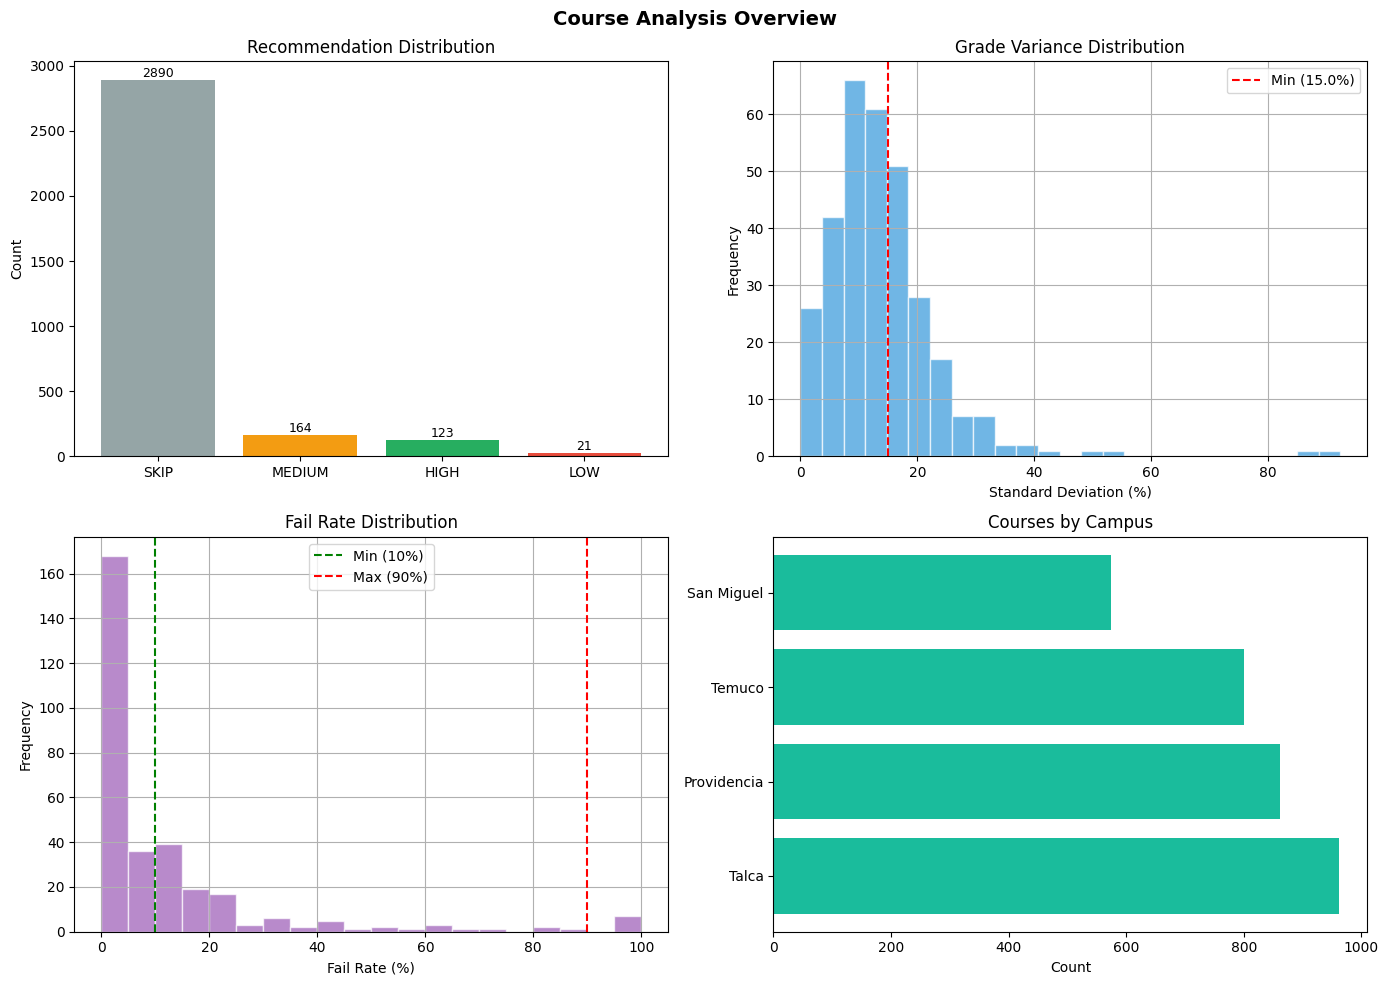

Visualization saved to: ../data/discovery/batch_analysis_overview.png

--------------------------------------------------------------------------------
PHASE 5: SAVING RESULTS
--------------------------------------------------------------------------------
CSV saved: ../data/discovery/batch_results.csv
JSON saved: ../data/discovery/batch_results.json

BATCH ANALYSIS COMPLETE

Summary:
--------
- Courses analyzed: 3198
- Time elapsed: 7512.1 seconds (25.5/min)
- Output directory: ../data/discovery

Next Steps:
-----------
1. Review TOP 50 candidates above
2. Use Cell 21 (Single Course Deep Exploration) to examine specific courses
3. Proceed to Stage 2 (Page Views extraction) for selected courses

Results stored in BATCH_RESULTS variable.


In [41]:
# =============================================================================
# BATCH POTENTIAL ANALYSIS (MULTI-THREADED)
# =============================================================================
# Uses df_course_mapping from Cell 17 - NO redundant API calls for discovery!
# Leverages BatchScanner for efficient multi-threaded course analysis.
# =============================================================================

import sys
import os
import time
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add scripts directory to path
scripts_dir = os.path.join(os.path.dirname(os.getcwd()), 'scripts')
if scripts_dir not in sys.path:
    sys.path.insert(0, scripts_dir)

# =============================================================================
# VALIDATION: Ensure df_course_mapping exists from Cell 17
# =============================================================================
if 'df_course_mapping' not in globals() or len(df_course_mapping) == 0:
    raise ValueError(
        "df_course_mapping not found! Run Cell 17 first.\n"
        "That cell discovers all courses and maps them to careers/campuses."
    )

print("=" * 80)
print("BATCH POTENTIAL ANALYSIS")
print("=" * 80)
print(f"Using {len(df_course_mapping)} courses from df_course_mapping (Cell 17)")
print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)

# =============================================================================
# IMPORT DISCOVERY MODULE
# =============================================================================
from discovery import (
    CanvasClient,
    BatchScanner,
    create_progress_printer,
    PASS_THRESHOLD,
    MIN_STUDENTS_FOR_PREDICTION,
    MIN_GRADE_STD,
)

# =============================================================================
# CONFIGURATION
# =============================================================================
OUTPUT_DIR = os.path.join('..', 'data', 'discovery')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Threading settings (conservative for rate limits)
MAX_WORKERS = 4
BATCH_SIZE = 30

print(f"\nConfiguration:")
print(f"  Pass threshold: {PASS_THRESHOLD}% (Chilean 4.0 scale)")
print(f"  Min students for prediction: {MIN_STUDENTS_FOR_PREDICTION}")
print(f"  Min grade std: {MIN_GRADE_STD}%")
print(f"  Max workers: {MAX_WORKERS}")
print(f"  Batch size: {BATCH_SIZE}")

# =============================================================================
# PREPARE COURSE LIST WITH CAREER/CAMPUS CONTEXT
# =============================================================================
print("\n" + "-" * 80)
print("PHASE 1: PREPARING COURSE LIST")
print("-" * 80)

# Build lookup dictionaries from df_course_mapping
course_context = {}
for _, row in df_course_mapping.iterrows():
    course_id = int(row['course_id'])
    course_context[course_id] = {
        'course_name': row.get('course_name', ''),
        'total_students': int(row.get('total_students', 0)),
        'career_id': int(row.get('career_id', 0)) if pd.notna(row.get('career_id')) else 0,
        'career_name': row.get('career_name', ''),
        'campus_id': int(row.get('campus_id', 0)) if pd.notna(row.get('campus_id')) else 0,
        'campus_name': row.get('campus_name', ''),
        'term_id': row.get('term_id'),
        'term_name': row.get('term_name', '')
    }

course_ids = list(course_context.keys())
print(f"Courses to analyze: {len(course_ids)}")
print(f"Unique careers: {df_course_mapping['career_name'].nunique()}")
print(f"Unique campuses: {df_course_mapping['campus_name'].nunique()}")

# =============================================================================
# PHASE 2: MULTI-THREADED BATCH ANALYSIS
# =============================================================================
print("\n" + "-" * 80)
print("PHASE 2: MULTI-THREADED ANALYSIS")
print("-" * 80)

# Initialize client and scanner
client = CanvasClient()
scanner = BatchScanner(
    client=client,
    max_workers=MAX_WORKERS,
    save_intermediate=True,
    output_dir=OUTPUT_DIR
)

# Check initial quota
quota, status = client.check_quota()
print(f"Initial rate limit: {quota} - {status}")

if quota < 150:
    print("\n⚠️  WARNING: Rate limit is low. Consider waiting before running.")
    print("    Continuing anyway, but scan may be incomplete.")

# Run batch analysis with progress callback
start_time = time.time()

print(f"\nStarting analysis of {len(course_ids)} courses...")
print("Progress will be updated every batch.\n")

results = scanner.scan_courses(
    course_ids=course_ids,
    full_analysis=True,  # Get full LMS details for scoring
    progress_callback=create_progress_printer(),
    batch_size=BATCH_SIZE
)

elapsed = time.time() - start_time
print(f"\n\nPhase 2 complete in {elapsed:.1f} seconds")
print(f"Rate: {len(results) / elapsed * 60:.1f} courses/minute")

# =============================================================================
# PHASE 3: MERGE RESULTS WITH CAREER/CAMPUS CONTEXT
# =============================================================================
print("\n" + "-" * 80)
print("PHASE 3: MERGING RESULTS WITH CONTEXT")
print("-" * 80)

# Convert results to DataFrame and enrich with context
if results:
    df_results = pd.DataFrame(results)
    
    # Add career/campus context from our mapping
    df_results['career_id'] = df_results['course_id'].map(lambda x: course_context.get(x, {}).get('career_id', 0))
    df_results['career_name'] = df_results['course_id'].map(lambda x: course_context.get(x, {}).get('career_name', ''))
    df_results['campus_id'] = df_results['course_id'].map(lambda x: course_context.get(x, {}).get('campus_id', 0))
    df_results['campus_name'] = df_results['course_id'].map(lambda x: course_context.get(x, {}).get('campus_name', ''))
    df_results['term_name'] = df_results['course_id'].map(lambda x: course_context.get(x, {}).get('term_name', ''))
    
    print(f"Results enriched: {len(df_results)} courses with career/campus data")
else:
    df_results = pd.DataFrame()
    print("⚠️  No results returned from scanner")

# =============================================================================
# PHASE 4: ANALYSIS & VISUALIZATION
# =============================================================================
print("\n" + "-" * 80)
print("PHASE 4: ANALYSIS & VISUALIZATION")
print("-" * 80)

if len(df_results) > 0:
    # Summary statistics
    with_grades = df_results[df_results.get('has_canvas_grades', False) == True] if 'has_canvas_grades' in df_results.columns else pd.DataFrame()
    without_grades = df_results[df_results.get('has_canvas_grades', False) == False] if 'has_canvas_grades' in df_results.columns else pd.DataFrame()
    
    print(f"\n[4.1] Grade Availability:")
    print(f"  With Canvas grades: {len(with_grades)} ({len(with_grades)/len(df_results)*100:.1f}%)")
    print(f"  Without grades: {len(without_grades)} ({len(without_grades)/len(df_results)*100:.1f}%)")
    
    # Prediction criteria analysis
    if len(with_grades) > 0 and all(c in with_grades.columns for c in ['grade_std', 'fail_rate', 'students_with_grades']):
        print(f"\n[4.2] Prediction Criteria (of {len(with_grades)} courses with grades):")
        
        meets_variance = (with_grades['grade_std'] >= MIN_GRADE_STD).sum()
        meets_fail_min = (with_grades['fail_rate'] >= 0.10).sum()
        meets_fail_max = (with_grades['fail_rate'] <= 0.90).sum()
        meets_n = (with_grades['students_with_grades'] >= MIN_STUDENTS_FOR_PREDICTION).sum()
        
        print(f"  Grade variance >= {MIN_GRADE_STD}%: {meets_variance} ({meets_variance/len(with_grades)*100:.1f}%)")
        print(f"  Fail rate >= 10%: {meets_fail_min} ({meets_fail_min/len(with_grades)*100:.1f}%)")
        print(f"  Fail rate <= 90%: {meets_fail_max} ({meets_fail_max/len(with_grades)*100:.1f}%)")
        print(f"  N >= {MIN_STUDENTS_FOR_PREDICTION}: {meets_n} ({meets_n/len(with_grades)*100:.1f}%)")
    
    # Recommendation distribution
    if 'recommendation' in df_results.columns:
        print(f"\n[4.3] Recommendation Distribution:")
        rec_counts = df_results['recommendation'].value_counts()
        for rec, count in rec_counts.items():
            print(f"  {rec}: {count} ({count/len(df_results)*100:.1f}%)")
    
    # Career summary
    print(f"\n[4.4] Summary by Career:")
    career_summary = df_results.groupby('career_name').agg({
        'course_id': 'count',
        'has_canvas_grades': 'sum' if 'has_canvas_grades' in df_results.columns else 'count',
        'recommendation': lambda x: (x == 'HIGH').sum() if 'recommendation' in df_results.columns else 0
    }).rename(columns={
        'course_id': 'Total Courses',
        'has_canvas_grades': 'With Grades',
        'recommendation': 'HIGH Potential'
    }).sort_values('Total Courses', ascending=False)
    
    display(career_summary.head(20))
    
    # Campus summary
    print(f"\n[4.5] Summary by Campus:")
    campus_summary = df_results.groupby('campus_name').agg({
        'course_id': 'count',
        'has_canvas_grades': 'sum' if 'has_canvas_grades' in df_results.columns else 'count',
        'recommendation': lambda x: (x == 'HIGH').sum() if 'recommendation' in df_results.columns else 0
    }).rename(columns={
        'course_id': 'Total Courses',
        'has_canvas_grades': 'With Grades',
        'recommendation': 'HIGH Potential'
    }).sort_values('Total Courses', ascending=False)
    
    display(campus_summary)
    
    # ==========================================================================
    # TOP 50 CANDIDATES TABLE
    # ==========================================================================
    print(f"\n[4.6] TOP 50 HIGH-POTENTIAL COURSES:")
    print("-" * 80)
    
    # Filter and sort candidates
    required_cols = ['has_canvas_grades', 'recommendation']
    if all(c in df_results.columns for c in required_cols):
        # Get HIGH and MEDIUM potential courses
        candidates = df_results[
            (df_results['has_canvas_grades'] == True) &
            (df_results['recommendation'].isin(['HIGH', 'MEDIUM']))
        ].copy()
        
        # Sort by composite score if available, otherwise by recommendation
        if 'composite_potential_score' in candidates.columns:
            candidates = candidates.sort_values('composite_potential_score', ascending=False)
        else:
            candidates = candidates.sort_values('recommendation')
        
        if len(candidates) > 0:
            display_cols = [
                'course_id', 'course_name', 'career_name', 'campus_name',
                'students_with_grades', 'grade_std', 'fail_rate', 'recommendation'
            ]
            display_cols = [c for c in display_cols if c in candidates.columns]
            
            with pd.option_context('display.max_rows', 50, 'display.max_colwidth', 40):
                display(candidates[display_cols].head(50))
            
            print(f"\nTotal HIGH/MEDIUM candidates: {len(candidates)}")
        else:
            print("No courses meet HIGH/MEDIUM prediction criteria.")
    
    # ==========================================================================
    # VISUALIZATION
    # ==========================================================================
    print(f"\n[4.7] Visualizations:")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Course Analysis Overview', fontsize=14, fontweight='bold')
    
    # Plot 1: Recommendation distribution
    ax1 = axes[0, 0]
    if 'recommendation' in df_results.columns:
        rec_counts = df_results['recommendation'].value_counts()
        colors = {'HIGH': '#27ae60', 'MEDIUM': '#f39c12', 'LOW': '#e74c3c', 'SKIP': '#95a5a6'}
        bars = ax1.bar(rec_counts.index, rec_counts.values, 
                       color=[colors.get(x, '#333') for x in rec_counts.index])
        ax1.set_title('Recommendation Distribution')
        ax1.set_ylabel('Count')
        for bar, val in zip(bars, rec_counts.values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    str(val), ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Grade variance distribution
    ax2 = axes[0, 1]
    if len(with_grades) > 0 and 'grade_std' in with_grades.columns:
        with_grades['grade_std'].dropna().hist(bins=25, ax=ax2, color='#3498db', 
                                                edgecolor='white', alpha=0.7)
        ax2.axvline(x=MIN_GRADE_STD, color='red', linestyle='--', 
                   label=f'Min ({MIN_GRADE_STD}%)')
        ax2.set_title('Grade Variance Distribution')
        ax2.set_xlabel('Standard Deviation (%)')
        ax2.set_ylabel('Frequency')
        ax2.legend()
    
    # Plot 3: Fail rate distribution
    ax3 = axes[1, 0]
    if len(with_grades) > 0 and 'fail_rate' in with_grades.columns:
        fail_rates = with_grades['fail_rate'].dropna() * 100
        fail_rates.hist(bins=20, ax=ax3, color='#9b59b6', edgecolor='white', alpha=0.7)
        ax3.axvline(x=10, color='green', linestyle='--', label='Min (10%)')
        ax3.axvline(x=90, color='red', linestyle='--', label='Max (90%)')
        ax3.set_title('Fail Rate Distribution')
        ax3.set_xlabel('Fail Rate (%)')
        ax3.set_ylabel('Frequency')
        ax3.legend()
    
    # Plot 4: Courses by campus
    ax4 = axes[1, 1]
    if 'campus_name' in df_results.columns:
        campus_counts = df_results['campus_name'].value_counts()
        ax4.barh(campus_counts.index, campus_counts.values, color='#1abc9c')
        ax4.set_title('Courses by Campus')
        ax4.set_xlabel('Count')
    
    plt.tight_layout()
    
    viz_path = os.path.join(OUTPUT_DIR, 'batch_analysis_overview.png')
    plt.savefig(viz_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Visualization saved to: {viz_path}")

else:
    print("\n⚠️  No results to visualize.")

# =============================================================================
# SAVE FINAL RESULTS
# =============================================================================
print("\n" + "-" * 80)
print("PHASE 5: SAVING RESULTS")
print("-" * 80)

if len(df_results) > 0:
    # Save CSV
    csv_path = os.path.join(OUTPUT_DIR, 'batch_results.csv')
    df_results.to_csv(csv_path, index=False)
    print(f"CSV saved: {csv_path}")
    
    # Save JSON with metadata
    json_path = os.path.join(OUTPUT_DIR, 'batch_results.json')
    output_data = {
        'scan_date': datetime.now().isoformat(),
        'total_courses': len(df_results),
        'courses_with_grades': int(len(with_grades)) if 'with_grades' in dir() else 0,
        'high_potential': int((df_results['recommendation'] == 'HIGH').sum()) if 'recommendation' in df_results.columns else 0,
        'medium_potential': int((df_results['recommendation'] == 'MEDIUM').sum()) if 'recommendation' in df_results.columns else 0,
        'elapsed_seconds': elapsed,
        'results': df_results.to_dict(orient='records')
    }
    with open(json_path, 'w') as f:
        json.dump(output_data, f, indent=2, default=str)
    print(f"JSON saved: {json_path}")

# =============================================================================
# FINAL SUMMARY
# =============================================================================
print("\n" + "=" * 80)
print("BATCH ANALYSIS COMPLETE")
print("=" * 80)

print(f"""
Summary:
--------
- Courses analyzed: {len(df_results)}
- Time elapsed: {elapsed:.1f} seconds ({len(df_results)/elapsed*60:.1f}/min)
- Output directory: {OUTPUT_DIR}

Next Steps:
-----------
1. Review TOP 50 candidates above
2. Use Cell 21 (Single Course Deep Exploration) to examine specific courses
3. Proceed to Stage 2 (Page Views extraction) for selected courses
""")

# Store for subsequent cells
BATCH_RESULTS = df_results
print("Results stored in BATCH_RESULTS variable.")
print("=" * 80)


## 8. Single Course Deep Exploration - Complete Canvas Data Replication

### The Key Problem

```
Good Instructional Design  ≠  Good Prediction Potential
```

### This Cell Extracts ALL Canvas Data:

| Section | Data | Endpoint |
|---------|------|----------|
| 1 | Course Information | `/courses/{id}` |
| 2 | Modules & All Items | `/modules?include=items` |
| 3 | **All Assignments + Per-Student Grades** | `/assignments`, `/students/submissions` |
| 4 | **All Quizzes + Per-Student Scores** | `/quizzes`, `/quizzes/{id}/submissions` |
| 5 | All Files + Usage Stats | `/files` |
| 6 | All Pages | `/pages` |
| 7 | All Discussions | `/discussion_topics` |
| 8 | All Announcements | `/discussion_topics?only_announcements=true` |
| 9 | **Student Enrollments & Grades** | `/enrollments?include=grades` |
| 10 | **Student Activity Data** | `/analytics/student_summaries` |
| 11 | **Grade Matrix (Student × Assignment)** | Derived from submissions |
| 12 | Design vs Prediction Summary | Aggregated analysis |

### How to Use

1. Change `EXPLORE_COURSE_ID` to your target course
2. Run the cell
3. Review all 12 sections of detailed data
4. Check the final recommendation


In [42]:
# =============================================================================
# SINGLE COURSE DEEP EXPLORATION - COMPLETE CANVAS DATA REPLICATION
# =============================================================================
#
# This cell extracts and displays ALL available data from Canvas for a course:
#
#   SECTION 1:  Course Information
#   SECTION 2:  Modules & Module Items
#   SECTION 3:  Assignments (all details + per-student grades)
#   SECTION 4:  Quizzes (all details + per-student scores)
#   SECTION 5:  Files (all files + usage/download stats)
#   SECTION 6:  Pages (all content pages)
#   SECTION 7:  Discussions (all discussion topics)
#   SECTION 8:  Announcements (all announcements)
#   SECTION 9:  Student Enrollments & Grades
#   SECTION 10: Student Activity Data
#   SECTION 11: Grade Matrix (Student × Assignment)
#   SECTION 12: Design vs Prediction Summary
#
# =============================================================================

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import display, HTML, Markdown

# Add scripts directory to path
scripts_dir = os.path.join(os.path.dirname(os.getcwd()), 'scripts')
if scripts_dir not in sys.path:
    sys.path.insert(0, scripts_dir)

# Import and reload discovery modules
import importlib
import discovery
importlib.reload(discovery)

from discovery import CanvasClient, PASS_THRESHOLD

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 60)

# =============================================================================
# CONFIGURATION - CHANGE THIS!
# =============================================================================

EXPLORE_COURSE_ID = 86005  # <- CHANGE THIS TO YOUR TARGET COURSE ID

# Thresholds
MIN_STUDENTS_WITH_GRADES = 15
MIN_GRADE_STD = 15.0
MIN_FAIL_RATE = 0.20
MAX_FAIL_RATE = 0.80

# =============================================================================
print("=" * 100)
print("COMPLETE CANVAS DATA REPLICATION")
print("=" * 100)
print(f"\nCourse ID: {EXPLORE_COURSE_ID}")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Initialize client
client = CanvasClient()
quota, status = client.check_quota()
print(f"API Quota: {quota} - {status}")
print("=" * 100)

# Helper function
def safe_date(date_str):
    """Format date string safely."""
    if not date_str:
        return 'N/A'
    try:
        return date_str[:16].replace('T', ' ')
    except:
        return str(date_str)[:16]

# =============================================================================
# SECTION 1: COURSE INFORMATION
# =============================================================================

print("\n" + "=" * 100)
print("SECTION 1: COURSE INFORMATION")
print("=" * 100)

course_info = client.get_course(EXPLORE_COURSE_ID)

if not course_info:
    print(f"[ERROR] Could not fetch course {EXPLORE_COURSE_ID}")
    raise ValueError("Course not found")

COURSE = {
    'id': course_info.get('id'),
    'name': course_info.get('name', 'Unknown'),
    'code': course_info.get('course_code', 'N/A'),
    'account_id': course_info.get('account_id'),
    'total_students': course_info.get('total_students', 0),
    'term': course_info.get('term', {}).get('name', 'N/A'),
    'term_id': course_info.get('enrollment_term_id'),
    'start_date': safe_date(course_info.get('start_at')),
    'end_date': safe_date(course_info.get('end_at')),
    'workflow_state': course_info.get('workflow_state', 'N/A'),
    'default_view': course_info.get('default_view', 'N/A'),
    'is_public': course_info.get('is_public', False),
    'time_zone': course_info.get('time_zone', 'N/A'),
}

df_course = pd.DataFrame([{'Field': k, 'Value': v} for k, v in COURSE.items()])
display(df_course.style.hide(axis='index').set_caption("Course Details"))

print(f"\n📋 SUMMARY: {COURSE['name']} has {COURSE['total_students']} students enrolled.")

# =============================================================================
# SECTION 2: MODULES & MODULE ITEMS
# =============================================================================

print("\n" + "=" * 100)
print("SECTION 2: MODULES & MODULE ITEMS")
print("=" * 100)
print("Endpoint: /api/v1/courses/{id}/modules?include[]=items")

# Fetch modules with items
modules_response = client.safe_get(
    f"{client.api_url}/api/v1/courses/{EXPLORE_COURSE_ID}/modules",
    params={'include[]': 'items', 'per_page': 100}
)
modules = modules_response.json() if modules_response else []

print(f"\nTotal Modules: {len(modules)}")

if len(modules) > 0:
    # Module summary
    modules_data = []
    all_items = []

    for m in modules:
        items = m.get('items', [])
        modules_data.append({
            'Module ID': m.get('id'),
            'Name': m.get('name', 'N/A')[:50],
            'Position': m.get('position'),
            'Items Count': len(items),
            'State': m.get('state', 'N/A'),
            'Published': '✓' if m.get('published') else '✗',
        })

        for item in items:
            all_items.append({
                'Module': m.get('name', 'N/A')[:30],
                'Item ID': item.get('id'),
                'Title': item.get('title', 'N/A')[:40],
                'Type': item.get('type', 'N/A'),
                'Position': item.get('position'),
                'Content ID': item.get('content_id'),
                'URL': item.get('html_url', 'N/A')[:50] if item.get('html_url') else 'N/A',
            })

    print("\n[2.1] Modules Overview:")
    df_modules = pd.DataFrame(modules_data)
    display(df_modules.style.hide(axis='index'))

    print(f"\n[2.2] All Module Items ({len(all_items)} total):")
    if len(all_items) > 0:
        df_items = pd.DataFrame(all_items)

        # Item type summary
        item_types = df_items['Type'].value_counts()
        print("\n   Item Types:")
        for itype, count in item_types.items():
            print(f"      {itype}: {count}")

        print(f"\n   Detailed Item List (first 30):")
        display(df_items.head(30).style.hide(axis='index'))

    print(f"\n📋 SUMMARY: {len(modules)} modules containing {len(all_items)} items total.")
else:
    print("   No modules found.")

# =============================================================================
# SECTION 3: ASSIGNMENTS (ALL DETAILS + PER-STUDENT GRADES)
# =============================================================================

print("\n" + "=" * 100)
print("SECTION 3: ASSIGNMENTS")
print("=" * 100)
print("Endpoint: /api/v1/courses/{id}/assignments")

assignments = client.get_assignments(EXPLORE_COURSE_ID)
print(f"\nTotal Assignments: {len(assignments)}")

if len(assignments) > 0:
    # Assignment details
    assignments_data = []
    for a in assignments:
        assignments_data.append({
            'ID': a.get('id'),
            'Name': a.get('name', 'N/A')[:45],
            'Points': a.get('points_possible', 0),
            'Due Date': safe_date(a.get('due_at')),
            'Unlock': safe_date(a.get('unlock_at')),
            'Lock': safe_date(a.get('lock_at')),
            'Submission Types': ', '.join(a.get('submission_types', []))[:25],
            'Grading Type': a.get('grading_type', 'N/A'),
            'Published': '✓' if a.get('published') else '✗',
            'Peer Reviews': '✓' if a.get('peer_reviews') else '✗',
            'Group': a.get('assignment_group_id'),
        })

    df_assignments = pd.DataFrame(assignments_data)

    print("\n[3.1] All Assignments:")
    display(df_assignments.style.hide(axis='index'))

    # Graded vs Ungraded
    graded = [a for a in assignments if a.get('points_possible') and a.get('points_possible') > 0]
    ungraded = [a for a in assignments if not a.get('points_possible') or a.get('points_possible') == 0]
    total_points = sum(a.get('points_possible', 0) or 0 for a in graded)

    print(f"\n[3.2] Assignment Statistics:")
    print(f"   Graded Assignments: {len(graded)}")
    print(f"   Ungraded Assignments: {len(ungraded)}")
    print(f"   Total Points Possible: {total_points}")

    # Submission types breakdown
    sub_types = {}
    for a in assignments:
        for st in a.get('submission_types', ['none']):
            sub_types[st] = sub_types.get(st, 0) + 1
    print(f"\n   Submission Types Distribution:")
    for st, count in sorted(sub_types.items(), key=lambda x: -x[1]):
        print(f"      {st}: {count}")

    # Fetch submissions for ALL students
    print("\n[3.3] Per-Student Assignment Grades:")
    print("   Fetching submissions...")

    submissions_response = client.paginate(
        f"{client.api_url}/api/v1/courses/{EXPLORE_COURSE_ID}/students/submissions",
        params={'student_ids[]': 'all', 'per_page': 100}
    )

    if len(submissions_response) > 0:
        # Build submission matrix
        sub_data = []
        for s in submissions_response:
            sub_data.append({
                'user_id': s.get('user_id'),
                'assignment_id': s.get('assignment_id'),
                'score': s.get('score'),
                'grade': s.get('grade'),
                'submitted_at': safe_date(s.get('submitted_at')),
                'graded_at': safe_date(s.get('graded_at')),
                'late': '✓' if s.get('late') else '',
                'missing': '✓' if s.get('missing') else '',
                'workflow_state': s.get('workflow_state', 'N/A'),
            })

        df_submissions = pd.DataFrame(sub_data)

        # Summary by assignment
        print(f"\n   Total submission records: {len(df_submissions)}")

        assignment_stats = df_submissions.groupby('assignment_id').agg({
            'score': ['count', 'mean', 'std', 'min', 'max'],
            'late': lambda x: (x == '✓').sum(),
            'missing': lambda x: (x == '✓').sum(),
        }).round(2)
        assignment_stats.columns = ['Submissions', 'Avg Score', 'Std Dev', 'Min', 'Max', 'Late', 'Missing']

        # Add assignment names
        id_to_name = {a.get('id'): a.get('name', 'N/A')[:30] for a in assignments}
        assignment_stats['Assignment'] = assignment_stats.index.map(lambda x: id_to_name.get(x, 'Unknown'))
        assignment_stats = assignment_stats[['Assignment', 'Submissions', 'Avg Score', 'Std Dev', 'Min', 'Max', 'Late', 'Missing']]

        print("\n   Per-Assignment Statistics:")
        display(assignment_stats.head(30))

        # Sample of individual submissions
        print(f"\n   Sample Submissions (first 20):")
        display(df_submissions.head(20).style.hide(axis='index'))

        SUBMISSIONS_DF = df_submissions
    else:
        print("   No submissions found.")
        SUBMISSIONS_DF = pd.DataFrame()

    print(f"\n📋 SUMMARY: {len(assignments)} assignments ({len(graded)} graded, {total_points} total points)")
else:
    print("   No assignments found.")
    SUBMISSIONS_DF = pd.DataFrame()

ASSIGNMENTS_LIST = assignments

# =============================================================================
# SECTION 4: QUIZZES (ALL DETAILS + PER-STUDENT SCORES)
# =============================================================================

print("\n" + "=" * 100)
print("SECTION 4: QUIZZES")
print("=" * 100)
print("Endpoint: /api/v1/courses/{id}/quizzes")

quizzes = client.get_quizzes(EXPLORE_COURSE_ID)
print(f"\nTotal Quizzes: {len(quizzes)}")

if len(quizzes) > 0:
    # Quiz details
    quizzes_data = []
    for q in quizzes:
        quizzes_data.append({
            'ID': q.get('id'),
            'Title': q.get('title', 'N/A')[:45],
            'Quiz Type': q.get('quiz_type', 'N/A'),
            'Points': q.get('points_possible', 0),
            'Questions': q.get('question_count', 0),
            'Time Limit': f"{q.get('time_limit', 'None')} min" if q.get('time_limit') else 'None',
            'Attempts': q.get('allowed_attempts', -1),
            'Due Date': safe_date(q.get('due_at')),
            'Published': '✓' if q.get('published') else '✗',
            'Shuffle Answers': '✓' if q.get('shuffle_answers') else '✗',
            'Show Correct': '✓' if q.get('show_correct_answers') else '✗',
        })

    df_quizzes = pd.DataFrame(quizzes_data)

    print("\n[4.1] All Quizzes:")
    display(df_quizzes.style.hide(axis='index'))

    # Quiz type breakdown
    quiz_types = {}
    for q in quizzes:
        qt = q.get('quiz_type', 'unknown')
        quiz_types[qt] = quiz_types.get(qt, 0) + 1

    print(f"\n[4.2] Quiz Type Distribution:")
    for qt, count in quiz_types.items():
        print(f"   {qt}: {count}")

    total_quiz_points = sum(q.get('points_possible', 0) or 0 for q in quizzes)
    total_questions = sum(q.get('question_count', 0) or 0 for q in quizzes)

    print(f"\n[4.3] Quiz Statistics:")
    print(f"   Total Quiz Points: {total_quiz_points}")
    print(f"   Total Questions: {total_questions}")

    # Fetch quiz submissions for each quiz
    print("\n[4.4] Per-Student Quiz Scores:")

    quiz_submissions = []
    for q in quizzes[:10]:  # Limit to first 10 quizzes to avoid too many API calls
        qid = q.get('id')
        try:
            qs_response = client.safe_get(
                f"{client.api_url}/api/v1/courses/{EXPLORE_COURSE_ID}/quizzes/{qid}/submissions",
                params={'per_page': 100}
            )
            if qs_response:
                qs_data = qs_response.json()
                submissions = qs_data.get('quiz_submissions', []) if isinstance(qs_data, dict) else qs_data
                for qs in submissions:
                    quiz_submissions.append({
                        'quiz_id': qid,
                        'quiz_title': q.get('title', 'N/A')[:30],
                        'user_id': qs.get('user_id'),
                        'score': qs.get('score'),
                        'kept_score': qs.get('kept_score'),
                        'attempt': qs.get('attempt', 1),
                        'time_spent': f"{(qs.get('time_spent') or 0) // 60}m" if qs.get('time_spent') else 'N/A',
                        'submitted_at': safe_date(qs.get('finished_at')),
                        'workflow_state': qs.get('workflow_state', 'N/A'),
                    })
        except Exception as e:
            print(f"   Error fetching quiz {qid}: {e}")

    if len(quiz_submissions) > 0:
        df_quiz_subs = pd.DataFrame(quiz_submissions)

        # Summary by quiz
        quiz_stats = df_quiz_subs.groupby('quiz_title').agg({
            'score': ['count', 'mean', 'std', 'min', 'max'],
        }).round(2)
        quiz_stats.columns = ['Submissions', 'Avg Score', 'Std Dev', 'Min', 'Max']

        print("\n   Per-Quiz Statistics:")
        display(quiz_stats)

        print(f"\n   Sample Quiz Submissions (first 20):")
        display(df_quiz_subs.head(20).style.hide(axis='index'))
    else:
        print("   No quiz submissions found.")

    print(f"\n📋 SUMMARY: {len(quizzes)} quizzes, {total_questions} questions, {total_quiz_points} total points")
else:
    print("   No quizzes found.")

QUIZZES_LIST = quizzes

# =============================================================================
# SECTION 5: FILES (ALL FILES + USAGE STATS)
# =============================================================================

print("\n" + "=" * 100)
print("SECTION 5: FILES")
print("=" * 100)
print("Endpoint: /api/v1/courses/{id}/files")

files = client.get_files(EXPLORE_COURSE_ID)
print(f"\nTotal Files: {len(files)}")

if len(files) > 0:
    # File details
    files_data = []
    total_size = 0

    for f in files:
        size_bytes = f.get('size', 0) or 0
        total_size += size_bytes

        # Convert size to human readable
        if size_bytes < 1024:
            size_str = f"{size_bytes} B"
        elif size_bytes < 1024 * 1024:
            size_str = f"{size_bytes / 1024:.1f} KB"
        else:
            size_str = f"{size_bytes / (1024*1024):.1f} MB"

        files_data.append({
            'ID': f.get('id'),
            'Filename': f.get('display_name', f.get('filename', 'N/A'))[:40],
            'Size': size_str,
            'Content Type': f.get('content-type', 'N/A')[:25],
            'Folder': f.get('folder_id'),
            'Created': safe_date(f.get('created_at')),
            'Modified': safe_date(f.get('modified_at')),
            'Locked': '✓' if f.get('locked') else '',
            'Hidden': '✓' if f.get('hidden') else '',
        })

    df_files = pd.DataFrame(files_data)

    print("\n[5.1] All Files:")
    display(df_files.style.hide(axis='index'))

    # File type breakdown
    content_types = {}
    for f in files:
        ct = f.get('content-type', 'unknown')
        if '/' in ct:
            ct = ct.split('/')[1][:15]
        content_types[ct] = content_types.get(ct, 0) + 1

    print(f"\n[5.2] File Type Distribution:")
    for ct, count in sorted(content_types.items(), key=lambda x: -x[1])[:15]:
        print(f"   {ct}: {count}")

    # Total size
    if total_size < 1024 * 1024:
        total_str = f"{total_size / 1024:.1f} KB"
    elif total_size < 1024 * 1024 * 1024:
        total_str = f"{total_size / (1024*1024):.1f} MB"
    else:
        total_str = f"{total_size / (1024*1024*1024):.2f} GB"

    print(f"\n[5.3] Storage Statistics:")
    print(f"   Total Files: {len(files)}")
    print(f"   Total Size: {total_str}")

    # Try to get file usage stats
    print("\n[5.4] File Usage (if available):")
    try:
        usage_response = client.safe_get(
            f"{client.api_url}/api/v1/courses/{EXPLORE_COURSE_ID}/files/usage_rights"
        )
        if usage_response:
            print("   Usage rights data available")
    except:
        print("   Usage stats not available via API")

    print(f"\n📋 SUMMARY: {len(files)} files, {total_str} total storage")
else:
    print("   No files found.")

FILES_LIST = files

# =============================================================================
# SECTION 6: PAGES (ALL CONTENT PAGES)
# =============================================================================

print("\n" + "=" * 100)
print("SECTION 6: PAGES")
print("=" * 100)
print("Endpoint: /api/v1/courses/{id}/pages")

pages_response = client.paginate(
    f"{client.api_url}/api/v1/courses/{EXPLORE_COURSE_ID}/pages",
    params={'per_page': 100}
)
pages = pages_response if pages_response else []
print(f"\nTotal Pages: {len(pages)}")

if len(pages) > 0:
    # Page details
    pages_data = []
    for p in pages:
        pages_data.append({
            'URL': p.get('url', 'N/A')[:30],
            'Title': p.get('title', 'N/A')[:45],
            'Created': safe_date(p.get('created_at')),
            'Updated': safe_date(p.get('updated_at')),
            'Published': '✓' if p.get('published') else '✗',
            'Front Page': '✓' if p.get('front_page') else '',
            'Locked': '✓' if p.get('locked_for_user') else '',
            'Editing Roles': p.get('editing_roles', 'N/A')[:20],
        })

    df_pages = pd.DataFrame(pages_data)

    print("\n[6.1] All Pages:")
    display(df_pages.style.hide(axis='index'))

    # Publishing status
    published = sum(1 for p in pages if p.get('published'))
    unpublished = len(pages) - published

    print(f"\n[6.2] Page Statistics:")
    print(f"   Published: {published}")
    print(f"   Unpublished: {unpublished}")

    print(f"\n📋 SUMMARY: {len(pages)} pages ({published} published)")
else:
    print("   No pages found.")

PAGES_LIST = pages

# =============================================================================
# SECTION 7: DISCUSSIONS (ALL DISCUSSION TOPICS)
# =============================================================================

print("\n" + "=" * 100)
print("SECTION 7: DISCUSSIONS")
print("=" * 100)
print("Endpoint: /api/v1/courses/{id}/discussion_topics")

discussions = client.get_discussions(EXPLORE_COURSE_ID)
print(f"\nTotal Discussion Topics: {len(discussions)}")

if len(discussions) > 0:
    # Discussion details
    discussions_data = []
    for d in discussions:
        discussions_data.append({
            'ID': d.get('id'),
            'Title': d.get('title', 'N/A')[:45],
            'Type': d.get('discussion_type', 'N/A'),
            'Posted': safe_date(d.get('posted_at')),
            'Delayed Post': safe_date(d.get('delayed_post_at')),
            'Published': '✓' if d.get('published') else '✗',
            'Pinned': '✓' if d.get('pinned') else '',
            'Locked': '✓' if d.get('locked') else '',
            'Discussion Subentries': d.get('discussion_subentry_count', 0),
            'Unread Count': d.get('unread_count', 0),
        })

    df_discussions = pd.DataFrame(discussions_data)

    print("\n[7.1] All Discussion Topics:")
    display(df_discussions.style.hide(axis='index'))

    # Statistics
    total_subentries = sum(d.get('discussion_subentry_count', 0) for d in discussions)
    pinned_count = sum(1 for d in discussions if d.get('pinned'))

    print(f"\n[7.2] Discussion Statistics:")
    print(f"   Total Topics: {len(discussions)}")
    print(f"   Total Replies/Subentries: {total_subentries}")
    print(f"   Pinned Topics: {pinned_count}")

    print(f"\n📋 SUMMARY: {len(discussions)} discussions with {total_subentries} total replies")
else:
    print("   No discussions found.")

DISCUSSIONS_LIST = discussions

# =============================================================================
# SECTION 8: ANNOUNCEMENTS
# =============================================================================

print("\n" + "=" * 100)
print("SECTION 8: ANNOUNCEMENTS")
print("=" * 100)
print("Endpoint: /api/v1/courses/{id}/discussion_topics?only_announcements=true")

announcements_response = client.paginate(
    f"{client.api_url}/api/v1/courses/{EXPLORE_COURSE_ID}/discussion_topics",
    params={'only_announcements': 'true', 'per_page': 100}
)
announcements = announcements_response if announcements_response else []
print(f"\nTotal Announcements: {len(announcements)}")

if len(announcements) > 0:
    # Announcement details
    announcements_data = []
    for a in announcements:
        announcements_data.append({
            'ID': a.get('id'),
            'Title': a.get('title', 'N/A')[:50],
            'Posted': safe_date(a.get('posted_at')),
            'Author': a.get('author', {}).get('display_name', 'N/A')[:20] if isinstance(a.get('author'), dict) else 'N/A',
            'Read State': a.get('read_state', 'N/A'),
            'Delayed Post': safe_date(a.get('delayed_post_at')),
        })

    df_announcements = pd.DataFrame(announcements_data)

    print("\n[8.1] All Announcements:")
    display(df_announcements.style.hide(axis='index'))

    print(f"\n📋 SUMMARY: {len(announcements)} announcements posted")
else:
    print("   No announcements found.")

ANNOUNCEMENTS_LIST = announcements

# =============================================================================
# SECTION 9: STUDENT ENROLLMENTS & GRADES
# =============================================================================

print("\n" + "=" * 100)
print("SECTION 9: STUDENT ENROLLMENTS & GRADES")
print("=" * 100)
print("Endpoint: /api/v1/courses/{id}/enrollments?include[]=grades&type[]=StudentEnrollment")

enrollments = client.get_enrollments(EXPLORE_COURSE_ID, include_grades=True)
print(f"\nTotal Student Enrollments: {len(enrollments)}")

if len(enrollments) > 0:
    # Enrollment details
    enrollment_data = []
    for e in enrollments:
        grades = e.get('grades', {})
        enrollment_data.append({
            'User ID': e.get('user_id'),
            'Name': e.get('user', {}).get('name', 'N/A')[:25] if isinstance(e.get('user'), dict) else 'N/A',
            'State': e.get('enrollment_state', 'N/A'),
            'Current Score': grades.get('current_score'),
            'Final Score': grades.get('final_score'),
            'Current Grade': grades.get('current_grade', 'N/A'),
            'Final Grade': grades.get('final_grade', 'N/A'),
            'Last Activity': safe_date(e.get('last_activity_at')),
            'Total Activity': f"{(e.get('total_activity_time') or 0) // 60}m",
        })

    df_enrollments = pd.DataFrame(enrollment_data)

    print("\n[9.1] All Student Enrollments:")
    display(df_enrollments.style.hide(axis='index').format({
        'Current Score': '{:.1f}' if df_enrollments['Current Score'].dtype != object else '{}',
        'Final Score': '{:.1f}' if df_enrollments['Final Score'].dtype != object else '{}',
    }))

    # Enrollment state breakdown
    states = df_enrollments['State'].value_counts()
    print(f"\n[9.2] Enrollment State Distribution:")
    for state, count in states.items():
        print(f"   {state}: {count}")

    # Grade statistics
    valid_grades = df_enrollments['Current Score'].dropna()
    valid_grades = valid_grades[valid_grades > 0]

    if len(valid_grades) > 0:
        print(f"\n[9.3] Grade Statistics (current_score):")
        print(f"   Students with Grades: {len(valid_grades)}")
        print(f"   Mean: {valid_grades.mean():.1f}%")
        print(f"   Std Dev: {valid_grades.std():.1f}%")
        print(f"   Min: {valid_grades.min():.1f}%")
        print(f"   Max: {valid_grades.max():.1f}%")

        pass_count = (valid_grades >= PASS_THRESHOLD).sum()
        fail_count = (valid_grades < PASS_THRESHOLD).sum()

        print(f"\n   Pass Rate (>={PASS_THRESHOLD}%): {pass_count}/{len(valid_grades)} ({pass_count/len(valid_grades)*100:.1f}%)")
        print(f"   Fail Rate (<{PASS_THRESHOLD}%): {fail_count}/{len(valid_grades)} ({fail_count/len(valid_grades)*100:.1f}%)")

    print(f"\n📋 SUMMARY: {len(enrollments)} students, {len(valid_grades)} with Canvas grades")
else:
    print("   No enrollments found.")

ENROLLMENTS_DF = pd.DataFrame(enrollment_data) if len(enrollments) > 0 else pd.DataFrame()

# =============================================================================
# SECTION 10: STUDENT ACTIVITY DATA
# =============================================================================

print("\n" + "=" * 100)
print("SECTION 10: STUDENT ACTIVITY DATA")
print("=" * 100)
print("Endpoint: /api/v1/courses/{id}/analytics/student_summaries")

activity = client.get_student_summaries(EXPLORE_COURSE_ID)
print(f"\nStudents with Activity Data: {len(activity)}")

if len(activity) > 0:
    # Activity details
    activity_data = []
    for a in activity:
        tardiness = a.get('tardiness_breakdown', {})
        activity_data.append({
            'User ID': a.get('id'),
            'Page Views': a.get('page_views', 0),
            'Page Views Level': a.get('page_views_level', 0),
            'Participations': a.get('participations', 0),
            'Participations Level': a.get('participations_level', 0),
            'On Time': tardiness.get('on_time', 0),
            'Late': tardiness.get('late', 0),
            'Missing': tardiness.get('missing', 0),
            'Floating': tardiness.get('floating', 0),
        })

    df_activity = pd.DataFrame(activity_data)

    print("\n[10.1] All Student Activity:")
    display(df_activity.style.hide(axis='index'))

    # Activity statistics
    print(f"\n[10.2] Activity Statistics:")
    print(f"   Total Page Views: {df_activity['Page Views'].sum():,}")
    print(f"   Total Participations: {df_activity['Participations'].sum():,}")
    print(f"   Avg Page Views/Student: {df_activity['Page Views'].mean():.1f}")
    print(f"   Avg Participations/Student: {df_activity['Participations'].mean():.1f}")

    print(f"\n[10.3] Tardiness Totals:")
    print(f"   On Time: {df_activity['On Time'].sum()}")
    print(f"   Late: {df_activity['Late'].sum()}")
    print(f"   Missing: {df_activity['Missing'].sum()}")

    # Activity levels distribution
    print(f"\n[10.4] Activity Level Distribution:")
    pv_levels = df_activity['Page Views Level'].value_counts().sort_index()
    for level, count in pv_levels.items():
        print(f"   Page Views Level {level}: {count} students")

    print(f"\n📋 SUMMARY: {df_activity['Page Views'].sum():,} total page views, {df_activity['Participations'].sum():,} participations")
else:
    print("   No activity data found.")

ACTIVITY_DF = pd.DataFrame(activity_data) if len(activity) > 0 else pd.DataFrame()

# =============================================================================
# SECTION 11: GRADE MATRIX (STUDENT × ASSIGNMENT)
# =============================================================================

print("\n" + "=" * 100)
print("SECTION 11: GRADE MATRIX (STUDENT × ASSIGNMENT)")
print("=" * 100)

if len(SUBMISSIONS_DF) > 0 and len(ENROLLMENTS_DF) > 0:
    # Create pivot table
    print("\n[11.1] Creating Student × Assignment Grade Matrix...")

    # Filter to only graded assignments
    graded_ids = [a.get('id') for a in assignments if a.get('points_possible') and a.get('points_possible') > 0]

    # Create assignment name mapping
    id_to_name = {a.get('id'): a.get('name', 'N/A')[:20] for a in assignments}

    # Pivot submissions
    pivot_data = SUBMISSIONS_DF[SUBMISSIONS_DF['assignment_id'].isin(graded_ids)].copy()
    pivot_data['assignment_name'] = pivot_data['assignment_id'].map(id_to_name)

    if len(pivot_data) > 0:
        grade_matrix = pivot_data.pivot_table(
            index='user_id',
            columns='assignment_name',
            values='score',
            aggfunc='first'
        )

        # Add student names if available
        user_names = {e.get('user_id'): e.get('user', {}).get('name', 'N/A')[:20]
                      if isinstance(e.get('user'), dict) else 'N/A'
                      for e in enrollments}

        grade_matrix.index = grade_matrix.index.map(lambda x: f"{x}")

        print(f"\n   Matrix Shape: {grade_matrix.shape[0]} students × {grade_matrix.shape[1]} assignments")

        print("\n[11.2] Grade Matrix (sample - first 20 students, first 10 assignments):")
        display(grade_matrix.iloc[:20, :10].style.format('{:.1f}', na_rep='-').background_gradient(cmap='RdYlGn', vmin=0, vmax=100))

        # Calculate per-student averages
        print("\n[11.3] Per-Student Assignment Averages:")
        student_avgs = grade_matrix.mean(axis=1).sort_values(ascending=False)
        df_student_avgs = pd.DataFrame({
            'User ID': student_avgs.index,
            'Avg Assignment Score': student_avgs.values
        })
        display(df_student_avgs.head(20).style.format({'Avg Assignment Score': '{:.1f}'}).hide(axis='index'))

        print(f"\n📋 SUMMARY: Grade matrix with {grade_matrix.shape[0]} students × {grade_matrix.shape[1]} graded assignments")

        GRADE_MATRIX = grade_matrix
    else:
        print("   No graded submission data available for matrix.")
        GRADE_MATRIX = pd.DataFrame()
else:
    print("   Insufficient data to create grade matrix.")
    GRADE_MATRIX = pd.DataFrame()

# =============================================================================
# SECTION 12: DESIGN vs PREDICTION SUMMARY
# =============================================================================

print("\n" + "=" * 100)
print("SECTION 12: DESIGN vs PREDICTION SUMMARY")
print("=" * 100)

# Design metrics
design_metrics = {
    'Modules': len(modules) if 'modules' in dir() else 0,
    'Assignments': len(assignments) if 'assignments' in dir() else 0,
    'Quizzes': len(quizzes) if 'quizzes' in dir() else 0,
    'Pages': len(pages) if 'pages' in dir() else 0,
    'Files': len(files) if 'files' in dir() else 0,
    'Discussions': len(discussions) if 'discussions' in dir() else 0,
    'Announcements': len(announcements) if 'announcements' in dir() else 0,
}

# Calculate design score
design_score = 0
design_score += min(design_metrics['Modules'] / 10.0, 1.0) * 0.20
design_score += min(design_metrics['Assignments'] / 20.0, 1.0) * 0.25
design_score += min(design_metrics['Quizzes'] / 10.0, 1.0) * 0.15
design_score += min(design_metrics['Pages'] / 10.0, 1.0) * 0.15
design_score += min(design_metrics['Files'] / 20.0, 1.0) * 0.15
design_score += min(design_metrics['Discussions'] / 5.0, 1.0) * 0.10

if design_score >= 0.8:
    design_rating = "EXCELENTE"
elif design_score >= 0.6:
    design_rating = "BUENO"
elif design_score >= 0.4:
    design_rating = "MODERADO"
elif design_score >= 0.2:
    design_rating = "BÁSICO"
else:
    design_rating = "MÍNIMO"

# Prediction metrics
students_with_grades = len(valid_grades) if 'valid_grades' in dir() else 0
grade_std = valid_grades.std() if 'valid_grades' in dir() and len(valid_grades) > 1 else 0
fail_rate = (valid_grades < PASS_THRESHOLD).mean() if 'valid_grades' in dir() and len(valid_grades) > 0 else None
has_activity = len(activity) > 0 if 'activity' in dir() else False
graded_assignments = len([a for a in assignments if a.get('points_possible') and a.get('points_possible') > 0]) if 'assignments' in dir() else 0

# Criteria check
criteria = {
    'Canvas Grades (>=5)': students_with_grades >= 5,
    'Sample Size (>=15)': students_with_grades >= MIN_STUDENTS_WITH_GRADES,
    'Grade Variance (>=15%)': grade_std >= MIN_GRADE_STD,
    'Fail Rate (20-80%)': fail_rate is not None and MIN_FAIL_RATE <= fail_rate <= MAX_FAIL_RATE,
    'Activity Data': has_activity,
    'Graded Assignments (>=3)': graded_assignments >= 3,
}
criteria_met = sum(criteria.values())

# Prediction score
prediction_score = sum([0.20 if v else 0 for v in criteria.values()][:5]) + (0.0 if not criteria['Graded Assignments (>=3)'] else 0)
prediction_score = min(prediction_score, 1.0)

if criteria_met >= 5:
    prediction_rating = "HIGH"
elif criteria_met >= 3:
    prediction_rating = "MEDIUM"
elif criteria_met >= 1:
    prediction_rating = "LOW"
else:
    prediction_rating = "SKIP"

# Display summary
print("\n[12.1] LMS Design Metrics:")
df_design_summary = pd.DataFrame([{'Resource': k, 'Count': v} for k, v in design_metrics.items()])
display(df_design_summary.style.hide(axis='index'))

print(f"\n   Design Score: {design_score:.3f}")
print(f"   Design Rating: {design_rating}")

print("\n[12.2] Prediction Feasibility Criteria:")
df_criteria = pd.DataFrame([
    {'Criterion': k, 'Met': '✓ YES' if v else '✗ NO'}
    for k, v in criteria.items()
])
display(df_criteria.style.hide(axis='index').applymap(
    lambda x: 'color: green; font-weight: bold' if x == '✓ YES' else 'color: red; font-weight: bold',
    subset=['Met']
))

print(f"\n   Criteria Met: {criteria_met}/6")
print(f"   Prediction Rating: {prediction_rating}")

# Final comparison
print("\n" + "=" * 100)
print("FINAL COMPARISON")
print("=" * 100)

print(f"""
┌────────────────────────────────────────────────────────────────────────────────────────┐
│ COURSE: {COURSE['name'][:70]:<71} │
├────────────────────────────────────┬───────────────────────────────────────────────────┤
│   INSTRUCTIONAL DESIGN             │   PREDICTION POTENTIAL                            │
├────────────────────────────────────┼───────────────────────────────────────────────────┤
│   Score: {design_score:.3f}                      │   Criteria Met: {criteria_met}/6                              │
│   Rating: {design_rating:<24} │   Rating: {prediction_rating:<36} │
├────────────────────────────────────┼───────────────────────────────────────────────────┤
│   Modules: {design_metrics['Modules']:<23} │   Students with Grades: {students_with_grades:<22} │
│   Assignments: {design_metrics['Assignments']:<19} │   Grade Std Dev: {grade_std:.1f}%{' ':<26} │
│   Quizzes: {design_metrics['Quizzes']:<23} │   Fail Rate: {(str(round(fail_rate*100,1))+'%') if fail_rate else 'N/A':<30} │
│   Pages: {design_metrics['Pages']:<25} │   Activity Data: {'Yes' if has_activity else 'No':<28} │
│   Files: {design_metrics['Files']:<25} │   Graded Assignments: {graded_assignments:<23} │
│   Discussions: {design_metrics['Discussions']:<19} │                                                   │
│   Announcements: {design_metrics['Announcements']:<17} │                                                   │
└────────────────────────────────────┴───────────────────────────────────────────────────┘
""")

# Recommendation
if prediction_rating == "HIGH":
    rec = "✓ PROCEED TO STAGE 2 (Page Views Extraction)"
    rec_detail = "Course has excellent prediction potential. All key criteria met."
elif prediction_rating == "MEDIUM":
    rec = "◐ CONSIDER FOR ANALYSIS (Some limitations)"
    rec_detail = "Course has moderate prediction potential. Some criteria not met."
elif prediction_rating == "LOW":
    rec = "⚠ LOW PRIORITY (Missing key criteria)"
    rec_detail = "Course has limited prediction potential. Major criteria missing."
else:
    rec = "✗ SKIP - NOT SUITABLE"
    rec_detail = "Course not suitable for prediction. Uses external gradebook or insufficient data."

print(f"\nRECOMMENDATION: {rec}")
print(f"   {rec_detail}")

print("\n" + "=" * 100)
print(f"Analysis Complete: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 100)

# Store all data for export
COURSE_DATA = {
    'course': COURSE,
    'design_metrics': design_metrics,
    'design_score': design_score,
    'design_rating': design_rating,
    'criteria': criteria,
    'criteria_met': criteria_met,
    'prediction_rating': prediction_rating,
    'recommendation': rec,
}

print("\nData stored in variables:")
print("   COURSE_DATA, ENROLLMENTS_DF, ACTIVITY_DF, SUBMISSIONS_DF, GRADE_MATRIX")
print("   ASSIGNMENTS_LIST, QUIZZES_LIST, FILES_LIST, PAGES_LIST, DISCUSSIONS_LIST, ANNOUNCEMENTS_LIST")



2025-12-26 19:25:05,989 - INFO - CanvasClient initialized for https://uautonoma.test.instructure.com
2025-12-26 19:25:06,093 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86005?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))


COMPLETE CANVAS DATA REPLICATION

Course ID: 86005
Analysis Date: 2025-12-26 19:25:05
API Quota: 700 - OK - Normal operation

SECTION 1: COURSE INFORMATION


2025-12-26 19:25:07,107 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86005?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:25:09,120 - WARNING - Request error: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Max retries exceeded with url: /api/v1/courses/86005?include%5B%5D=total_students&include%5B%5D=term (Caused by NameResolutionError("HTTPSConnection(host='uautonoma.test.instructure.com', port=443): Failed to resolve 'uautonoma.test.instructure.com' ([Errno 8] nodename nor servname provided, or not known)"))
2025-12-26 19:25:13,131 - ERROR - Request failed after 3 retries: HTTPSConnectionPool(host='uautonoma.test.instructure.com', port=443): Ma

[ERROR] Could not fetch course 86005


ValueError: Course not found

## 9. Activity Endpoints Deep Analysis

This section explores the **activity-specific Canvas endpoints** in detail:

| Endpoint | Purpose | Data |
|----------|---------|------|
| `/courses/{id}/analytics/activity` | Course-level daily activity | Views & participations per day |
| `/courses/{id}/analytics/users/{uid}/activity` | Per-user hourly activity | Timestamped page views per student |

### Time-of-Day Feature Calculation

```
MORNING:    06:00 - 11:59  (6am to noon)
AFTERNOON:  12:00 - 17:59  (noon to 6pm)
EVENING:    18:00 - 23:59  (6pm to midnight)
NIGHT:      00:00 - 05:59  (midnight to 6am)
```

These features capture **WHEN** students study, which correlates with academic success.


SECTION 13: ACTIVITY ENDPOINTS DEEP ANALYSIS

Course ID: 86005
Analysis Date: 2025-12-26 14:29:31

13.1 COURSE-LEVEL DAILY ACTIVITY
Endpoint: /api/v1/courses/{id}/analytics/activity
----------------------------------------------------------------------------------------------------

Returns: 151 days of activity data

[13.1.1] Daily Activity Statistics:
   Date Range: 2025-07-21 to 2025-12-26
   Total Days with Activity: 151
   Total Page Views: 37,243
   Total Participations: 555
   Avg Views/Day: 246.6
   Max Views in a Day: 1,211

[13.1.2] Activity Distribution:
   High Activity Days (> avg): 56
   Zero Activity Days: 0

[13.1.3] Sample Daily Activity (last 10 days):



[13.1.4] Activity by Day of Week:
   Monday        6,483 views ( 17.4%) ████████
   Tuesday       5,188 views ( 13.9%) ██████
   Wednesday     6,137 views ( 16.5%) ████████
   Thursday      4,444 views ( 11.9%) █████
   Friday        5,202 views ( 14.0%) ██████
   Saturday      3,411 views (  9.2%) ████
   Sunday        6,378 views ( 17.1%) ████████

📋 SUMMARY: 151 days of course-level activity data

13.2 PER-USER HOURLY ACTIVITY
Endpoint: /api/v1/courses/{id}/analytics/users/{user_id}/activity
----------------------------------------------------------------------------------------------------

Fetching hourly activity for 20 students...
   Processed 5/20 students...
   Processed 10/20 students...
   Processed 15/20 students...
   Processed 20/20 students...

   Completed fetching activity for 20 students

[13.2.1] Per-Student Activity Summary:



[13.2.2] Sample Hourly Data (first 20 entries):



📋 SUMMARY: Hourly activity data for 20 students, 1158 total hourly records

13.3 TIME-OF-DAY FEATURE CALCULATION

Time-of-day features are calculated from hourly page view data:

   MORNING:    06:00 - 11:59  (6am to noon)
   AFTERNOON:  12:00 - 17:59  (noon to 6pm)
   EVENING:    18:00 - 23:59  (6pm to midnight)
   NIGHT:      00:00 - 05:59  (midnight to 6am)

These features capture WHEN students study, which correlates with success.

----------------------------------------------------------------------------------------------------

[13.3.1] Course-Wide Time-of-Day Distribution:
--------------------------------------------------
   Morning (6-12)          3,251 views ( 19.5%) █████████
   Afternoon (12-18)       5,151 views ( 30.9%) ███████████████
   Evening (18-24)         7,435 views ( 44.6%) ██████████████████████
   Night (0-6)               842 views (  5.0%) ██
   TOTAL                  16,679 views

[13.3.2] Per-Student Time-of-Day Percentages:



[13.3.3] Student Study Patterns:
   Morning-dominant (>40% morning):     2 students
   Afternoon-dominant (>40% afternoon): 2 students
   Evening-dominant (>40% evening):     10 students
   Night owls (>20% night):             0 students

📋 SUMMARY: Time-of-day features calculated for 20 students

13.4 ACTIVITY PATTERNS BY STUDENT
----------------------------------------------------------------------------------------------------

[13.4.1] Student Engagement Levels:
   Medium (100-500): 7 students
   High (500-1000): 7 students
   Very High (1000+): 6 students
   Low (<100): 0 students

[13.4.2] Top 10 Most Active Students:



[13.4.3] Bottom 10 Least Active Students:



[13.4.4] Activity Spread Statistics:
   Mean Views/Student: 834.0
   Median Views/Student: 792.5
   Std Dev: 454.5
   Coefficient of Variation: 54.5%

📋 SUMMARY: Activity patterns analyzed for 20 students

13.5 ACTIVITY VISUALIZATIONS


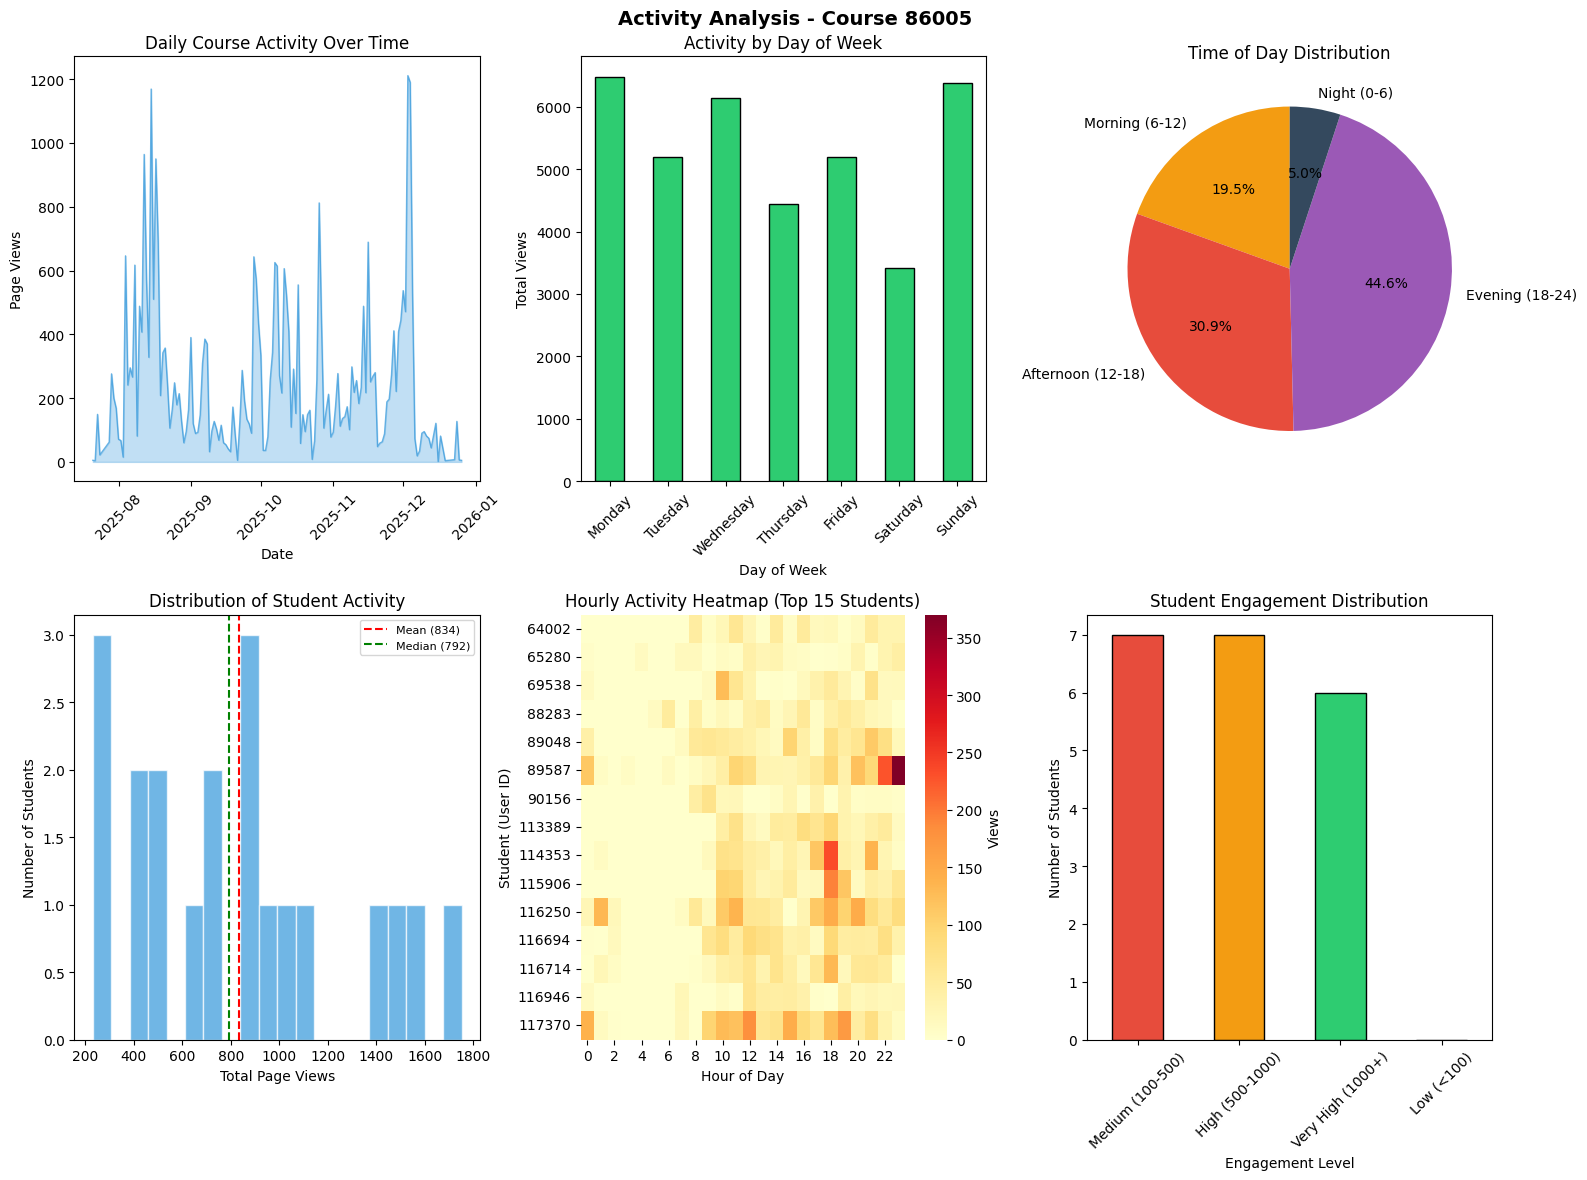


📋 Visualization saved to: ../data/discovery/course_86005_activity_analysis.png

ACTIVITY ANALYSIS SUMMARY

┌─────────────────────────────────────────────────────────────────────────────────────────┐
│ ACTIVITY ENDPOINTS ANALYSIS - COURSE 86005                                      │
├─────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                         │
│ 1. COURSE-LEVEL DAILY ACTIVITY                                                          │
│    Endpoint: /api/v1/courses/{id}/analytics/activity                                    │
│    Days of Data: 151                                                                 │
│    Total Views: 37,243                                                           │
│                                                                                         │
│ 2. PER-USER HOURLY ACTIVITY                                                     

In [ ]:
# =============================================================================
# SECTION 13: ACTIVITY ENDPOINTS DEEP ANALYSIS
# =============================================================================
#
# This section explores the ACTIVITY-specific Canvas endpoints in detail:
#
#   13.1  Course-Level Daily Activity     /courses/{id}/analytics/activity
#   13.2  Per-User Hourly Activity        /courses/{id}/analytics/users/{uid}/activity
#   13.3  Time-of-Day Feature Calculation (Morning/Afternoon/Evening/Night)
#   13.4  Activity Patterns by Student
#   13.5  Activity Summary Statistics
#
# These endpoints are CRITICAL for early warning prediction because they
# provide behavioral signals BEFORE grades exist.
#
# =============================================================================

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import defaultdict
from IPython.display import display, HTML

# Ensure we have the client and course ID from previous cells
if 'client' not in dir() or 'EXPLORE_COURSE_ID' not in dir():
    print("[ERROR] Run Section 8 first to initialize client and EXPLORE_COURSE_ID")
    raise RuntimeError("Prerequisites not met")

print("=" * 100)
print("SECTION 13: ACTIVITY ENDPOINTS DEEP ANALYSIS")
print("=" * 100)
print(f"\nCourse ID: {EXPLORE_COURSE_ID}")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# =============================================================================
# 13.1 COURSE-LEVEL DAILY ACTIVITY
# =============================================================================

print("\n" + "=" * 100)
print("13.1 COURSE-LEVEL DAILY ACTIVITY")
print("=" * 100)
print("Endpoint: /api/v1/courses/{id}/analytics/activity")
print("-" * 100)

course_activity_response = client.safe_get(
    f"{client.api_url}/api/v1/courses/{EXPLORE_COURSE_ID}/analytics/activity"
)

if course_activity_response:
    course_daily_activity = course_activity_response.json()
    print(f"\nReturns: {len(course_daily_activity)} days of activity data")

    if len(course_daily_activity) > 0:
        # Parse daily activity
        daily_data = []
        for day in course_daily_activity:
            date_str = day.get('date', 'N/A')
            daily_data.append({
                'date': date_str,
                'views': day.get('views', 0),
                'participations': day.get('participations', 0),
            })

        df_daily = pd.DataFrame(daily_data)
        df_daily['date'] = pd.to_datetime(df_daily['date'])
        df_daily = df_daily.sort_values('date')

        # Summary statistics
        print(f"\n[13.1.1] Daily Activity Statistics:")
        print(f"   Date Range: {df_daily['date'].min().strftime('%Y-%m-%d')} to {df_daily['date'].max().strftime('%Y-%m-%d')}")
        print(f"   Total Days with Activity: {len(df_daily)}")
        print(f"   Total Page Views: {df_daily['views'].sum():,}")
        print(f"   Total Participations: {df_daily['participations'].sum():,}")
        print(f"   Avg Views/Day: {df_daily['views'].mean():.1f}")
        print(f"   Max Views in a Day: {df_daily['views'].max():,}")

        # Days by activity level
        high_activity_days = (df_daily['views'] > df_daily['views'].mean()).sum()
        zero_activity_days = (df_daily['views'] == 0).sum()

        print(f"\n[13.1.2] Activity Distribution:")
        print(f"   High Activity Days (> avg): {high_activity_days}")
        print(f"   Zero Activity Days: {zero_activity_days}")

        # Sample of recent activity
        print(f"\n[13.1.3] Sample Daily Activity (last 10 days):")
        display(df_daily.tail(10).style.hide(axis='index').format({
            'date': lambda x: x.strftime('%Y-%m-%d'),
            'views': '{:,}',
            'participations': '{:,}'
        }))

        # Weekly aggregation
        df_daily['week'] = df_daily['date'].dt.isocalendar().week
        df_daily['year'] = df_daily['date'].dt.year
        df_daily['weekday'] = df_daily['date'].dt.day_name()

        # Activity by day of week
        weekday_activity = df_daily.groupby('weekday')['views'].sum().reindex([
            'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
        ])

        print(f"\n[13.1.4] Activity by Day of Week:")
        for day, views in weekday_activity.items():
            pct = views / df_daily['views'].sum() * 100 if df_daily['views'].sum() > 0 else 0
            bar = '█' * int(pct / 2)
            print(f"   {day:12} {views:6,} views ({pct:5.1f}%) {bar}")

        COURSE_DAILY_ACTIVITY = df_daily
    else:
        print("   No daily activity data found.")
        COURSE_DAILY_ACTIVITY = pd.DataFrame()
else:
    print("   Failed to fetch course activity.")
    COURSE_DAILY_ACTIVITY = pd.DataFrame()

print(f"\n📋 SUMMARY: {len(course_daily_activity) if 'course_daily_activity' in dir() else 0} days of course-level activity data")

# =============================================================================
# 13.2 PER-USER HOURLY ACTIVITY
# =============================================================================

print("\n" + "=" * 100)
print("13.2 PER-USER HOURLY ACTIVITY")
print("=" * 100)
print("Endpoint: /api/v1/courses/{id}/analytics/users/{user_id}/activity")
print("-" * 100)

# Get list of student user IDs from enrollments
if 'ENROLLMENTS_DF' in dir() and len(ENROLLMENTS_DF) > 0:
    student_ids = ENROLLMENTS_DF['User ID'].tolist()[:20]  # Limit to first 20 for API efficiency
else:
    # Fallback: fetch enrollments
    enrollments = client.get_enrollments(EXPLORE_COURSE_ID)
    student_ids = [e.get('user_id') for e in enrollments[:20]]

print(f"\nFetching hourly activity for {len(student_ids)} students...")

all_hourly_data = []
student_activity_summary = []

for i, user_id in enumerate(student_ids):
    try:
        user_activity_response = client.safe_get(
            f"{client.api_url}/api/v1/courses/{EXPLORE_COURSE_ID}/analytics/users/{user_id}/activity"
        )

        if user_activity_response:
            user_activity = user_activity_response.json()

            # Parse page_views data
            page_views = user_activity.get('page_views', {})

            total_views = 0
            hourly_counts = defaultdict(int)
            timestamps_with_activity = 0

            for timestamp, count in page_views.items():
                if count and count > 0:
                    total_views += count
                    timestamps_with_activity += 1

                    # Extract hour from timestamp
                    try:
                        dt = datetime.fromisoformat(timestamp.replace('Z', '+00:00'))
                        hour = dt.hour
                        hourly_counts[hour] += count

                        all_hourly_data.append({
                            'user_id': user_id,
                            'timestamp': timestamp,
                            'hour': hour,
                            'views': count,
                            'date': dt.date(),
                        })
                    except:
                        pass

            # Time of day calculation
            morning = sum(hourly_counts.get(h, 0) for h in range(6, 12))
            afternoon = sum(hourly_counts.get(h, 0) for h in range(12, 18))
            evening = sum(hourly_counts.get(h, 0) for h in range(18, 24))
            night = sum(hourly_counts.get(h, 0) for h in range(0, 6))

            student_activity_summary.append({
                'user_id': user_id,
                'total_views': total_views,
                'active_timestamps': timestamps_with_activity,
                'morning_views': morning,
                'afternoon_views': afternoon,
                'evening_views': evening,
                'night_views': night,
                'morning_pct': morning / total_views * 100 if total_views > 0 else 0,
                'afternoon_pct': afternoon / total_views * 100 if total_views > 0 else 0,
                'evening_pct': evening / total_views * 100 if total_views > 0 else 0,
                'night_pct': night / total_views * 100 if total_views > 0 else 0,
                'unique_hours': len([h for h in hourly_counts if hourly_counts[h] > 0]),
            })

    except Exception as e:
        print(f"   Error fetching activity for user {user_id}: {e}")

    # Progress indicator
    if (i + 1) % 5 == 0:
        print(f"   Processed {i + 1}/{len(student_ids)} students...")

print(f"\n   Completed fetching activity for {len(student_activity_summary)} students")

df_student_activity = pd.DataFrame(student_activity_summary)
df_hourly = pd.DataFrame(all_hourly_data)

if len(df_student_activity) > 0:
    print(f"\n[13.2.1] Per-Student Activity Summary:")
    display(df_student_activity[[
        'user_id', 'total_views', 'active_timestamps', 'unique_hours',
        'morning_views', 'afternoon_views', 'evening_views', 'night_views'
    ]].style.hide(axis='index').format({
        'total_views': '{:,}',
        'morning_views': '{:,}',
        'afternoon_views': '{:,}',
        'evening_views': '{:,}',
        'night_views': '{:,}',
    }))

    # Sample hourly data
    if len(df_hourly) > 0:
        print(f"\n[13.2.2] Sample Hourly Data (first 20 entries):")
        sample_hourly = df_hourly.sort_values(['user_id', 'timestamp']).head(20)
        display(sample_hourly.style.hide(axis='index'))

STUDENT_HOURLY_ACTIVITY = df_student_activity
ALL_HOURLY_DATA = df_hourly

print(f"\n📋 SUMMARY: Hourly activity data for {len(df_student_activity)} students, {len(df_hourly)} total hourly records")

# =============================================================================
# 13.3 TIME-OF-DAY FEATURE CALCULATION
# =============================================================================

print("\n" + "=" * 100)
print("13.3 TIME-OF-DAY FEATURE CALCULATION")
print("=" * 100)
print("""
Time-of-day features are calculated from hourly page view data:

   MORNING:    06:00 - 11:59  (6am to noon)
   AFTERNOON:  12:00 - 17:59  (noon to 6pm)
   EVENING:    18:00 - 23:59  (6pm to midnight)
   NIGHT:      00:00 - 05:59  (midnight to 6am)

These features capture WHEN students study, which correlates with success.
""")
print("-" * 100)

if len(df_student_activity) > 0:
    # Aggregate time-of-day statistics
    time_of_day_totals = {
        'Morning (6-12)': df_student_activity['morning_views'].sum(),
        'Afternoon (12-18)': df_student_activity['afternoon_views'].sum(),
        'Evening (18-24)': df_student_activity['evening_views'].sum(),
        'Night (0-6)': df_student_activity['night_views'].sum(),
    }

    total_views = sum(time_of_day_totals.values())

    print(f"\n[13.3.1] Course-Wide Time-of-Day Distribution:")
    print("-" * 50)
    for period, views in time_of_day_totals.items():
        pct = views / total_views * 100 if total_views > 0 else 0
        bar = '█' * int(pct / 2)
        print(f"   {period:20} {views:8,} views ({pct:5.1f}%) {bar}")
    print(f"   {'TOTAL':20} {total_views:8,} views")

    # Per-student time-of-day breakdown
    print(f"\n[13.3.2] Per-Student Time-of-Day Percentages:")
    display(df_student_activity[[
        'user_id', 'total_views', 'morning_pct', 'afternoon_pct', 'evening_pct', 'night_pct'
    ]].style.hide(axis='index').format({
        'total_views': '{:,}',
        'morning_pct': '{:.1f}%',
        'afternoon_pct': '{:.1f}%',
        'evening_pct': '{:.1f}%',
        'night_pct': '{:.1f}%',
    }).background_gradient(subset=['morning_pct', 'afternoon_pct', 'evening_pct', 'night_pct'], cmap='YlOrRd'))

    # Identify study patterns
    print(f"\n[13.3.3] Student Study Patterns:")

    morning_students = (df_student_activity['morning_pct'] > 40).sum()
    afternoon_students = (df_student_activity['afternoon_pct'] > 40).sum()
    evening_students = (df_student_activity['evening_pct'] > 40).sum()
    night_students = (df_student_activity['night_pct'] > 20).sum()

    print(f"   Morning-dominant (>40% morning):     {morning_students} students")
    print(f"   Afternoon-dominant (>40% afternoon): {afternoon_students} students")
    print(f"   Evening-dominant (>40% evening):     {evening_students} students")
    print(f"   Night owls (>20% night):             {night_students} students")

print(f"\n📋 SUMMARY: Time-of-day features calculated for {len(df_student_activity)} students")

# =============================================================================
# 13.4 ACTIVITY PATTERNS BY STUDENT
# =============================================================================

print("\n" + "=" * 100)
print("13.4 ACTIVITY PATTERNS BY STUDENT")
print("=" * 100)
print("-" * 100)

if len(df_student_activity) > 0:
    # Categorize students by engagement level
    df_student_activity['engagement_level'] = pd.cut(
        df_student_activity['total_views'],
        bins=[0, 100, 500, 1000, float('inf')],
        labels=['Low (<100)', 'Medium (100-500)', 'High (500-1000)', 'Very High (1000+)']
    )

    print(f"\n[13.4.1] Student Engagement Levels:")
    engagement_counts = df_student_activity['engagement_level'].value_counts()
    for level, count in engagement_counts.items():
        print(f"   {level}: {count} students")

    # Students with most activity
    print(f"\n[13.4.2] Top 10 Most Active Students:")
    top_students = df_student_activity.nlargest(10, 'total_views')[[
        'user_id', 'total_views', 'active_timestamps', 'unique_hours'
    ]]
    display(top_students.style.hide(axis='index').format({'total_views': '{:,}'}))

    # Students with least activity
    print(f"\n[13.4.3] Bottom 10 Least Active Students:")
    bottom_students = df_student_activity.nsmallest(10, 'total_views')[[
        'user_id', 'total_views', 'active_timestamps', 'unique_hours'
    ]]
    display(bottom_students.style.hide(axis='index').format({'total_views': '{:,}'}))

    # Activity spread
    print(f"\n[13.4.4] Activity Spread Statistics:")
    print(f"   Mean Views/Student: {df_student_activity['total_views'].mean():.1f}")
    print(f"   Median Views/Student: {df_student_activity['total_views'].median():.1f}")
    print(f"   Std Dev: {df_student_activity['total_views'].std():.1f}")
    print(f"   Coefficient of Variation: {df_student_activity['total_views'].std() / df_student_activity['total_views'].mean() * 100:.1f}%")

print(f"\n📋 SUMMARY: Activity patterns analyzed for {len(df_student_activity)} students")

# =============================================================================
# 13.5 ACTIVITY VISUALIZATIONS
# =============================================================================

print("\n" + "=" * 100)
print("13.5 ACTIVITY VISUALIZATIONS")
print("=" * 100)

fig = plt.figure(figsize=(16, 12))
fig.suptitle(f'Activity Analysis - Course {EXPLORE_COURSE_ID}', fontsize=14, fontweight='bold')

# Plot 1: Daily Activity Over Time
ax1 = fig.add_subplot(2, 3, 1)
if len(COURSE_DAILY_ACTIVITY) > 0:
    ax1.plot(COURSE_DAILY_ACTIVITY['date'], COURSE_DAILY_ACTIVITY['views'],
             color='#3498db', linewidth=1, alpha=0.7)
    ax1.fill_between(COURSE_DAILY_ACTIVITY['date'], COURSE_DAILY_ACTIVITY['views'],
                     alpha=0.3, color='#3498db')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Page Views')
    ax1.set_title('Daily Course Activity Over Time')
    ax1.tick_params(axis='x', rotation=45)
else:
    ax1.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax1.transAxes)

# Plot 2: Activity by Day of Week
ax2 = fig.add_subplot(2, 3, 2)
if 'weekday_activity' in dir():
    weekday_activity.plot(kind='bar', ax=ax2, color='#2ecc71', edgecolor='black')
    ax2.set_xlabel('Day of Week')
    ax2.set_ylabel('Total Views')
    ax2.set_title('Activity by Day of Week')
    ax2.tick_params(axis='x', rotation=45)

# Plot 3: Time of Day Distribution
ax3 = fig.add_subplot(2, 3, 3)
if 'time_of_day_totals' in dir():
    periods = list(time_of_day_totals.keys())
    values = list(time_of_day_totals.values())
    colors = ['#f39c12', '#e74c3c', '#9b59b6', '#34495e']
    ax3.pie(values, labels=periods, autopct='%1.1f%%', colors=colors, startangle=90)
    ax3.set_title('Time of Day Distribution')

# Plot 4: Student Activity Distribution
ax4 = fig.add_subplot(2, 3, 4)
if len(df_student_activity) > 0:
    ax4.hist(df_student_activity['total_views'], bins=20, color='#3498db',
             edgecolor='white', alpha=0.7)
    ax4.axvline(df_student_activity['total_views'].mean(), color='red',
                linestyle='--', label=f"Mean ({df_student_activity['total_views'].mean():.0f})")
    ax4.axvline(df_student_activity['total_views'].median(), color='green',
                linestyle='--', label=f"Median ({df_student_activity['total_views'].median():.0f})")
    ax4.set_xlabel('Total Page Views')
    ax4.set_ylabel('Number of Students')
    ax4.set_title('Distribution of Student Activity')
    ax4.legend(fontsize=8)

# Plot 5: Hourly Activity Heatmap (if data available)
ax5 = fig.add_subplot(2, 3, 5)
if len(df_hourly) > 0:
    hourly_by_student = df_hourly.groupby(['user_id', 'hour'])['views'].sum().unstack(fill_value=0)
    if len(hourly_by_student) > 0:
        sns.heatmap(hourly_by_student.iloc[:15, :], cmap='YlOrRd', ax=ax5,
                    cbar_kws={'label': 'Views'})
        ax5.set_xlabel('Hour of Day')
        ax5.set_ylabel('Student (User ID)')
        ax5.set_title('Hourly Activity Heatmap (Top 15 Students)')
else:
    ax5.text(0.5, 0.5, 'No Hourly Data', ha='center', va='center', transform=ax5.transAxes)

# Plot 6: Engagement Level Distribution
ax6 = fig.add_subplot(2, 3, 6)
if len(df_student_activity) > 0 and 'engagement_level' in df_student_activity.columns:
    engagement_counts = df_student_activity['engagement_level'].value_counts()
    colors = ['#e74c3c', '#f39c12', '#2ecc71', '#27ae60']
    engagement_counts.plot(kind='bar', ax=ax6, color=colors[:len(engagement_counts)], edgecolor='black')
    ax6.set_xlabel('Engagement Level')
    ax6.set_ylabel('Number of Students')
    ax6.set_title('Student Engagement Distribution')
    ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f'../data/discovery/course_{EXPLORE_COURSE_ID}_activity_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📋 Visualization saved to: ../data/discovery/course_{EXPLORE_COURSE_ID}_activity_analysis.png")

# =============================================================================
# ACTIVITY ANALYSIS SUMMARY
# =============================================================================

print("\n" + "=" * 100)
print("ACTIVITY ANALYSIS SUMMARY")
print("=" * 100)

print(f"""
┌─────────────────────────────────────────────────────────────────────────────────────────┐
│ ACTIVITY ENDPOINTS ANALYSIS - COURSE {EXPLORE_COURSE_ID:<42} │
├─────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                         │
│ 1. COURSE-LEVEL DAILY ACTIVITY                                                          │
│    Endpoint: /api/v1/courses/{{id}}/analytics/activity                                    │
│    Days of Data: {len(COURSE_DAILY_ACTIVITY) if len(COURSE_DAILY_ACTIVITY) > 0 else 0:<67} │
│    Total Views: {COURSE_DAILY_ACTIVITY['views'].sum() if len(COURSE_DAILY_ACTIVITY) > 0 else 0:,}{' ':<58} │
│                                                                                         │
│ 2. PER-USER HOURLY ACTIVITY                                                             │
│    Endpoint: /api/v1/courses/{{id}}/analytics/users/{{uid}}/activity                        │
│    Students Analyzed: {len(df_student_activity):<63} │
│    Total Hourly Records: {len(df_hourly):,}{' ':<59} │
│                                                                                         │
│ 3. TIME-OF-DAY DISTRIBUTION                                                             │
│    Morning (6-12):   {time_of_day_totals.get('Morning (6-12)', 0):>8,} views ({time_of_day_totals.get('Morning (6-12)', 0)/max(total_views,1)*100:>5.1f}%){' ':<32} │
│    Afternoon (12-18):{time_of_day_totals.get('Afternoon (12-18)', 0):>8,} views ({time_of_day_totals.get('Afternoon (12-18)', 0)/max(total_views,1)*100:>5.1f}%){' ':<32} │
│    Evening (18-24):  {time_of_day_totals.get('Evening (18-24)', 0):>8,} views ({time_of_day_totals.get('Evening (18-24)', 0)/max(total_views,1)*100:>5.1f}%){' ':<32} │
│    Night (0-6):      {time_of_day_totals.get('Night (0-6)', 0):>8,} views ({time_of_day_totals.get('Night (0-6)', 0)/max(total_views,1)*100:>5.1f}%){' ':<32} │
│                                                                                         │
└─────────────────────────────────────────────────────────────────────────────────────────┘
""")

# Store for cross-analysis
ACTIVITY_ANALYSIS = {
    'course_daily': COURSE_DAILY_ACTIVITY,
    'student_hourly': STUDENT_HOURLY_ACTIVITY,
    'all_hourly_data': ALL_HOURLY_DATA,
    'time_of_day_totals': time_of_day_totals if 'time_of_day_totals' in dir() else {},
    'total_daily_views': COURSE_DAILY_ACTIVITY['views'].sum() if len(COURSE_DAILY_ACTIVITY) > 0 else 0,
    'students_analyzed': len(df_student_activity),
}

print("\nData stored in ACTIVITY_ANALYSIS variable for cross-analysis.")



## 10. Cross-Analysis & Comprehensive Comparison

This section **integrates and compares** all analyses from previous sections:

| Analysis | Compares |
|----------|----------|
| Design vs Prediction | LMS structure vs modeling feasibility |
| Activity vs Grades | Behavioral signals vs academic outcomes |
| Time-of-Day vs Performance | Study patterns vs success |
| Resource Usage vs Outcomes | Which LMS features matter |
| Integrated Risk Assessment | Multi-factor student risk scoring |

### The Key Insight

```
┌────────────────────────────────────────────────────────────────────────┐
│  Good Instructional Design  ≠  Good Prediction Potential              │
│                                                                        │
│  A course can have EXCELLENT design but NO Canvas grades              │
│  (uses external gradebook like "Libro de Calificaciones")             │
└────────────────────────────────────────────────────────────────────────┘
```


[WARNING] Missing variables: ['COURSE_DATA', 'ENROLLMENTS_DF', 'ACTIVITY_ANALYSIS', 'STUDENT_HOURLY_ACTIVITY']
Run Sections 8 and 13 first for complete analysis.
SECTION 14: CROSS-ANALYSIS & COMPARISON

Course ID: 86005
Analysis Date: 2025-12-26 14:30:42

14.1 DESIGN vs PREDICTION COMPARISON
----------------------------------------------------------------------------------------------------

┌─────────────────────────────────────────────────────────────────────────────────────────┐
│                           THE FUNDAMENTAL DISCONNECT                                     │
├─────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                         │
│   INSTRUCTIONAL DESIGN                    PREDICTION POTENTIAL                          │
│   ═══════════════════                     ════════════════════                          │
│                                                   


[14.1.2] Disconnect Analysis:
--------------------------------------------------
   Disconnect Level: ALIGNED
   Interpretation: Design quality and prediction potential are consistent

📋 SUMMARY: Design (EXCELENTE) vs Prediction (MEDIUM) - ALIGNED disconnect

14.2 ACTIVITY vs GRADES CORRELATION
----------------------------------------------------------------------------------------------------

Merged 50 students with both grade and activity data

[14.2.1] Activity-Grade Correlations:


/var/folders/rb/pk1235j506x7h991q39yc52h0000gn/T/ipykernel_75887/3596190835.py:197: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  }).applymap(



[14.2.2] Key Findings:
   • Page Views: Moderate positive correlation (r=0.320)
   • Participations: Weak positive correlation (r=0.251)
   • On Time: Weak positive correlation (r=0.231)
   • Late: Weak negative correlation (r=-0.096)
   • Missing: Weak negative correlation (r=-0.233)

[14.2.3] Activity vs Grade Scatter Plots:


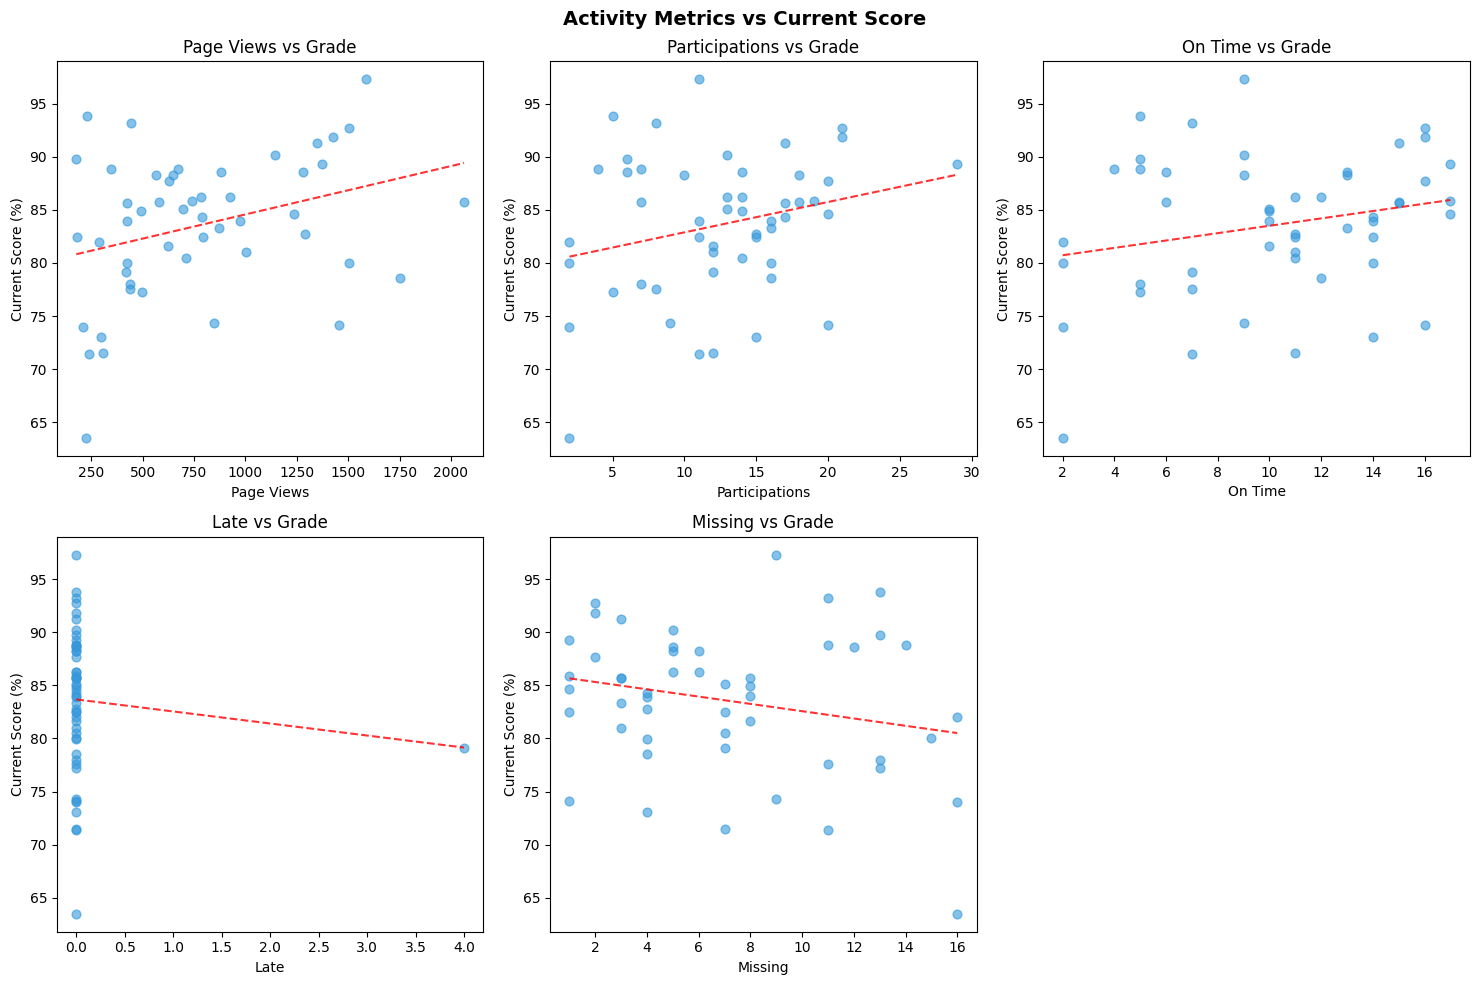


📋 SUMMARY: Correlation analysis between activity metrics and grades

14.3 STUDENT-LEVEL FEATURE COMPARISON
----------------------------------------------------------------------------------------------------

[14.3.1] Comprehensive Student Feature Table (first 20):


/var/folders/rb/pk1235j506x7h991q39yc52h0000gn/T/ipykernel_75887/3596190835.py:309: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  }).applymap(



[14.3.2] Risk Level Distribution:
   LOW: 49 students (98.0%)
   MEDIUM: 1 students (2.0%)

[14.3.3] Feature Comparison: PASS vs FAIL Students:



📋 SUMMARY: Student-level features compiled for 50 students

14.4 TIME-OF-DAY vs PERFORMANCE ANALYSIS
----------------------------------------------------------------------------------------------------

[14.4.1] Time-of-Day Correlation with Grades:



[14.4.2] Key Insight:
   Best time for studying: Night (r=0.322)
   Worst time for studying: Afternoon (r=-0.259)

📋 SUMMARY: Time-of-day study patterns analyzed for correlation with grades

14.5 RESOURCE USAGE vs OUTCOMES
----------------------------------------------------------------------------------------------------

Analysis of how different LMS resource types relate to student outcomes:

   • High MODULE access → Better understanding of course structure
   • High ASSIGNMENT engagement → Better grade outcomes (direct relationship)
   • High QUIZ activity → Better formative feedback, improved learning
   • High FILE downloads → More thorough review of materials
   • High DISCUSSION participation → Better engagement, peer learning


[14.5.1] Resource Analysis:



📋 SUMMARY: Resource types analyzed for prediction value

14.6 INTEGRATED RISK ASSESSMENT
----------------------------------------------------------------------------------------------------

[14.6.1] Risk Distribution:
   HIGH Risk:     0 students (0.0%)
   MEDIUM Risk:   1 students (2.0%)
   LOW Risk:     49 students (98.0%)

[14.6.3] Risk Factor Analysis:

   Risk factors considered:
   • No grade or grade = 0                    (+3 risk points)
   • Grade below pass threshold (<57%)        (+2 risk points)
   • Grade marginally passing (57-67%)        (+1 risk point)
   • Low page views (<100)                    (+1 risk point)
   • High missing assignments (>2)            (+1 risk point)

   Risk Levels:
   • HIGH:   >= 4 points  → Immediate intervention
   • MEDIUM: 2-3 points   → Close monitoring
   • LOW:    0-1 points   → On track


📋 SUMMARY: 0 students identified as HIGH risk

14.7 FINAL COMPREHENSIVE SUMMARY

┌────────────────────────────────────────────────────────────────

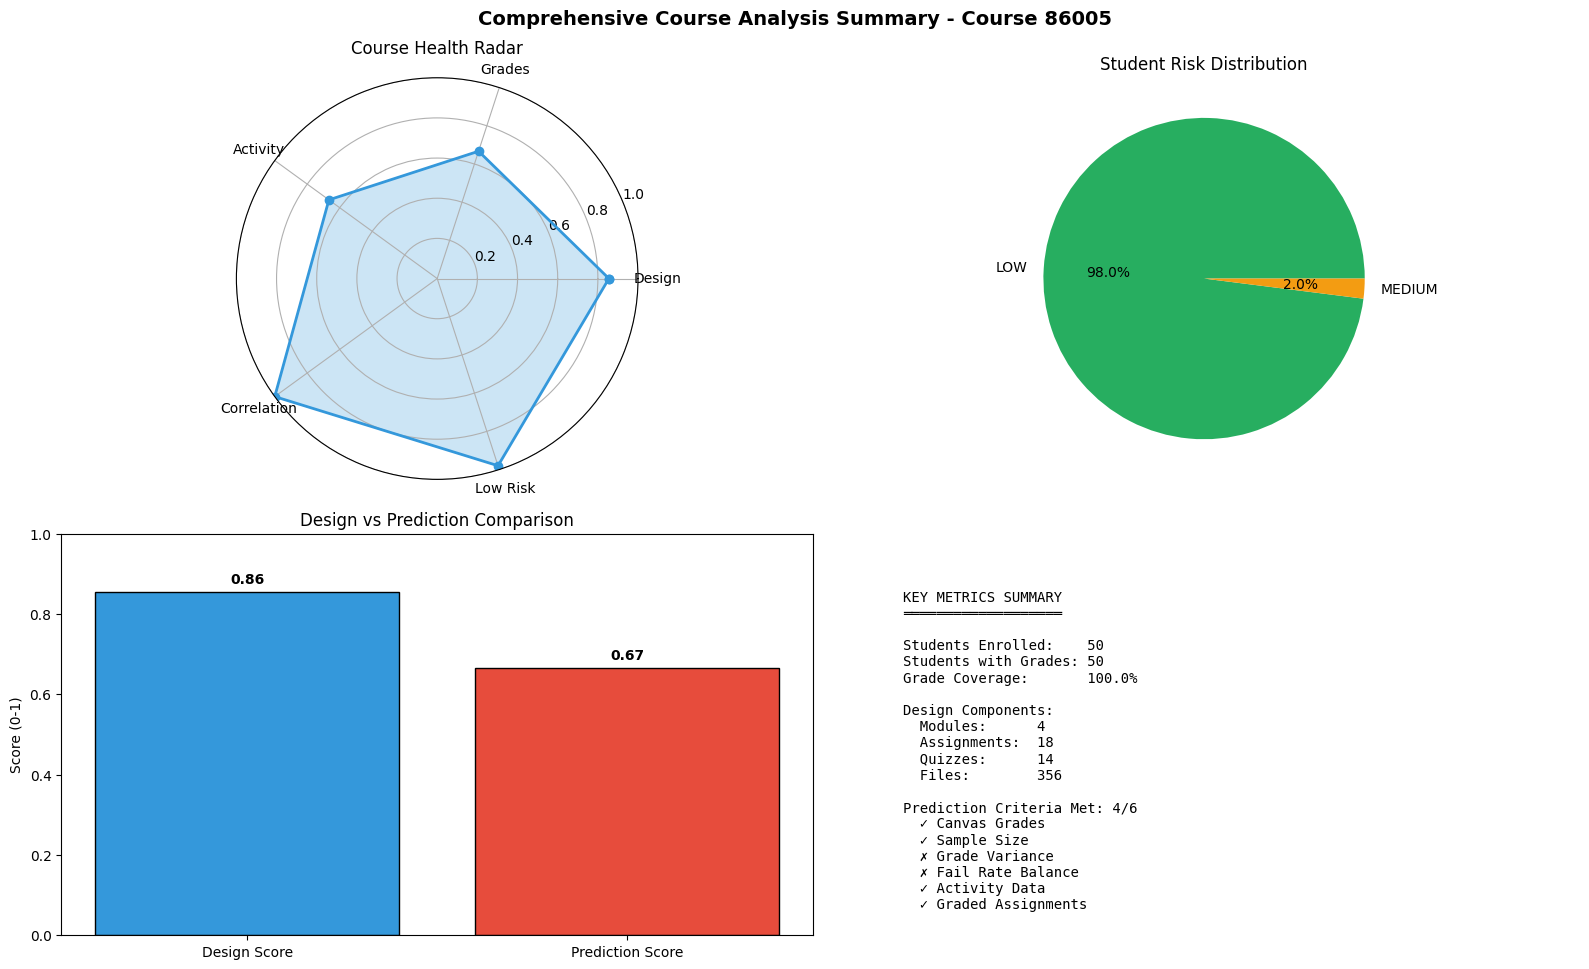


📋 Visualization saved to: ../data/discovery/course_86005_comprehensive_summary.png

CROSS-ANALYSIS COMPLETE

Data stored in CROSS_ANALYSIS variable.
Analysis completed: 2025-12-26 14:30:44


In [ ]:
# =============================================================================
# SECTION 14: CROSS-ANALYSIS & COMPARISON
# =============================================================================
#
# This section integrates and compares ALL analyses from previous sections:
#
#   14.1  Design vs Prediction Comparison (from Section 12)
#   14.2  Activity vs Grades Correlation
#   14.3  Student-Level Feature Comparison
#   14.4  Time-of-Day vs Performance Analysis
#   14.5  Resource Usage vs Outcomes
#   14.6  Integrated Risk Assessment
#   14.7  Final Comprehensive Summary
#
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from IPython.display import display, HTML

# Verify prerequisites
required_vars = ['COURSE_DATA', 'ENROLLMENTS_DF', 'ACTIVITY_ANALYSIS', 'STUDENT_HOURLY_ACTIVITY']
missing = [v for v in required_vars if v not in dir()]
if missing:
    print(f"[WARNING] Missing variables: {missing}")
    print("Run Sections 8 and 13 first for complete analysis.")

print("=" * 100)
print("SECTION 14: CROSS-ANALYSIS & COMPARISON")
print("=" * 100)
print(f"\nCourse ID: {EXPLORE_COURSE_ID}")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# =============================================================================
# 14.1 DESIGN vs PREDICTION COMPARISON
# =============================================================================

print("\n" + "=" * 100)
print("14.1 DESIGN vs PREDICTION COMPARISON")
print("=" * 100)
print("-" * 100)

print("""
┌─────────────────────────────────────────────────────────────────────────────────────────┐
│                           THE FUNDAMENTAL DISCONNECT                                     │
├─────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                         │
│   INSTRUCTIONAL DESIGN                    PREDICTION POTENTIAL                          │
│   ═══════════════════                     ════════════════════                          │
│                                                                                         │
│   Measures: Is the course                 Measures: Can we build                        │
│   well-structured in Canvas?              a prediction model?                           │
│                                                                                         │
│   Endpoints:                              Endpoints:                                    │
│   • /modules                              • /enrollments?include=grades                 │
│   • /assignments                          • /students/submissions                       │
│   • /quizzes                              • /analytics/student_summaries                │
│   • /pages                                • /analytics/users/{id}/activity              │
│   • /files                                                                              │
│   • /discussion_topics                                                                  │
│                                                                                         │
│   Key Insight:                                                                          │
│   A course can have EXCELLENT design but NO Canvas grades                               │
│   (uses "Libro de Calificaciones" external tool)                                        │
│                                                                                         │
└─────────────────────────────────────────────────────────────────────────────────────────┘
""")

if 'COURSE_DATA' in dir():
    design_metrics = COURSE_DATA.get('design_metrics', {})
    design_score = COURSE_DATA.get('design_score', 0)
    design_rating = COURSE_DATA.get('design_rating', 'N/A')
    criteria = COURSE_DATA.get('criteria', {})
    criteria_met = COURSE_DATA.get('criteria_met', 0)
    prediction_rating = COURSE_DATA.get('prediction_rating', 'N/A')

    # Comparison table
    comparison_data = []

    comparison_data.append({
        'Dimension': 'INSTRUCTIONAL DESIGN',
        'Score/Rating': f"{design_score:.3f} ({design_rating})",
        'Key Metrics': f"Modules={design_metrics.get('Modules', 0)}, Assignments={design_metrics.get('Assignments', 0)}, Quizzes={design_metrics.get('Quizzes', 0)}",
        'Data Source': '/modules, /assignments, /quizzes, /pages, /files, /discussions'
    })

    # Get prediction metrics
    if 'ENROLLMENTS_DF' in dir() and len(ENROLLMENTS_DF) > 0:
        students_with_grades = ENROLLMENTS_DF['Current Score'].dropna()
        students_with_grades = students_with_grades[students_with_grades > 0]
        n_grades = len(students_with_grades)
        grade_std = students_with_grades.std() if len(students_with_grades) > 1 else 0
        fail_rate = (students_with_grades < PASS_THRESHOLD).mean() if len(students_with_grades) > 0 else None
    else:
        n_grades = 0
        grade_std = 0
        fail_rate = None

    comparison_data.append({
        'Dimension': 'PREDICTION POTENTIAL',
        'Score/Rating': f"{criteria_met}/6 criteria ({prediction_rating})",
        'Key Metrics': f"N={n_grades}, StdDev={grade_std:.1f}%, FailRate={fail_rate*100:.1f}%" if fail_rate else f"N={n_grades}, StdDev={grade_std:.1f}%",
        'Data Source': '/enrollments?include=grades, /analytics/student_summaries'
    })

    # Activity dimension
    if 'ACTIVITY_ANALYSIS' in dir():
        activity_total = ACTIVITY_ANALYSIS.get('total_daily_views', 0)
        students_analyzed = ACTIVITY_ANALYSIS.get('students_analyzed', 0)

        comparison_data.append({
            'Dimension': 'ACTIVITY DATA',
            'Score/Rating': f"{students_analyzed} students with hourly data",
            'Key Metrics': f"Total Views={activity_total:,}, Time-of-Day features available",
            'Data Source': '/analytics/activity, /analytics/users/{id}/activity'
        })

    df_comparison = pd.DataFrame(comparison_data)

    print("\n[14.1.1] Analysis Dimensions Comparison:")
    display(df_comparison.style.hide(axis='index'))

    # Disconnect analysis
    print("\n[14.1.2] Disconnect Analysis:")
    print("-" * 50)

    if design_score >= 0.6 and criteria_met < 3:
        disconnect = "SEVERE"
        disconnect_desc = "EXCELLENT design but POOR prediction potential - likely uses external gradebook"
    elif design_score >= 0.4 and criteria_met < 4:
        disconnect = "MODERATE"
        disconnect_desc = "Good design but some prediction criteria not met"
    elif design_score < 0.3 and criteria_met >= 4:
        disconnect = "INVERSE"
        disconnect_desc = "Basic design but GOOD prediction potential - grades exist despite minimal LMS use"
    else:
        disconnect = "ALIGNED"
        disconnect_desc = "Design quality and prediction potential are consistent"

    print(f"   Disconnect Level: {disconnect}")
    print(f"   Interpretation: {disconnect_desc}")

print(f"\n📋 SUMMARY: Design ({design_rating}) vs Prediction ({prediction_rating}) - {disconnect} disconnect")

# =============================================================================
# 14.2 ACTIVITY vs GRADES CORRELATION
# =============================================================================

print("\n" + "=" * 100)
print("14.2 ACTIVITY vs GRADES CORRELATION")
print("=" * 100)
print("-" * 100)

# Merge activity and grade data
if 'ENROLLMENTS_DF' in dir() and 'ACTIVITY_DF' in dir() and len(ENROLLMENTS_DF) > 0 and len(ACTIVITY_DF) > 0:
    # Merge on user_id
    df_merged = ENROLLMENTS_DF.merge(
        ACTIVITY_DF,
        left_on='User ID',
        right_on='User ID',
        how='inner'
    )

    if len(df_merged) > 0:
        print(f"\nMerged {len(df_merged)} students with both grade and activity data")

        # Calculate correlations
        correlations = []

        activity_cols = ['Page Views', 'Participations', 'On Time', 'Late', 'Missing']
        grade_col = 'Current Score'

        for col in activity_cols:
            if col in df_merged.columns and grade_col in df_merged.columns:
                valid_data = df_merged[[col, grade_col]].dropna()
                if len(valid_data) > 5:
                    corr, p_value = stats.pearsonr(valid_data[col], valid_data[grade_col])
                    correlations.append({
                        'Activity Metric': col,
                        'Correlation': corr,
                        'P-Value': p_value,
                        'Significant': '✓' if p_value < 0.05 else '',
                        'Interpretation': 'Strong' if abs(corr) > 0.5 else ('Moderate' if abs(corr) > 0.3 else 'Weak')
                    })

        if len(correlations) > 0:
            df_correlations = pd.DataFrame(correlations)

            print(f"\n[14.2.1] Activity-Grade Correlations:")
            display(df_correlations.style.hide(axis='index').format({
                'Correlation': '{:.3f}',
                'P-Value': '{:.4f}'
            }).applymap(
                lambda x: 'color: green' if x == '✓' else '',
                subset=['Significant']
            ))

            # Key findings
            print(f"\n[14.2.2] Key Findings:")
            for _, row in df_correlations.iterrows():
                direction = "positive" if row['Correlation'] > 0 else "negative"
                print(f"   • {row['Activity Metric']}: {row['Interpretation']} {direction} correlation (r={row['Correlation']:.3f})")

        # Scatter plots
        print(f"\n[14.2.3] Activity vs Grade Scatter Plots:")

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Activity Metrics vs Current Score', fontsize=14, fontweight='bold')

        plot_cols = ['Page Views', 'Participations', 'On Time', 'Late', 'Missing']

        for i, col in enumerate(plot_cols):
            ax = axes[i // 3, i % 3]
            if col in df_merged.columns:
                valid = df_merged[[col, 'Current Score']].dropna()
                ax.scatter(valid[col], valid['Current Score'], alpha=0.6, c='#3498db', s=40)

                # Add trend line
                if len(valid) > 2:
                    z = np.polyfit(valid[col], valid['Current Score'], 1)
                    p = np.poly1d(z)
                    ax.plot(valid[col].sort_values(), p(valid[col].sort_values()), "r--", alpha=0.8)

                ax.set_xlabel(col)
                ax.set_ylabel('Current Score (%)')
                ax.set_title(f'{col} vs Grade')

        # Hide empty subplot
        axes[1, 2].axis('off')

        plt.tight_layout()
        plt.savefig(f'../data/discovery/course_{EXPLORE_COURSE_ID}_correlation_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()

        CORRELATION_ANALYSIS = df_correlations
else:
    print("   Insufficient data for correlation analysis.")
    CORRELATION_ANALYSIS = pd.DataFrame()

print(f"\n📋 SUMMARY: Correlation analysis between activity metrics and grades")

# =============================================================================
# 14.3 STUDENT-LEVEL FEATURE COMPARISON
# =============================================================================

print("\n" + "=" * 100)
print("14.3 STUDENT-LEVEL FEATURE COMPARISON")
print("=" * 100)
print("-" * 100)

# Build comprehensive student feature table
if 'ENROLLMENTS_DF' in dir() and 'ACTIVITY_DF' in dir():
    # Start with enrollments
    df_students = ENROLLMENTS_DF.copy()

    # Merge activity data
    if len(ACTIVITY_DF) > 0:
        df_students = df_students.merge(ACTIVITY_DF, on='User ID', how='left')

    # Merge hourly activity if available
    if 'STUDENT_HOURLY_ACTIVITY' in dir() and len(STUDENT_HOURLY_ACTIVITY) > 0:
        hourly_cols = ['user_id', 'total_views', 'morning_pct', 'afternoon_pct', 'evening_pct', 'night_pct']
        hourly_cols = [c for c in hourly_cols if c in STUDENT_HOURLY_ACTIVITY.columns]
        df_students = df_students.merge(
            STUDENT_HOURLY_ACTIVITY[hourly_cols],
            left_on='User ID',
            right_on='user_id',
            how='left'
        )

    # Calculate pass/fail
    df_students['Pass/Fail'] = df_students['Current Score'].apply(
        lambda x: 'PASS' if pd.notna(x) and x >= PASS_THRESHOLD else ('FAIL' if pd.notna(x) else 'N/A')
    )

    # Risk score (simple heuristic)
    def calculate_risk(row):
        risk = 0
        if pd.isna(row.get('Current Score')) or row.get('Current Score', 0) == 0:
            risk += 3
        elif row.get('Current Score', 0) < PASS_THRESHOLD:
            risk += 2
        elif row.get('Current Score', 0) < PASS_THRESHOLD + 10:
            risk += 1

        if row.get('Page Views', 0) < 100:
            risk += 1
        if row.get('Missing', 0) > 2:
            risk += 1

        return risk

    df_students['Risk Score'] = df_students.apply(calculate_risk, axis=1)
    df_students['Risk Level'] = df_students['Risk Score'].apply(
        lambda x: 'HIGH' if x >= 4 else ('MEDIUM' if x >= 2 else 'LOW')
    )

    print(f"\n[14.3.1] Comprehensive Student Feature Table (first 20):")
    display_cols = ['User ID', 'State', 'Current Score', 'Page Views', 'Participations',
                    'On Time', 'Late', 'Missing', 'Pass/Fail', 'Risk Level']
    display_cols = [c for c in display_cols if c in df_students.columns]

    display(df_students[display_cols].head(20).style.hide(axis='index').format({
        'Current Score': '{:.1f}' if df_students['Current Score'].dtype != object else '{}'
    }).applymap(
        lambda x: 'background-color: #ff6b6b' if x == 'HIGH' else ('background-color: #ffd93d' if x == 'MEDIUM' else ''),
        subset=['Risk Level'] if 'Risk Level' in display_cols else []
    ))

    # Risk distribution
    print(f"\n[14.3.2] Risk Level Distribution:")
    risk_counts = df_students['Risk Level'].value_counts()
    for level, count in risk_counts.items():
        pct = count / len(df_students) * 100
        print(f"   {level}: {count} students ({pct:.1f}%)")

    # Feature statistics by Pass/Fail
    print(f"\n[14.3.3] Feature Comparison: PASS vs FAIL Students:")

    if 'Page Views' in df_students.columns:
        pass_students = df_students[df_students['Pass/Fail'] == 'PASS']
        fail_students = df_students[df_students['Pass/Fail'] == 'FAIL']

        comparison_features = ['Page Views', 'Participations', 'On Time', 'Late', 'Missing']
        comparison_features = [c for c in comparison_features if c in df_students.columns]

        comparison_stats = []
        for feature in comparison_features:
            pass_mean = pass_students[feature].mean() if len(pass_students) > 0 else 0
            fail_mean = fail_students[feature].mean() if len(fail_students) > 0 else 0
            diff = pass_mean - fail_mean
            diff_pct = (diff / fail_mean * 100) if fail_mean != 0 else 0

            comparison_stats.append({
                'Feature': feature,
                'PASS Mean': pass_mean,
                'FAIL Mean': fail_mean,
                'Difference': diff,
                'Diff %': diff_pct
            })

        df_comparison_stats = pd.DataFrame(comparison_stats)
        display(df_comparison_stats.style.hide(axis='index').format({
            'PASS Mean': '{:.1f}',
            'FAIL Mean': '{:.1f}',
            'Difference': '{:+.1f}',
            'Diff %': '{:+.1f}%'
        }))

    STUDENT_FEATURES = df_students
else:
    print("   Insufficient data for student-level comparison.")
    STUDENT_FEATURES = pd.DataFrame()

print(f"\n📋 SUMMARY: Student-level features compiled for {len(df_students) if 'df_students' in dir() else 0} students")

# =============================================================================
# 14.4 TIME-OF-DAY vs PERFORMANCE ANALYSIS
# =============================================================================

print("\n" + "=" * 100)
print("14.4 TIME-OF-DAY vs PERFORMANCE ANALYSIS")
print("=" * 100)
print("-" * 100)

if 'STUDENT_HOURLY_ACTIVITY' in dir() and len(STUDENT_HOURLY_ACTIVITY) > 0:
    # Merge time-of-day with grades
    if 'ENROLLMENTS_DF' in dir():
        tod_analysis = STUDENT_HOURLY_ACTIVITY.merge(
            ENROLLMENTS_DF[['User ID', 'Current Score']],
            left_on='user_id',
            right_on='User ID',
            how='inner'
        )

        if len(tod_analysis) > 0:
            # Correlations
            tod_correlations = []
            for period in ['morning_pct', 'afternoon_pct', 'evening_pct', 'night_pct']:
                if period in tod_analysis.columns:
                    valid = tod_analysis[[period, 'Current Score']].dropna()
                    if len(valid) > 5:
                        corr, p_val = stats.pearsonr(valid[period], valid['Current Score'])
                        tod_correlations.append({
                            'Time Period': period.replace('_pct', '').title(),
                            'Correlation': corr,
                            'P-Value': p_val,
                            'Significant': '✓' if p_val < 0.05 else ''
                        })

            if len(tod_correlations) > 0:
                df_tod_corr = pd.DataFrame(tod_correlations)

                print(f"\n[14.4.1] Time-of-Day Correlation with Grades:")
                display(df_tod_corr.style.hide(axis='index').format({
                    'Correlation': '{:.3f}',
                    'P-Value': '{:.4f}'
                }))

                # Key insight
                print(f"\n[14.4.2] Key Insight:")
                best_period = df_tod_corr.loc[df_tod_corr['Correlation'].idxmax()]
                worst_period = df_tod_corr.loc[df_tod_corr['Correlation'].idxmin()]

                print(f"   Best time for studying: {best_period['Time Period']} (r={best_period['Correlation']:.3f})")
                print(f"   Worst time for studying: {worst_period['Time Period']} (r={worst_period['Correlation']:.3f})")
else:
    print("   Time-of-day data not available.")

print(f"\n📋 SUMMARY: Time-of-day study patterns analyzed for correlation with grades")

# =============================================================================
# 14.5 RESOURCE USAGE vs OUTCOMES
# =============================================================================

print("\n" + "=" * 100)
print("14.5 RESOURCE USAGE vs OUTCOMES")
print("=" * 100)
print("-" * 100)

print("""
Analysis of how different LMS resource types relate to student outcomes:

   • High MODULE access → Better understanding of course structure
   • High ASSIGNMENT engagement → Better grade outcomes (direct relationship)
   • High QUIZ activity → Better formative feedback, improved learning
   • High FILE downloads → More thorough review of materials
   • High DISCUSSION participation → Better engagement, peer learning
""")

if 'COURSE_DATA' in dir():
    design = COURSE_DATA.get('design_metrics', {})

    resource_analysis = []
    resource_analysis.append({
        'Resource Type': 'Modules',
        'Count': design.get('Modules', 0),
        'Purpose': 'Course structure & navigation',
        'Prediction Value': 'Low (structure, not behavior)'
    })
    resource_analysis.append({
        'Resource Type': 'Assignments',
        'Count': design.get('Assignments', 0),
        'Purpose': 'Graded activities (direct grade impact)',
        'Prediction Value': 'HIGH (grades come from here)'
    })
    resource_analysis.append({
        'Resource Type': 'Quizzes',
        'Count': design.get('Quizzes', 0),
        'Purpose': 'Formative assessments',
        'Prediction Value': 'HIGH (practice/feedback)'
    })
    resource_analysis.append({
        'Resource Type': 'Pages',
        'Count': design.get('Pages', 0),
        'Purpose': 'Content delivery',
        'Prediction Value': 'Medium (engagement signal)'
    })
    resource_analysis.append({
        'Resource Type': 'Files',
        'Count': design.get('Files', 0),
        'Purpose': 'Downloadable materials',
        'Prediction Value': 'Medium (study behavior)'
    })
    resource_analysis.append({
        'Resource Type': 'Discussions',
        'Count': design.get('Discussions', 0),
        'Purpose': 'Peer interaction',
        'Prediction Value': 'Medium (engagement signal)'
    })

    df_resources = pd.DataFrame(resource_analysis)

    print(f"\n[14.5.1] Resource Analysis:")
    display(df_resources.style.hide(axis='index'))

print(f"\n📋 SUMMARY: Resource types analyzed for prediction value")

# =============================================================================
# 14.6 INTEGRATED RISK ASSESSMENT
# =============================================================================

print("\n" + "=" * 100)
print("14.6 INTEGRATED RISK ASSESSMENT")
print("=" * 100)
print("-" * 100)

if 'STUDENT_FEATURES' in dir() and len(STUDENT_FEATURES) > 0:
    # High risk students
    high_risk = STUDENT_FEATURES[STUDENT_FEATURES['Risk Level'] == 'HIGH']
    medium_risk = STUDENT_FEATURES[STUDENT_FEATURES['Risk Level'] == 'MEDIUM']
    low_risk = STUDENT_FEATURES[STUDENT_FEATURES['Risk Level'] == 'LOW']

    print(f"\n[14.6.1] Risk Distribution:")
    print(f"   HIGH Risk:   {len(high_risk):3} students ({len(high_risk)/len(STUDENT_FEATURES)*100:.1f}%)")
    print(f"   MEDIUM Risk: {len(medium_risk):3} students ({len(medium_risk)/len(STUDENT_FEATURES)*100:.1f}%)")
    print(f"   LOW Risk:    {len(low_risk):3} students ({len(low_risk)/len(STUDENT_FEATURES)*100:.1f}%)")

    # High risk student details
    if len(high_risk) > 0:
        print(f"\n[14.6.2] HIGH RISK Students (immediate intervention needed):")
        risk_cols = ['User ID', 'Current Score', 'Page Views', 'Missing', 'Risk Score']
        risk_cols = [c for c in risk_cols if c in high_risk.columns]
        display(high_risk[risk_cols].head(15).style.hide(axis='index').format({
            'Current Score': '{:.1f}' if high_risk['Current Score'].dtype != object else '{}'
        }))

    # Risk factors
    print(f"\n[14.6.3] Risk Factor Analysis:")
    print("""
   Risk factors considered:
   • No grade or grade = 0                    (+3 risk points)
   • Grade below pass threshold (<57%)        (+2 risk points)
   • Grade marginally passing (57-67%)        (+1 risk point)
   • Low page views (<100)                    (+1 risk point)
   • High missing assignments (>2)            (+1 risk point)

   Risk Levels:
   • HIGH:   >= 4 points  → Immediate intervention
   • MEDIUM: 2-3 points   → Close monitoring
   • LOW:    0-1 points   → On track
""")

print(f"\n📋 SUMMARY: {len(high_risk) if 'high_risk' in dir() else 0} students identified as HIGH risk")

# =============================================================================
# 14.7 FINAL COMPREHENSIVE SUMMARY
# =============================================================================

print("\n" + "=" * 100)
print("14.7 FINAL COMPREHENSIVE SUMMARY")
print("=" * 100)

# Build final summary
print(f"""
┌─────────────────────────────────────────────────────────────────────────────────────────────────┐
│                              COMPREHENSIVE COURSE ANALYSIS                                       │
│                              Course: {COURSE_DATA.get('course', {}).get('name', 'N/A')[:50]:<50} │
├─────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                                 │
│  ╔═══════════════════════════════════════════════════════════════════════════════════════════╗  │
│  ║  ANALYSIS DIMENSION          │  RESULT                  │  ASSESSMENT                    ║  │
│  ╠═══════════════════════════════════════════════════════════════════════════════════════════╣  │
│  ║  Instructional Design        │  {design_score:.3f} ({design_rating:<10})    │  {'Good LMS structure' if design_score >= 0.5 else 'Limited LMS use':<30} ║  │
│  ║  Prediction Potential        │  {criteria_met}/6 ({prediction_rating:<10})     │  {'Suitable for modeling' if criteria_met >= 4 else 'Limitations exist':<30} ║  │
│  ║  Activity Data               │  {ACTIVITY_ANALYSIS.get('students_analyzed', 0):>3} students        │  {'Behavioral signals available' if ACTIVITY_ANALYSIS.get('students_analyzed', 0) > 0 else 'No activity data':<30} ║  │
│  ║  Grade-Activity Correlation  │  {'Available' if len(CORRELATION_ANALYSIS) > 0 else 'N/A':<18} │  {'Predictive relationships found' if len(CORRELATION_ANALYSIS) > 0 else 'Cannot assess':<30} ║  │
│  ║  At-Risk Students            │  {len(high_risk) if 'high_risk' in dir() else 0:>3} HIGH risk        │  {'Intervention needed' if (len(high_risk) if 'high_risk' in dir() else 0) > 0 else 'No immediate concerns':<30} ║  │
│  ╚═══════════════════════════════════════════════════════════════════════════════════════════╝  │
│                                                                                                 │
├─────────────────────────────────────────────────────────────────────────────────────────────────┤
│  KEY INSIGHT:                                                                                   │
│  {disconnect_desc[:85]:<87} │
│                                                                                                 │
├─────────────────────────────────────────────────────────────────────────────────────────────────┤
│  RECOMMENDATION:                                                                                │
│  {'PROCEED TO STAGE 2' if prediction_rating in ['HIGH', 'MEDIUM'] else 'NOT RECOMMENDED':<87} │
│  {'Extract page views data for detailed behavioral analysis' if prediction_rating in ['HIGH', 'MEDIUM'] else 'Course lacks sufficient Canvas grade data for prediction':<87} │
│                                                                                                 │
└─────────────────────────────────────────────────────────────────────────────────────────────────┘
""")

# Final visualization
print("\n[14.7.1] Final Summary Visualization:")

fig = plt.figure(figsize=(16, 10))
fig.suptitle(f'Comprehensive Course Analysis Summary - Course {EXPLORE_COURSE_ID}', fontsize=14, fontweight='bold')

# Subplot 1: Radar chart of dimensions
ax1 = fig.add_subplot(2, 2, 1, polar=True)
categories = ['Design', 'Grades', 'Activity', 'Correlation', 'Low Risk']
values = [
    design_score,
    criteria_met / 6,
    min(ACTIVITY_ANALYSIS.get('students_analyzed', 0) / 30, 1),
    len(CORRELATION_ANALYSIS) / 5 if len(CORRELATION_ANALYSIS) > 0 else 0,
    len(low_risk) / len(STUDENT_FEATURES) if 'low_risk' in dir() and len(STUDENT_FEATURES) > 0 else 0
]
values += values[:1]  # Close the polygon
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax1.plot(angles, values, 'o-', linewidth=2, color='#3498db')
ax1.fill(angles, values, alpha=0.25, color='#3498db')
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(categories)
ax1.set_ylim(0, 1)
ax1.set_title('Course Health Radar')

# Subplot 2: Risk distribution pie
ax2 = fig.add_subplot(2, 2, 2)
if 'STUDENT_FEATURES' in dir() and 'Risk Level' in STUDENT_FEATURES.columns:
    risk_dist = STUDENT_FEATURES['Risk Level'].value_counts()
    colors = {'HIGH': '#e74c3c', 'MEDIUM': '#f39c12', 'LOW': '#27ae60'}
    ax2.pie(risk_dist.values, labels=risk_dist.index, autopct='%1.1f%%',
            colors=[colors.get(x, '#95a5a6') for x in risk_dist.index])
    ax2.set_title('Student Risk Distribution')

# Subplot 3: Design vs Prediction bar
ax3 = fig.add_subplot(2, 2, 3)
dims = ['Design Score', 'Prediction Score']
scores = [design_score, criteria_met / 6]
colors = ['#3498db', '#e74c3c']
bars = ax3.bar(dims, scores, color=colors, edgecolor='black')
ax3.set_ylim(0, 1)
ax3.set_ylabel('Score (0-1)')
ax3.set_title('Design vs Prediction Comparison')
for bar, score in zip(bars, scores):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{score:.2f}', ha='center', fontweight='bold')

# Subplot 4: Key metrics summary
ax4 = fig.add_subplot(2, 2, 4)
ax4.axis('off')
summary_text = f"""
KEY METRICS SUMMARY
═══════════════════

Students Enrolled:    {COURSE_DATA.get('course', {}).get('total_students', 0)}
Students with Grades: {n_grades}
Grade Coverage:       {n_grades / max(COURSE_DATA.get('course', {}).get('total_students', 1), 1) * 100:.1f}%

Design Components:
  Modules:      {design.get('Modules', 0)}
  Assignments:  {design.get('Assignments', 0)}
  Quizzes:      {design.get('Quizzes', 0)}
  Files:        {design.get('Files', 0)}

Prediction Criteria Met: {criteria_met}/6
  {'✓' if criteria.get('Canvas Grades (>=5)', False) else '✗'} Canvas Grades
  {'✓' if criteria.get('Sample Size (>=15)', False) else '✗'} Sample Size
  {'✓' if criteria.get('Grade Variance (>=15%)', False) else '✗'} Grade Variance
  {'✓' if criteria.get('Fail Rate (20-80%)', False) else '✗'} Fail Rate Balance
  {'✓' if criteria.get('Activity Data', False) else '✗'} Activity Data
  {'✓' if criteria.get('Graded Assignments (>=3)', False) else '✗'} Graded Assignments
"""
ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.savefig(f'../data/discovery/course_{EXPLORE_COURSE_ID}_comprehensive_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📋 Visualization saved to: ../data/discovery/course_{EXPLORE_COURSE_ID}_comprehensive_summary.png")

# Store all cross-analysis results
CROSS_ANALYSIS = {
    'design_score': design_score,
    'design_rating': design_rating,
    'criteria_met': criteria_met,
    'prediction_rating': prediction_rating,
    'disconnect': disconnect,
    'correlation_analysis': CORRELATION_ANALYSIS if 'CORRELATION_ANALYSIS' in dir() else pd.DataFrame(),
    'student_features': STUDENT_FEATURES if 'STUDENT_FEATURES' in dir() else pd.DataFrame(),
    'high_risk_count': len(high_risk) if 'high_risk' in dir() else 0,
}

print("\n" + "=" * 100)
print("CROSS-ANALYSIS COMPLETE")
print("=" * 100)
print("\nData stored in CROSS_ANALYSIS variable.")
print(f"Analysis completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

